In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

import datetime

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, models, callbacks
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [59]:
def ksquare(x):
  return tf.pow(x, 2)

def klog(x):
  return tf.math.log(x)

In [4]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/Projects/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/Projects/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/Projects/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/Projects/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/Projects/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/Projects/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


In [7]:
#get indices
indices_train_val = np.arange(0, person_train_valid.shape[0])
print(indices_train_val)

#split training and validation data:
X_train, X_valid, y_train, y_valid, indices_train, indices_val = train_test_split(X_train_valid, y_train_valid, indices_train_val, test_size=0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

person_train = person_train_valid[indices_train]
person_valid = person_train_valid[indices_val]

print ('Training/Valid data shape: {}'.format(X_train.shape))
print ('Validation data shape: {}'.format(X_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Validation target shape: {}'.format(y_valid.shape))
print ('Training target shape: {}'.format(indices_train.shape))
print ('Validation target shape: {}'.format(indices_val.shape))

[   0    1    2 ... 2112 2113 2114]
Training/Valid data shape: (1692, 22, 1000)
Validation data shape: (423, 22, 1000)
Training/Valid target shape: (1692,)
Validation target shape: (423,)
Training target shape: (1692,)
Validation target shape: (423,)


In [8]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [9]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_train_1h = convert_to_one_hot(y_train)
y_valid_1h = convert_to_one_hot(y_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_train_1h = convert_to_one_hot(person_train)
person_valid_1h = convert_to_one_hot(person_valid)
person_test_1h = convert_to_one_hot(person_test)

In [ ]:
# #instantiate and initialize pandas dataframes

# columns = ['subject_ix', 'subject_one_hot', 'data_22ch', 'event_class_ix', 'event_class_one_hot']

# train_val_df = pd.DataFrame(columns=columns)
# train_val_df['subject_ix'] = person_train_valid.reshape((person_train_valid.shape[0],))
# train_val_df['subject_one_hot'] = person_train_valid_1h.tolist()
# train_val_df['event_class_ix'] = y_train_valid
# train_val_df['event_class_one_hot'] = y_train_valid_1h.tolist()
# train_val_df['data_22ch'] = X_train_valid.tolist()

# test_df = pd.DataFrame(columns=columns)
# test_df['subject_ix'] = person_test.reshape((person_test.shape[0],))
# test_df['subject_one_hot'] = person_test_1h.tolist()
# test_df['event_class_ix'] = y_test
# test_df['event_class_one_hot'] = y_test.tolist()
# test_df['data_22ch'] = X_test.tolist()

In [10]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z

In [11]:
#normalizing and then adding noise to every single training input

X_train_norm = np.zeros_like(X_train)

for eeg_ix in range(X_train.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_norm[eeg_ix,i,:] = z

In [12]:
#validation data as well
X_valid_norm = np.zeros_like(X_valid)

for eeg_ix in range(X_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_valid_norm[eeg_ix,i,:] = z

In [13]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z

In [115]:
#Crop for 12

X_train_valid_norm_cropped = X_train_valid_norm[:,:,:500]
X_train_norm_cropped = X_train_norm[:,:,:500]
X_valid_norm_cropped = X_valid_norm[:,:,:500]
X_test_norm_cropped = X_test_norm[:,:,:500]

X_train_valid_cropped = X_train_valid[:,:,:500]
X_train_cropped = X_train[:,:,:500]
X_valid_cropped = X_valid[:,:,:500]
X_test_cropped = X_test[:,:,:500]

Text(0.5, 1.0, 'CDF of Actions in Test Set')

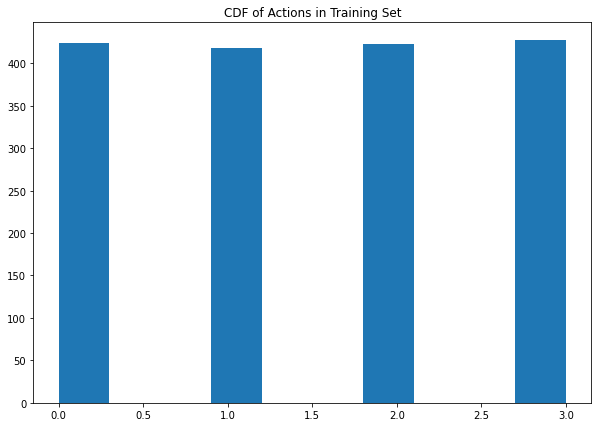

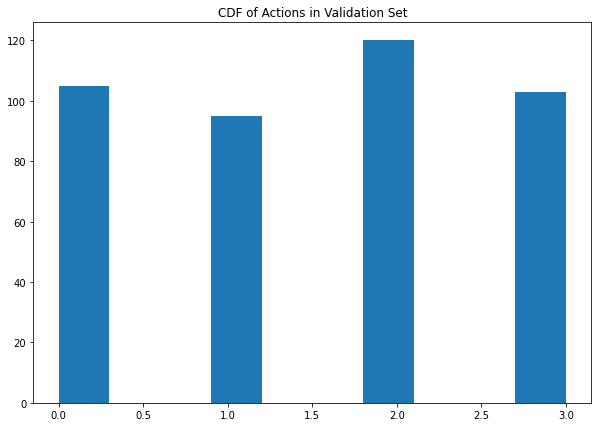

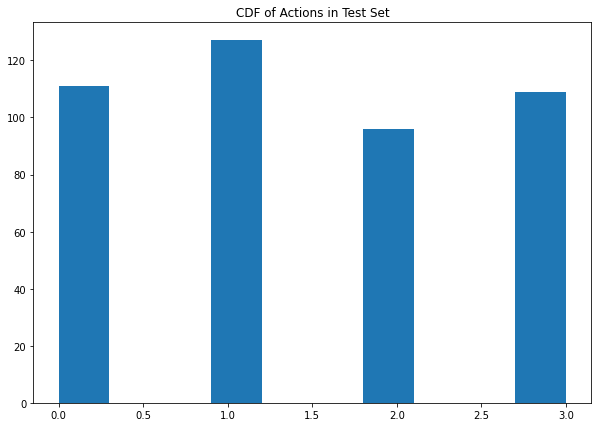

In [30]:
#want to see the distribution of actions, subjects
plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_train)
plt.title("CDF of Actions in Training Set")

plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_valid)
plt.title("CDF of Actions in Validation Set")

plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_test)
plt.title("CDF of Actions in Test Set")

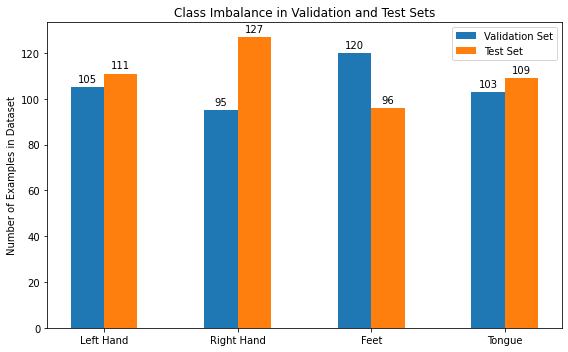

In [178]:
#make a grouped bar chart to show class imbalance

#first get counts in val and test sets
unique_val, counts_val = np.unique(y_valid, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

#print(counts_val)
#print(counts_test)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
#men_means = [20, 34, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, counts_val, width, label='Validation Set')
rects2 = ax.bar(x + width/2, counts_test, width, label='Test Set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Examples in Dataset')
ax.set_title('Class Imbalance in Validation and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [33]:
#instantiate and initialize pandas dataframes

columns = ['subject_ix', 'subject_one_hot', 'data_22ch', 'event_class_ix', 'event_class_one_hot']

train_df = pd.DataFrame(columns=columns)
train_df['subject_ix'] = person_train.reshape((person_train.shape[0],))
train_df['subject_one_hot'] = person_train_1h.tolist()
train_df['event_class_ix'] = y_train
train_df['event_class_one_hot'] = y_train_1h.tolist()
train_df['data_22ch'] = X_train.tolist()
train_df['data_22ch_norm_crop'] = X_train_norm_cropped.tolist()

valid_df = pd.DataFrame(columns=columns)
valid_df['subject_ix'] = person_valid.reshape((person_valid.shape[0],))
valid_df['subject_one_hot'] = person_valid_1h.tolist()
valid_df['event_class_ix'] = y_valid
valid_df['event_class_one_hot'] = y_valid_1h.tolist()
valid_df['data_22ch'] = X_valid.tolist()
valid_df['data_22ch_norm_crop'] = X_valid_norm_cropped.tolist()

test_df = pd.DataFrame(columns=columns)
test_df['subject_ix'] = person_test.reshape((person_test.shape[0],))
test_df['subject_one_hot'] = person_test_1h.tolist()
test_df['event_class_ix'] = y_test
test_df['event_class_one_hot'] = y_test.tolist()
test_df['data_22ch'] = X_test.tolist()
test_df['data_22ch_norm_crop'] = X_test_norm_cropped.tolist()

In [82]:
train_df[train_df['subject_ix']==7].index.values

array([   0,    1,   11,   17,   18,   20,   23,   40,   60,   79,   81,
         88,   91,  106,  110,  123,  132,  151,  158,  166,  171,  174,
        175,  180,  183,  222,  227,  228,  230,  234,  235,  236,  244,
        264,  269,  290,  296,  312,  316,  331,  335,  388,  392,  395,
        400,  419,  427,  428,  450,  460,  474,  485,  497,  509,  513,
        517,  526,  536,  539,  544,  567,  568,  571,  572,  573,  599,
        600,  605,  613,  614,  645,  653,  660,  668,  685,  686,  700,
        707,  708,  711,  724,  727,  736,  741,  749,  755,  792,  794,
        867,  870,  886,  887,  890,  896,  902,  916,  922,  936,  965,
        974,  988,  998,  999, 1003, 1007, 1018, 1036, 1049, 1050, 1054,
       1056, 1068, 1070, 1078, 1090, 1097, 1100, 1106, 1109, 1113, 1123,
       1125, 1128, 1131, 1137, 1173, 1180, 1199, 1206, 1267, 1271, 1309,
       1316, 1320, 1325, 1327, 1337, 1343, 1353, 1354, 1378, 1379, 1390,
       1406, 1414, 1420, 1434, 1446, 1459, 1462, 14

In [39]:
#n_comp = 18

#flip
X_train_flipped = np.transpose(X_train_norm_cropped, (0,2,1))
X_valid_flipped = np.transpose(X_valid_norm_cropped, (0,2,1))
X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))

print(X_train_flipped.shape)
print(X_valid_flipped.shape)
print(X_test_flipped.shape)

X_train_reshaped = X_train_flipped.reshape((X_train_norm_cropped.shape[0]*X_train_norm_cropped.shape[2], 22)) 
X_valid_reshaped = X_valid_flipped.reshape((X_valid_norm_cropped.shape[0]*X_valid_norm_cropped.shape[2], 22)) 
X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 

(1692, 500, 22)
(423, 500, 22)
(443, 500, 22)


In [40]:
n_comps = [15, 18, 20]

for n_comp in n_comps:
    #try a PCA on the training data
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_reshaped)                               #fit it to your transformed data
    X_train_transformed=np.empty([X_train_norm_cropped.shape[0],X_train_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_transformed[i]=pca.transform(X_train_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    print(X_train_transformed.shape)
    X_train_transformed = np.transpose(X_train_transformed, (0,2,1))
    print(X_train_transformed.shape)

    #now apply that transformation to the validation and test sets
    X_valid_transformed=np.empty([X_valid_norm_cropped.shape[0],X_valid_norm_cropped.shape[2],n_comp])
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])

    for i in range(len(X_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_valid_transformed[i]=pca.transform(X_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_train_transformed.shape)
    X_valid_transformed = np.transpose(X_valid_transformed, (0,2,1))
    print(X_valid_transformed.shape)

    for i in range(len(X_test_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_train_transformed.shape)
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    print(X_test_transformed.shape)

    train_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_train_transformed.tolist()
    valid_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_valid_transformed.tolist()
    test_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_test_transformed.tolist()

(1692, 500, 15)
(1692, 15, 500)
(423, 15, 500)
(443, 15, 500)
(1692, 500, 18)
(1692, 18, 500)
(423, 18, 500)
(443, 18, 500)
(1692, 500, 20)
(1692, 20, 500)
(423, 20, 500)
(443, 20, 500)


In [34]:
#examples of obtaining train_val and test dataframes from the larger dataframes

s0_train_df = train_df[train_df['subject_ix'] == 0]
s0_valid_df = valid_df[valid_df['subject_ix'] == 0]
s0_test_df = test_df[test_df['subject_ix'] == 0]

s1_train_df = train_df[train_df['subject_ix'] == 1]
s1_valid_df = valid_df[valid_df['subject_ix'] == 1]
s1_test_df = test_df[test_df['subject_ix'] == 1]

s2_train_df = train_df[train_df['subject_ix'] == 2]
s2_valid_df = valid_df[valid_df['subject_ix'] == 2]
s2_test_df = test_df[test_df['subject_ix'] == 2]

s3_train_df = train_df[train_df['subject_ix'] == 3]
s3_valid_df = valid_df[valid_df['subject_ix'] == 3]
s3_test_df = test_df[test_df['subject_ix'] == 3]

s4_train_df = train_df[train_df['subject_ix'] == 4]
s4_valid_df = valid_df[valid_df['subject_ix'] == 5]
s4_test_df = test_df[test_df['subject_ix'] == 4]

s5_train_df = train_df[train_df['subject_ix'] == 5]
s5_valid_df = valid_df[valid_df['subject_ix'] == 5]
s5_test_df = test_df[test_df['subject_ix'] == 5]

s6_train_df = train_df[train_df['subject_ix'] == 6]
s6_valid_df = valid_df[valid_df['subject_ix'] == 6]
s6_test_df = test_df[test_df['subject_ix'] == 6]

s7_train_df = train_df[train_df['subject_ix'] == 7]
s7_valid_df = valid_df[valid_df['subject_ix'] == 7]
s7_test_df = test_df[test_df['subject_ix'] == 7]

s8_train_df = train_df[train_df['subject_ix'] == 8]
s8_valid_df = valid_df[valid_df['subject_ix'] == 8]
s8_test_df = test_df[test_df['subject_ix'] == 8]

In [35]:
#example of grabbing the data from a given subject df
s0_X_train = np.array([[[value for value in ch] for ch in run] for run in s0_train_df['data_22ch_norm_crop'].values], ndmin=3)
s0_y_train = s0_train_df['subject_ix'].values

In [62]:
def get_X_data(df, n_dims=22):
    if n_dims == 22:
        return np.array([[[value for value in ch] for ch in run] for run in df['data_22ch_norm_crop'].values], ndmin=3)
    else:
        return np.array([[[value for value in ch] for ch in run] for run in df['data_22ch_norm_crop_pca'+str(n_dims)].values], ndmin=3)


In [66]:
#for example

s4_X_train = get_X_data(s4_train_df, 22)
print(s4_X_train.shape)

print(type(s4_X_train[0][10][8:50]))

(192, 22, 500)
<class 'numpy.ndarray'>


In [165]:
def get_model(n_timesteps=1000, drp=0.85, n_comp=22, subject_classification=False):
    
    if subject_classification:
        n_outputs=9
    else:
        n_outputs=4
        
    input_ = layers.Input(shape=(n_comp, n_timesteps))
    r1 = layers.Reshape(target_shape=(n_comp, n_timesteps, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((n_timesteps-24, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(drp)(f1)
    output_ = layers.Dense(n_outputs, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

    model = models.Model(inputs=input_, outputs=output_, name='shallow_pca_convnet_one_hot')
    return model

In [88]:
def plot_train_hist(loss_hist, drp, n_comp, subject_ix):
    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for dropout={} and n_dims={}".format(drp, n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

In [86]:
#trying to figure out how to best get the data

subject_ix = 4

#s_train_df = train_df[train_df['subject_ix'] == subject_ix]
#s_valid_df = valid_df[valid_df['subject_ix'] == subject_ix]
#s_test_df = test_df[test_df['subject_ix'] == subject_ix] 


subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

s_X_train = X_train_norm_cropped[subject_indices_train]
s_X_valid = X_valid_norm_cropped[subject_indices_valid]
s_X_test = X_test_norm_cropped[subject_indices_test]
print(s_X_train.shape)
print(s_X_valid.shape)
print(s_X_test.shape)

s_y_train = y_train_1h[subject_indices_train]
s_y_valid = y_valid_1h[subject_indices_valid]
s_y_test = y_test_1h[subject_indices_test]

print(s_y_train.shape)
print(s_y_valid.shape)
print(s_y_test.shape)

(192, 22, 500)
(43, 22, 500)
(47, 22, 500)
(192, 4)
(43, 4)
(47, 4)


Trianing model for subject #0
Epoch 1/150
6/6 [==============================] - 0s 24ms/step - loss: 2.7812 - acc: 0.2031 - val_loss: 1.4991 - val_acc: 0.2889
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.8438 - acc: 0.2500 - val_loss: 1.4742 - val_acc: 0.1556
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.6094 - acc: 0.2708 - val_loss: 1.4409 - val_acc: 0.2000
Epoch 4/150
6/6 [==============================] - 0s 10ms/step - loss: 1.4743 - acc: 0.2812 - val_loss: 1.4259 - val_acc: 0.2889
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 1.4395 - acc: 0.3438 - val_loss: 1.4232 - val_acc: 0.3556
Epoch 6/150
6/6 [==============================] - 0s 8ms/step - loss: 1.3512 - acc: 0.4010 - val_loss: 1.4436 - val_acc: 0.3333
Epoch 7/150
6/6 [==============================] - 0s 8ms/step - loss: 1.3580 - acc: 0.4115 - val_loss: 1.4651 - val_acc: 0.3556
Epoch 8/150
6/6 [==============================] - 0s 8ms/step

Epoch 64/150
6/6 [==============================] - 0s 7ms/step - loss: 0.7017 - acc: 0.7448 - val_loss: 1.2377 - val_acc: 0.4667
Epoch 65/150
6/6 [==============================] - 0s 7ms/step - loss: 0.7277 - acc: 0.7240 - val_loss: 1.2091 - val_acc: 0.5333
Epoch 66/150
6/6 [==============================] - 0s 10ms/step - loss: 0.6721 - acc: 0.7292 - val_loss: 1.1740 - val_acc: 0.5111
Epoch 67/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7076 - acc: 0.7344 - val_loss: 1.1039 - val_acc: 0.5556
Epoch 68/150
6/6 [==============================] - 0s 10ms/step - loss: 0.6357 - acc: 0.7917 - val_loss: 1.0470 - val_acc: 0.5556
Epoch 69/150
6/6 [==============================] - 0s 8ms/step - loss: 0.7070 - acc: 0.7344 - val_loss: 1.0802 - val_acc: 0.5111
Epoch 70/150
6/6 [==============================] - 0s 7ms/step - loss: 0.6284 - acc: 0.7760 - val_loss: 1.0709 - val_acc: 0.5556
Epoch 71/150
6/6 [==============================] - 0s 7ms/step - loss: 0.6173 - acc: 0.

Epoch 127/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2519 - acc: 0.9427 - val_loss: 0.8173 - val_acc: 0.6889
Epoch 128/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3146 - acc: 0.9271 - val_loss: 0.8398 - val_acc: 0.7556
Epoch 129/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2578 - acc: 0.9271 - val_loss: 0.8722 - val_acc: 0.7556
Epoch 130/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2626 - acc: 0.9427 - val_loss: 0.8200 - val_acc: 0.7111
Epoch 131/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3145 - acc: 0.9010 - val_loss: 0.8199 - val_acc: 0.6889
Epoch 132/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2912 - acc: 0.9115 - val_loss: 0.8148 - val_acc: 0.6444
Epoch 133/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2820 - acc: 0.9271 - val_loss: 0.8648 - val_acc: 0.6222
Epoch 134/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3118 - a

6/6 [==============================] - 0s 8ms/step - loss: 1.0677 - acc: 0.5538 - val_loss: 1.3774 - val_acc: 0.4000
Epoch 38/150
6/6 [==============================] - 0s 8ms/step - loss: 1.0413 - acc: 0.5376 - val_loss: 1.3732 - val_acc: 0.4000
Epoch 39/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0512 - acc: 0.5860 - val_loss: 1.3843 - val_acc: 0.4000
Epoch 40/150
6/6 [==============================] - 0s 8ms/step - loss: 0.9950 - acc: 0.6075 - val_loss: 1.3692 - val_acc: 0.4000
Epoch 41/150
6/6 [==============================] - 0s 8ms/step - loss: 1.0344 - acc: 0.5860 - val_loss: 1.3756 - val_acc: 0.4000
Epoch 42/150
6/6 [==============================] - 0s 8ms/step - loss: 1.0211 - acc: 0.5806 - val_loss: 1.3596 - val_acc: 0.4400
Epoch 43/150
6/6 [==============================] - 0s 8ms/step - loss: 0.9467 - acc: 0.6237 - val_loss: 1.3625 - val_acc: 0.4400
Epoch 44/150
6/6 [==============================] - 0s 10ms/step - loss: 0.9926 - acc: 0.5968 - val_los

6/6 [==============================] - 0s 8ms/step - loss: 0.5064 - acc: 0.8280 - val_loss: 1.3400 - val_acc: 0.5400
Epoch 101/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5227 - acc: 0.8387 - val_loss: 1.3876 - val_acc: 0.5600
Epoch 102/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4995 - acc: 0.8333 - val_loss: 1.3200 - val_acc: 0.5400
Epoch 103/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4907 - acc: 0.8441 - val_loss: 1.3739 - val_acc: 0.5400
Epoch 104/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4869 - acc: 0.8280 - val_loss: 1.3218 - val_acc: 0.5600
Epoch 105/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4986 - acc: 0.8387 - val_loss: 1.2731 - val_acc: 0.5400
Epoch 106/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4524 - acc: 0.8656 - val_loss: 1.2584 - val_acc: 0.5600
Epoch 107/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4670 - acc: 0.8710 - v

6/6 [==============================] - 0s 11ms/step - loss: 1.3052 - acc: 0.4068 - val_loss: 1.2952 - val_acc: 0.3729
Epoch 11/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2699 - acc: 0.4802 - val_loss: 1.2870 - val_acc: 0.3729
Epoch 12/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2423 - acc: 0.4520 - val_loss: 1.2810 - val_acc: 0.3898
Epoch 13/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2549 - acc: 0.3898 - val_loss: 1.2800 - val_acc: 0.3729
Epoch 14/150
6/6 [==============================] - 0s 10ms/step - loss: 1.1989 - acc: 0.5141 - val_loss: 1.2750 - val_acc: 0.3559
Epoch 15/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2130 - acc: 0.5028 - val_loss: 1.2679 - val_acc: 0.3729
Epoch 16/150
6/6 [==============================] - 0s 10ms/step - loss: 1.1734 - acc: 0.5085 - val_loss: 1.2667 - val_acc: 0.3729
Epoch 17/150
6/6 [==============================] - 0s 11ms/step - loss: 1.2165 - acc: 0.5085 - 

Epoch 73/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3409 - acc: 0.9209 - val_loss: 0.8758 - val_acc: 0.6610
Epoch 74/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3601 - acc: 0.8927 - val_loss: 0.8698 - val_acc: 0.6949
Epoch 75/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3855 - acc: 0.8757 - val_loss: 0.8828 - val_acc: 0.6610
Epoch 76/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3513 - acc: 0.9153 - val_loss: 0.8475 - val_acc: 0.6441
Epoch 77/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3653 - acc: 0.8983 - val_loss: 0.8527 - val_acc: 0.6780
Epoch 78/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3852 - acc: 0.8644 - val_loss: 0.8670 - val_acc: 0.6610
Epoch 79/150
6/6 [==============================] - 0s 10ms/step - loss: 0.2948 - acc: 0.9322 - val_loss: 0.8472 - val_acc: 0.6780
Epoch 80/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4229 - acc: 0.

6/6 [==============================] - 0s 8ms/step - loss: 0.1918 - acc: 0.9605 - val_loss: 0.7454 - val_acc: 0.6780
Epoch 136/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1628 - acc: 0.9718 - val_loss: 0.7215 - val_acc: 0.7288
Epoch 137/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1827 - acc: 0.9661 - val_loss: 0.7473 - val_acc: 0.7458
Epoch 138/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1448 - acc: 0.9887 - val_loss: 0.7125 - val_acc: 0.7288
Epoch 139/150
6/6 [==============================] - 0s 9ms/step - loss: 0.1696 - acc: 0.9718 - val_loss: 0.7207 - val_acc: 0.7288
Epoch 140/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1849 - acc: 0.9661 - val_loss: 0.7166 - val_acc: 0.7627
Epoch 141/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1787 - acc: 0.9831 - val_loss: 0.7032 - val_acc: 0.7458
Epoch 142/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1291 - acc: 0.9887 - 

6/6 [==============================] - 0s 8ms/step - loss: 0.9836 - acc: 0.6364 - val_loss: 1.3154 - val_acc: 0.4681
Epoch 46/150
6/6 [==============================] - 0s 8ms/step - loss: 0.8992 - acc: 0.6845 - val_loss: 1.3108 - val_acc: 0.4894
Epoch 47/150
6/6 [==============================] - 0s 8ms/step - loss: 0.9512 - acc: 0.6310 - val_loss: 1.3117 - val_acc: 0.4894
Epoch 48/150
6/6 [==============================] - 0s 7ms/step - loss: 0.8449 - acc: 0.6471 - val_loss: 1.3212 - val_acc: 0.5106
Epoch 49/150
6/6 [==============================] - 0s 8ms/step - loss: 0.8942 - acc: 0.6738 - val_loss: 1.3348 - val_acc: 0.4681
Epoch 50/150
6/6 [==============================] - 0s 8ms/step - loss: 0.9393 - acc: 0.5722 - val_loss: 1.3153 - val_acc: 0.5106
Epoch 51/150
6/6 [==============================] - 0s 8ms/step - loss: 0.8810 - acc: 0.6150 - val_loss: 1.3154 - val_acc: 0.4468
Epoch 52/150
6/6 [==============================] - 0s 8ms/step - loss: 0.9199 - acc: 0.6471 - val_loss

6/6 [==============================] - 0s 8ms/step - loss: 0.4764 - acc: 0.8396 - val_loss: 1.2920 - val_acc: 0.5957
Epoch 109/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4964 - acc: 0.8289 - val_loss: 1.2560 - val_acc: 0.5957
Epoch 110/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4789 - acc: 0.8342 - val_loss: 1.2317 - val_acc: 0.5532
Epoch 111/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4717 - acc: 0.8342 - val_loss: 1.2563 - val_acc: 0.5532
Epoch 112/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4657 - acc: 0.8610 - val_loss: 1.2560 - val_acc: 0.5745
Epoch 113/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4916 - acc: 0.8503 - val_loss: 1.2864 - val_acc: 0.5532
Epoch 114/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4931 - acc: 0.8449 - val_loss: 1.3207 - val_acc: 0.5106
Epoch 115/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4582 - acc: 0.8717 - 

6/6 [==============================] - 0s 8ms/step - loss: 1.1240 - acc: 0.5573 - val_loss: 1.2413 - val_acc: 0.4884
Epoch 19/150
6/6 [==============================] - 0s 7ms/step - loss: 1.0931 - acc: 0.5469 - val_loss: 1.2590 - val_acc: 0.5349
Epoch 20/150
6/6 [==============================] - 0s 7ms/step - loss: 0.9948 - acc: 0.6250 - val_loss: 1.2579 - val_acc: 0.4884
Epoch 21/150
6/6 [==============================] - 0s 7ms/step - loss: 1.0340 - acc: 0.5781 - val_loss: 1.2603 - val_acc: 0.4651
Epoch 22/150
6/6 [==============================] - 0s 7ms/step - loss: 1.0412 - acc: 0.5729 - val_loss: 1.2690 - val_acc: 0.5116
Epoch 23/150
6/6 [==============================] - 0s 7ms/step - loss: 1.0166 - acc: 0.6094 - val_loss: 1.2557 - val_acc: 0.5349
Epoch 24/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0108 - acc: 0.5938 - val_loss: 1.2192 - val_acc: 0.4884
Epoch 25/150
6/6 [==============================] - 0s 7ms/step - loss: 0.9896 - acc: 0.5573 - val_loss

6/6 [==============================] - 0s 7ms/step - loss: 0.3658 - acc: 0.8802 - val_loss: 0.9002 - val_acc: 0.6047
Epoch 82/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3458 - acc: 0.8802 - val_loss: 0.9020 - val_acc: 0.6047
Epoch 83/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4129 - acc: 0.8646 - val_loss: 0.9451 - val_acc: 0.6744
Epoch 84/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4201 - acc: 0.8333 - val_loss: 0.9309 - val_acc: 0.6047
Epoch 85/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3618 - acc: 0.9010 - val_loss: 0.9444 - val_acc: 0.5581
Epoch 86/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3660 - acc: 0.8802 - val_loss: 0.9832 - val_acc: 0.5581
Epoch 87/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3351 - acc: 0.8698 - val_loss: 0.9487 - val_acc: 0.6279
Epoch 88/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3560 - acc: 0.8698 - val_los

Epoch 144/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2721 - acc: 0.9115 - val_loss: 1.0939 - val_acc: 0.6279
Epoch 145/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2639 - acc: 0.9219 - val_loss: 1.0311 - val_acc: 0.6279
Epoch 146/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2514 - acc: 0.9375 - val_loss: 1.0433 - val_acc: 0.6512
Epoch 147/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2501 - acc: 0.9010 - val_loss: 1.1549 - val_acc: 0.6512
Epoch 148/150
6/6 [==============================] - 0s 6ms/step - loss: 0.2298 - acc: 0.9479 - val_loss: 1.1199 - val_acc: 0.6512
Epoch 149/150
6/6 [==============================] - 0s 6ms/step - loss: 0.2275 - acc: 0.9375 - val_loss: 1.0350 - val_acc: 0.6279
Epoch 150/150
2/2 [==============================] - 0s 1ms/step - loss: 1.3938 - acc: 0.6170
final test loss, test acc: [1.3938292264938354, 0.6170212626457214]
2/2 [==============================] - 0s 1ms/step -

7/7 [==============================] - 0s 7ms/step - loss: 1.1333 - acc: 0.5492 - val_loss: 1.4710 - val_acc: 0.3721
Epoch 55/150
7/7 [==============================] - 0s 7ms/step - loss: 1.2185 - acc: 0.5130 - val_loss: 1.4625 - val_acc: 0.4186
Epoch 56/150
7/7 [==============================] - 0s 7ms/step - loss: 1.1382 - acc: 0.5181 - val_loss: 1.6536 - val_acc: 0.4419
Epoch 57/150
7/7 [==============================] - 0s 7ms/step - loss: 1.1991 - acc: 0.5130 - val_loss: 1.5588 - val_acc: 0.4419
Epoch 58/150
7/7 [==============================] - 0s 7ms/step - loss: 1.2086 - acc: 0.5026 - val_loss: 1.4549 - val_acc: 0.4186
Epoch 59/150
7/7 [==============================] - 0s 7ms/step - loss: 1.1334 - acc: 0.5440 - val_loss: 1.4287 - val_acc: 0.3488
Epoch 60/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0882 - acc: 0.5648 - val_loss: 1.4305 - val_acc: 0.4419
Epoch 61/150
7/7 [==============================] - 0s 7ms/step - loss: 1.2127 - acc: 0.5233 - val_loss

Epoch 117/150
7/7 [==============================] - 0s 7ms/step - loss: 0.7342 - acc: 0.7254 - val_loss: 1.5241 - val_acc: 0.4419
Epoch 118/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0722 - acc: 0.6166 - val_loss: 1.4702 - val_acc: 0.4651
Epoch 119/150
7/7 [==============================] - 0s 7ms/step - loss: 0.9230 - acc: 0.6580 - val_loss: 1.5155 - val_acc: 0.4419
Epoch 120/150
7/7 [==============================] - 0s 7ms/step - loss: 0.8841 - acc: 0.6373 - val_loss: 1.5102 - val_acc: 0.4884
Epoch 121/150
7/7 [==============================] - 0s 7ms/step - loss: 0.8690 - acc: 0.6477 - val_loss: 1.4706 - val_acc: 0.4651
Epoch 122/150
7/7 [==============================] - 0s 7ms/step - loss: 0.8259 - acc: 0.6528 - val_loss: 1.4740 - val_acc: 0.5116
Epoch 123/150
7/7 [==============================] - 0s 7ms/step - loss: 0.8244 - acc: 0.7202 - val_loss: 1.4791 - val_acc: 0.5349
Epoch 124/150
7/7 [==============================] - 0s 7ms/step - loss: 0.7715 - a

6/6 [==============================] - 0s 7ms/step - loss: 0.8407 - acc: 0.6823 - val_loss: 1.1115 - val_acc: 0.5870
Epoch 28/150
6/6 [==============================] - 0s 9ms/step - loss: 0.8275 - acc: 0.6927 - val_loss: 1.0860 - val_acc: 0.5652
Epoch 29/150
6/6 [==============================] - 0s 11ms/step - loss: 0.8365 - acc: 0.6875 - val_loss: 1.0657 - val_acc: 0.5435
Epoch 30/150
6/6 [==============================] - 0s 9ms/step - loss: 0.8415 - acc: 0.6302 - val_loss: 1.0439 - val_acc: 0.6739
Epoch 31/150
6/6 [==============================] - 0s 9ms/step - loss: 0.8464 - acc: 0.6406 - val_loss: 1.0362 - val_acc: 0.6304
Epoch 32/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7677 - acc: 0.6771 - val_loss: 1.0327 - val_acc: 0.6087
Epoch 33/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7778 - acc: 0.7292 - val_loss: 1.0091 - val_acc: 0.6304
Epoch 34/150
6/6 [==============================] - 0s 7ms/step - loss: 0.7655 - acc: 0.7083 - val_los

6/6 [==============================] - 0s 7ms/step - loss: 0.3510 - acc: 0.8958 - val_loss: 0.7315 - val_acc: 0.6957
Epoch 91/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3279 - acc: 0.8750 - val_loss: 0.7155 - val_acc: 0.7174
Epoch 92/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3577 - acc: 0.8646 - val_loss: 0.7106 - val_acc: 0.7609
Epoch 93/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3721 - acc: 0.8698 - val_loss: 0.7822 - val_acc: 0.6957
Epoch 94/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3495 - acc: 0.8958 - val_loss: 0.7260 - val_acc: 0.7826
Epoch 95/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2933 - acc: 0.9115 - val_loss: 0.7204 - val_acc: 0.7609
Epoch 96/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3105 - acc: 0.8854 - val_loss: 0.7093 - val_acc: 0.7826
Epoch 97/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3902 - acc: 0.8854 - val_loss

best val loss model test loss, test acc: [0.8342685699462891, 0.6600000262260437]
Trianing model for subject #7
Epoch 1/150
6/6 [==============================] - 0s 25ms/step - loss: 2.6535 - acc: 0.2842 - val_loss: 1.7704 - val_acc: 0.2653
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 2.0545 - acc: 0.2732 - val_loss: 1.3585 - val_acc: 0.3265
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.6279 - acc: 0.2568 - val_loss: 1.3319 - val_acc: 0.3878
Epoch 4/150
6/6 [==============================] - 0s 10ms/step - loss: 1.4896 - acc: 0.2787 - val_loss: 1.2973 - val_acc: 0.4694
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 1.3541 - acc: 0.3607 - val_loss: 1.2734 - val_acc: 0.4286
Epoch 6/150
6/6 [==============================] - 0s 11ms/step - loss: 1.3219 - acc: 0.4153 - val_loss: 1.2567 - val_acc: 0.4490
Epoch 7/150
6/6 [==============================] - 0s 11ms/step - loss: 1.2779 - acc: 0.4262 - val_loss: 1.2

Epoch 63/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3459 - acc: 0.9126 - val_loss: 0.7949 - val_acc: 0.6939
Epoch 64/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4102 - acc: 0.8743 - val_loss: 0.7864 - val_acc: 0.7347
Epoch 65/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4071 - acc: 0.8852 - val_loss: 0.7660 - val_acc: 0.7143
Epoch 66/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3578 - acc: 0.8743 - val_loss: 0.8001 - val_acc: 0.6735
Epoch 67/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3701 - acc: 0.8579 - val_loss: 0.7717 - val_acc: 0.7551
Epoch 68/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3547 - acc: 0.8689 - val_loss: 0.8005 - val_acc: 0.7143
Epoch 69/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3431 - acc: 0.9071 - val_loss: 0.7949 - val_acc: 0.6939
Epoch 70/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3177 - acc: 0.8

Epoch 126/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2152 - acc: 0.9672 - val_loss: 0.6734 - val_acc: 0.8163
Epoch 127/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2023 - acc: 0.9563 - val_loss: 0.6511 - val_acc: 0.8571
Epoch 128/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2530 - acc: 0.9235 - val_loss: 0.6983 - val_acc: 0.7755
Epoch 129/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1834 - acc: 0.9399 - val_loss: 0.5999 - val_acc: 0.8163
Epoch 130/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2190 - acc: 0.9563 - val_loss: 0.6158 - val_acc: 0.8367
Epoch 131/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2136 - acc: 0.9235 - val_loss: 0.6092 - val_acc: 0.8163
Epoch 132/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1656 - acc: 0.9672 - val_loss: 0.5787 - val_acc: 0.8163
Epoch 133/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1715 - 

6/6 [==============================] - 0s 10ms/step - loss: 0.6227 - acc: 0.7947 - val_loss: 1.2117 - val_acc: 0.4878
Epoch 37/150
6/6 [==============================] - 0s 10ms/step - loss: 0.5360 - acc: 0.8158 - val_loss: 1.2013 - val_acc: 0.4634
Epoch 38/150
6/6 [==============================] - 0s 7ms/step - loss: 0.5633 - acc: 0.8105 - val_loss: 1.2376 - val_acc: 0.5122
Epoch 39/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5713 - acc: 0.7789 - val_loss: 1.2434 - val_acc: 0.4634
Epoch 40/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5065 - acc: 0.8105 - val_loss: 1.2700 - val_acc: 0.4634
Epoch 41/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4844 - acc: 0.8316 - val_loss: 1.2347 - val_acc: 0.4634
Epoch 42/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4850 - acc: 0.8211 - val_loss: 1.2258 - val_acc: 0.4878
Epoch 43/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5282 - acc: 0.8105 - val_lo

6/6 [==============================] - 0s 9ms/step - loss: 0.1630 - acc: 0.9632 - val_loss: 0.9637 - val_acc: 0.6829
Epoch 100/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1797 - acc: 0.9526 - val_loss: 0.8811 - val_acc: 0.7073
Epoch 101/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1616 - acc: 0.9737 - val_loss: 0.8996 - val_acc: 0.6829
Epoch 102/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1540 - acc: 0.9737 - val_loss: 0.9627 - val_acc: 0.6341
Epoch 103/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1460 - acc: 0.9789 - val_loss: 0.9517 - val_acc: 0.6585
Epoch 104/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1771 - acc: 0.9474 - val_loss: 0.9324 - val_acc: 0.6829
Epoch 105/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1864 - acc: 0.9474 - val_loss: 0.9496 - val_acc: 0.6341
Epoch 106/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1745 - acc: 0.9684 - 

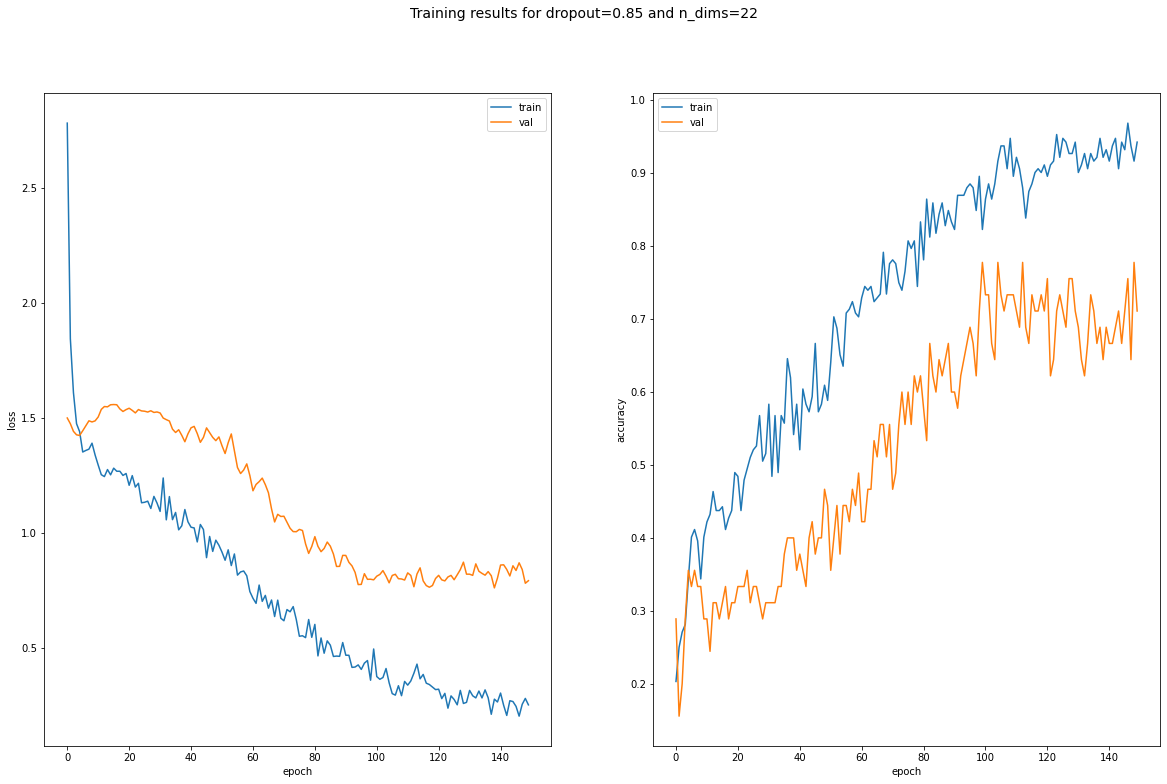

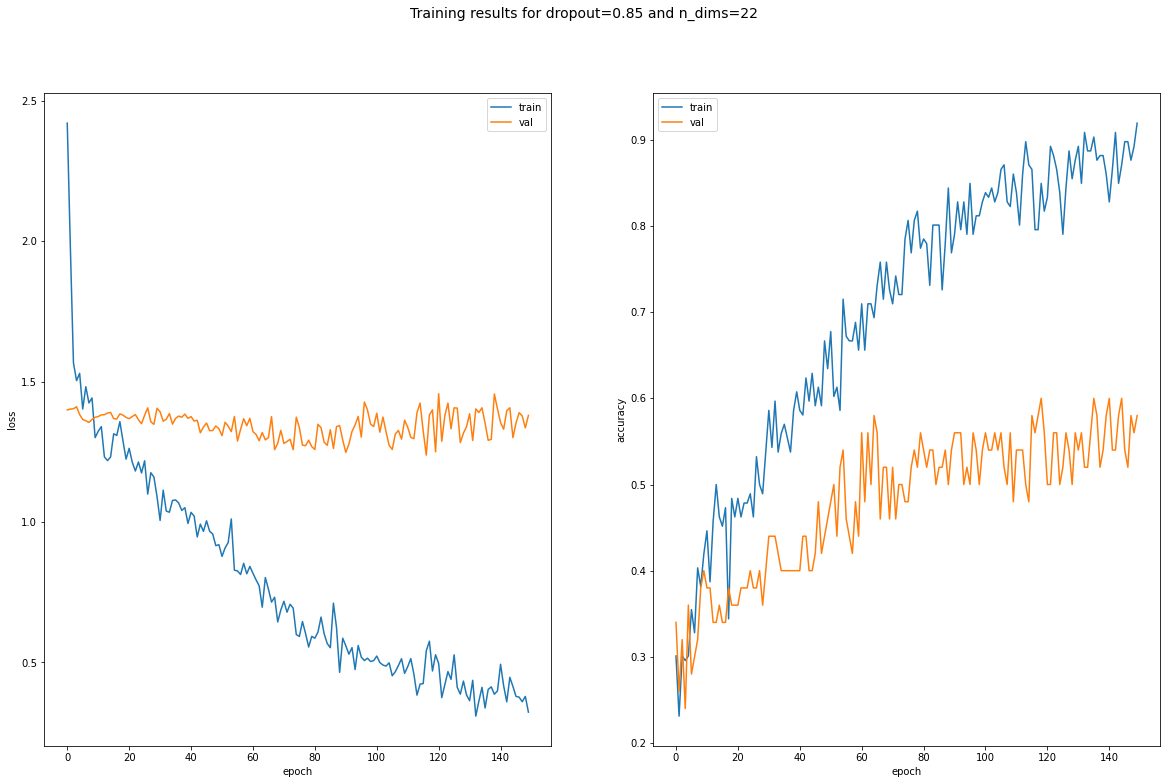

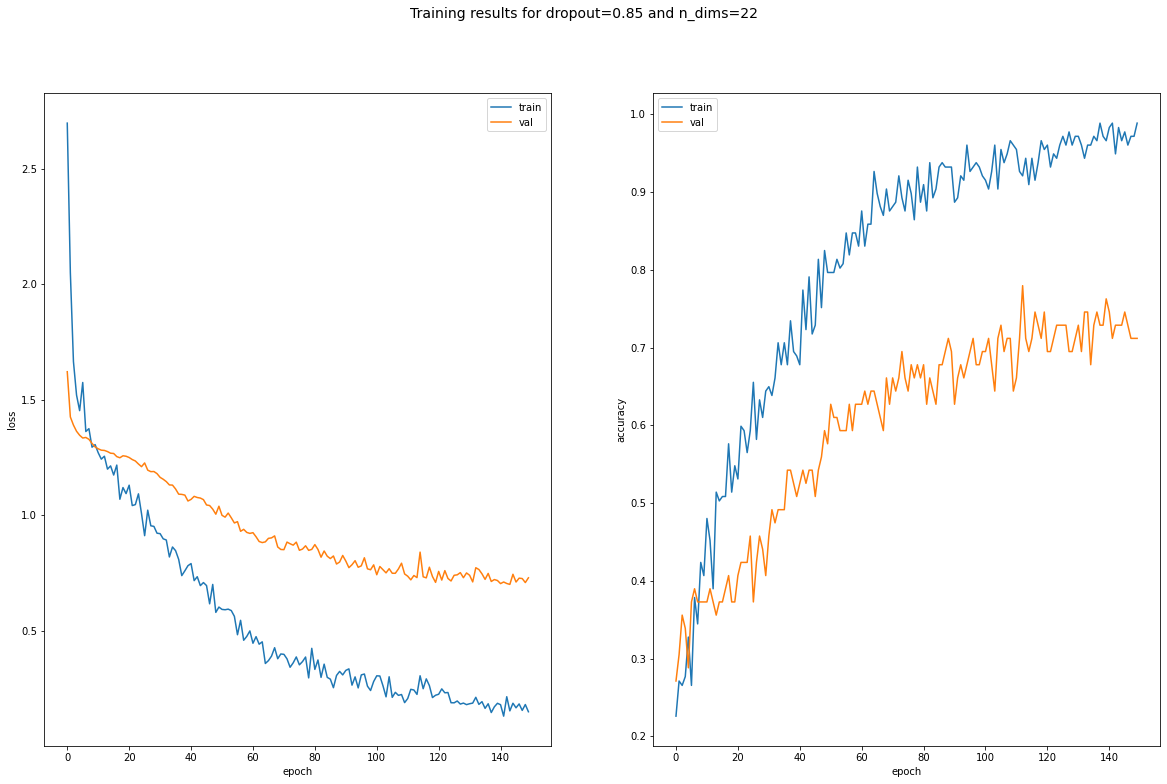

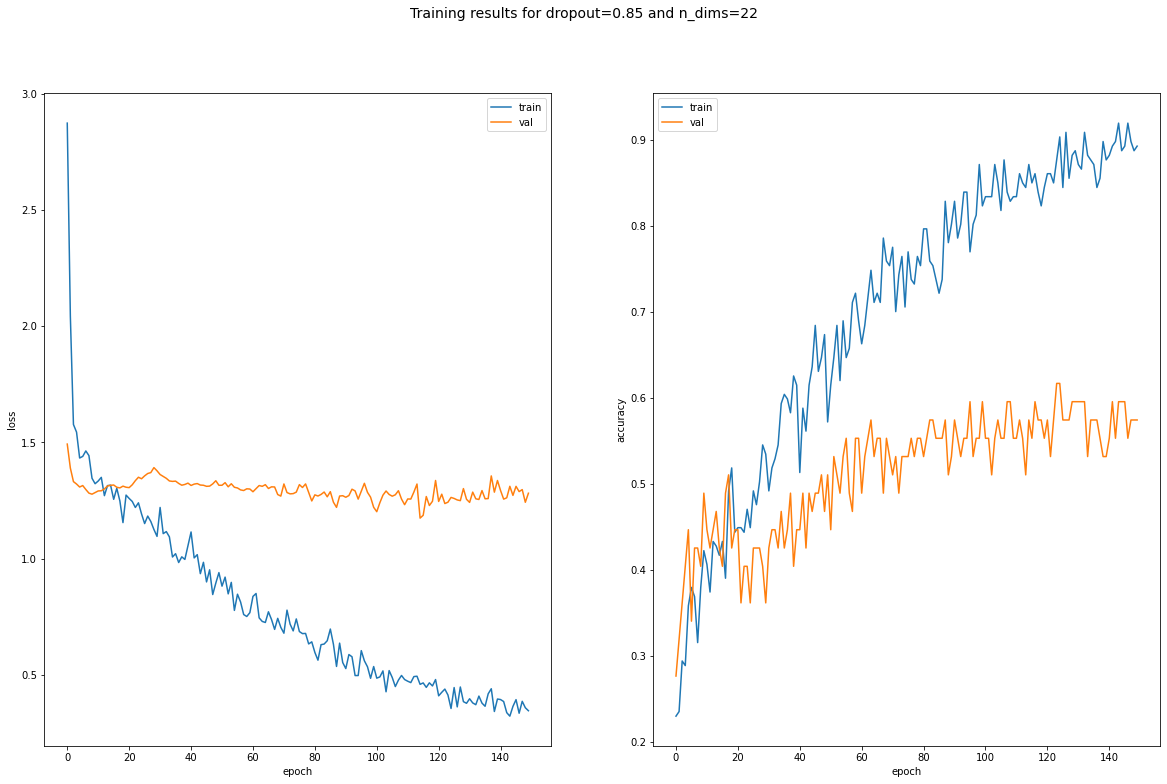

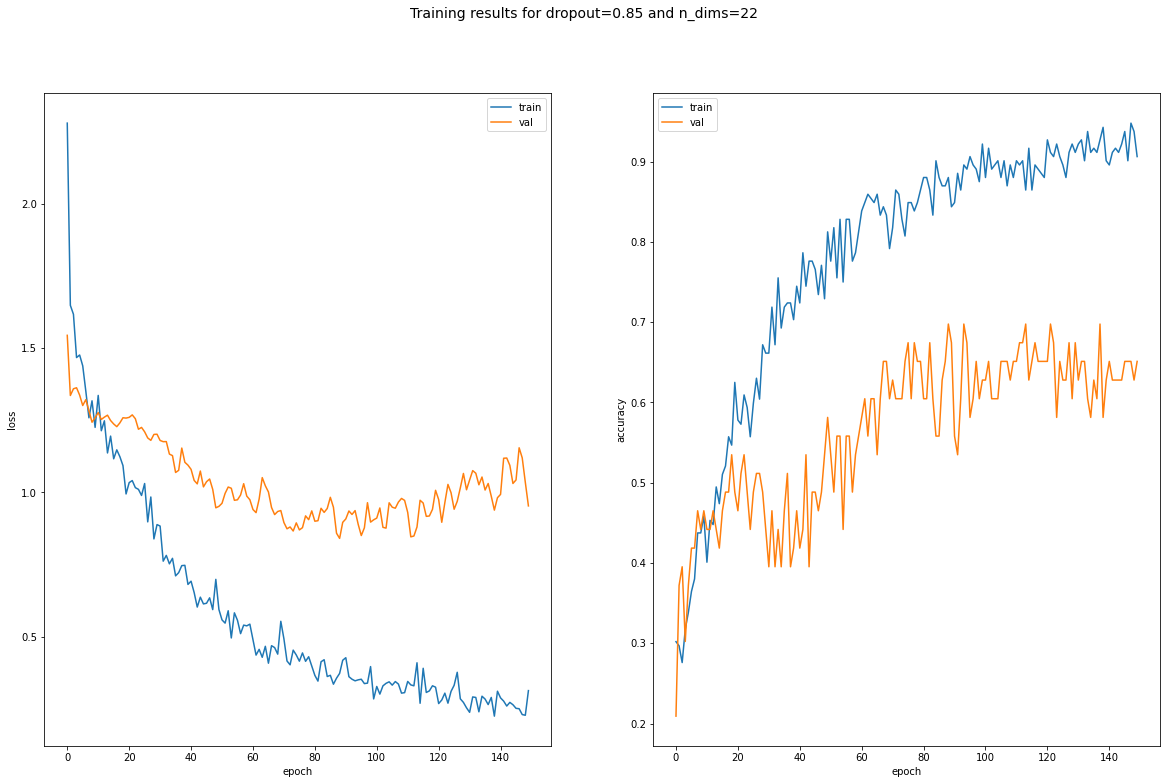

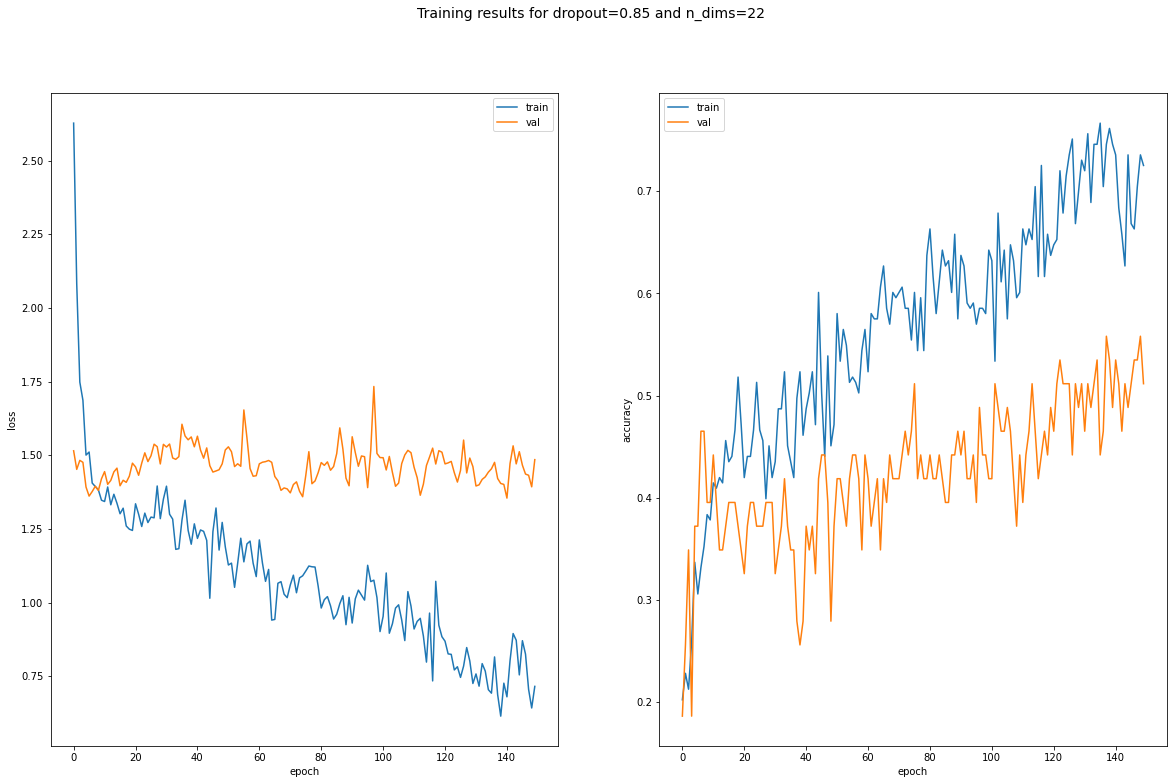

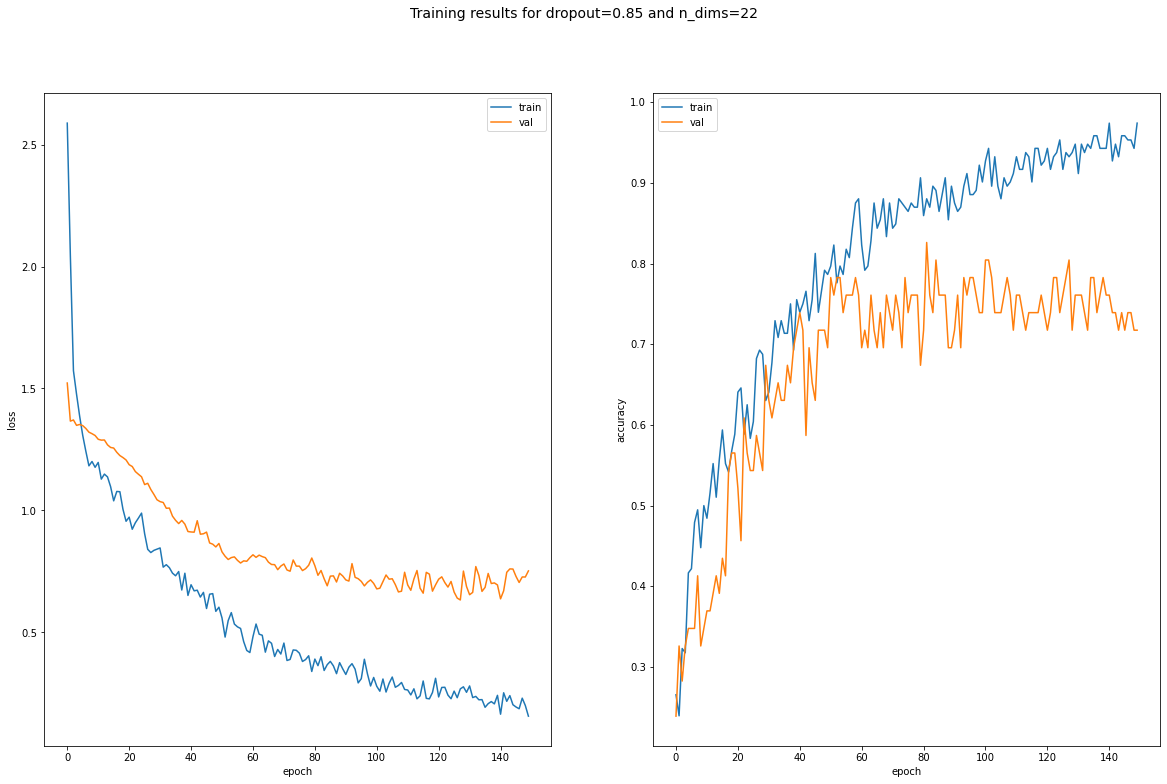

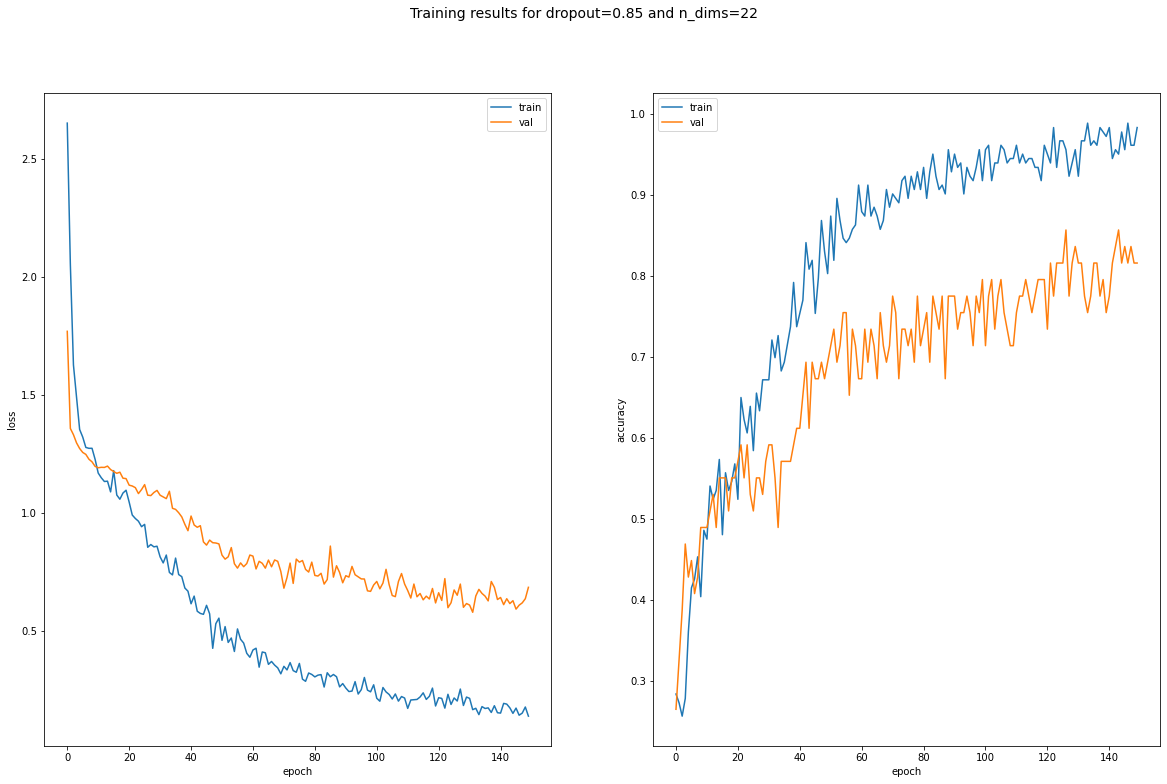

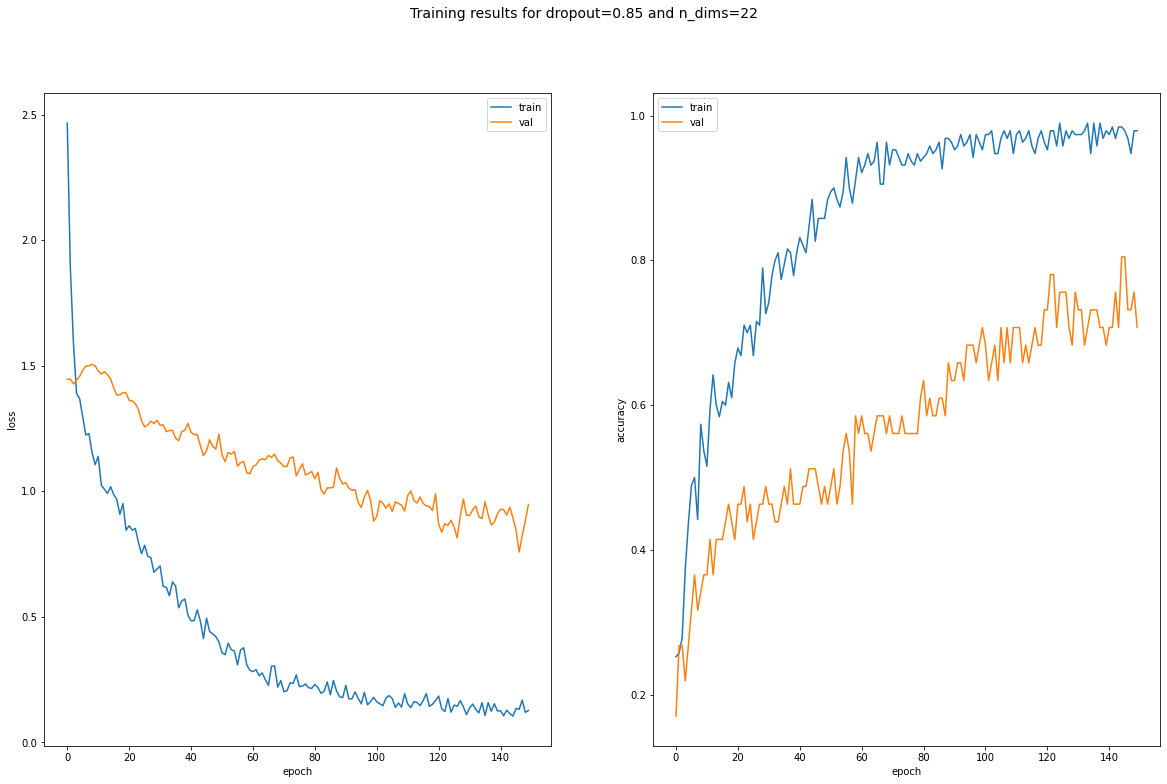

In [116]:
#Now let's train a model on the normalized data with crop for all subjects

drp = 0.85
n_comp=22

subject_test_accs = []
subject_test_accuracies_best_val = []

for subject_ix in range(9):
    
    print("Trianing model for subject #{}".format(subject_ix))
    
    subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
    subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
    subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

    s_X_train = X_train_norm_cropped[subject_indices_train]
    s_X_valid = X_valid_norm_cropped[subject_indices_valid]
    s_X_test = X_test_norm_cropped[subject_indices_test]

    s_y_train = y_train_1h[subject_indices_train]
    s_y_valid = y_valid_1h[subject_indices_valid]
    s_y_test = y_test_1h[subject_indices_test]

    
    model = get_model(n_timesteps=500, drp=0.85, n_comp=22)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                         save_best_only=True, monitor='val_loss', mode='min')
    
    loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                          validation_data=(s_X_valid, s_y_valid),
                          callbacks=[mcp_save], 
                          verbose=True)
    
    plot_train_hist(loss_hist,drp,n_comp,subject_ix)
    
    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate final step on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("final test loss, test acc:", results)
    subject_test_accs.append(results[1])
    
    model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate best val acc model on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("best val loss model test loss, test acc:", results)

    subject_test_accuracies_best_val.append(results[1])

In [129]:
print(subject_test_accs)
print(subject_test_accuracies_best_val)

subj_acc_means_crop_norm = (np.array(subject_test_accs) + np.array(subject_test_accuracies_best_val))/2


[0.6800000071525574, 0.5600000023841858, 0.6800000071525574, 0.5799999833106995, 0.6170212626457214, 0.36734694242477417, 0.6800000071525574, 0.800000011920929, 0.8297872543334961]
[0.6800000071525574, 0.5600000023841858, 0.699999988079071, 0.5799999833106995, 0.5957446694374084, 0.4285714328289032, 0.6600000262260437, 0.7200000286102295, 0.8085106611251831]


Trianing model for subject #0
Epoch 1/150
6/6 [==============================] - 0s 29ms/step - loss: 3.8066 - acc: 0.2240 - val_loss: 1.6823 - val_acc: 0.2222
Epoch 2/150
6/6 [==============================] - 0s 15ms/step - loss: 2.3837 - acc: 0.3125 - val_loss: 1.3798 - val_acc: 0.4222
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 1.8113 - acc: 0.3073 - val_loss: 1.3618 - val_acc: 0.3778
Epoch 4/150
6/6 [==============================] - 0s 12ms/step - loss: 1.5213 - acc: 0.3906 - val_loss: 1.3743 - val_acc: 0.3111
Epoch 5/150
6/6 [==============================] - 0s 12ms/step - loss: 1.7373 - acc: 0.3125 - val_loss: 1.4392 - val_acc: 0.3333
Epoch 6/150
6/6 [==============================] - 0s 11ms/step - loss: 1.6367 - acc: 0.3750 - val_loss: 1.4687 - val_acc: 0.3111
Epoch 7/150
6/6 [==============================] - 0s 11ms/step - loss: 1.5563 - acc: 0.3802 - val_loss: 1.4589 - val_acc: 0.3333
Epoch 8/150
6/6 [==============================] - 0s 11ms/s

6/6 [==============================] - 0s 11ms/step - loss: 0.4871 - acc: 0.8333 - val_loss: 1.4048 - val_acc: 0.4000
Epoch 64/150
6/6 [==============================] - 0s 12ms/step - loss: 0.5169 - acc: 0.7969 - val_loss: 1.3363 - val_acc: 0.4000
Epoch 65/150
6/6 [==============================] - 0s 14ms/step - loss: 0.3972 - acc: 0.8542 - val_loss: 1.2950 - val_acc: 0.3778
Epoch 66/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4356 - acc: 0.8438 - val_loss: 1.2970 - val_acc: 0.4222
Epoch 67/150
6/6 [==============================] - 0s 14ms/step - loss: 0.3784 - acc: 0.9115 - val_loss: 1.2591 - val_acc: 0.4222
Epoch 68/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4426 - acc: 0.8542 - val_loss: 1.2611 - val_acc: 0.4000
Epoch 69/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3827 - acc: 0.8750 - val_loss: 1.2685 - val_acc: 0.4222
Epoch 70/150
6/6 [==============================] - 0s 13ms/step - loss: 0.3440 - acc: 0.8750 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.2036 - acc: 0.9479 - val_loss: 1.0698 - val_acc: 0.6000
Epoch 126/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2575 - acc: 0.9271 - val_loss: 1.1912 - val_acc: 0.5333
Epoch 127/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2083 - acc: 0.9479 - val_loss: 1.1118 - val_acc: 0.5111
Epoch 128/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2287 - acc: 0.9375 - val_loss: 1.1091 - val_acc: 0.5333
Epoch 129/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2065 - acc: 0.9375 - val_loss: 1.0942 - val_acc: 0.5333
Epoch 130/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2034 - acc: 0.9375 - val_loss: 1.0902 - val_acc: 0.5333
Epoch 131/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1687 - acc: 0.9792 - val_loss: 1.0442 - val_acc: 0.5333
Epoch 132/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1522 - acc: 0.

Epoch 35/150
6/6 [==============================] - 0s 12ms/step - loss: 0.8404 - acc: 0.6398 - val_loss: 1.4946 - val_acc: 0.4200
Epoch 36/150
6/6 [==============================] - 0s 12ms/step - loss: 0.8010 - acc: 0.6828 - val_loss: 1.4719 - val_acc: 0.4200
Epoch 37/150
6/6 [==============================] - 0s 12ms/step - loss: 0.8595 - acc: 0.6559 - val_loss: 1.4681 - val_acc: 0.4000
Epoch 38/150
6/6 [==============================] - 0s 12ms/step - loss: 0.8249 - acc: 0.7258 - val_loss: 1.5185 - val_acc: 0.4600
Epoch 39/150
6/6 [==============================] - 0s 13ms/step - loss: 0.8203 - acc: 0.6882 - val_loss: 1.5512 - val_acc: 0.4600
Epoch 40/150
6/6 [==============================] - 0s 13ms/step - loss: 0.8293 - acc: 0.6774 - val_loss: 1.5293 - val_acc: 0.4000
Epoch 41/150
6/6 [==============================] - 0s 13ms/step - loss: 0.8486 - acc: 0.6452 - val_loss: 1.5152 - val_acc: 0.4000
Epoch 42/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7311 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.4193 - acc: 0.8602 - val_loss: 1.5453 - val_acc: 0.4600
Epoch 98/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4141 - acc: 0.8602 - val_loss: 1.5661 - val_acc: 0.4600
Epoch 99/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4026 - acc: 0.8817 - val_loss: 1.5366 - val_acc: 0.4600
Epoch 100/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3494 - acc: 0.8925 - val_loss: 1.5850 - val_acc: 0.4800
Epoch 101/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4820 - acc: 0.8333 - val_loss: 1.5614 - val_acc: 0.5000
Epoch 102/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3734 - acc: 0.8871 - val_loss: 1.5258 - val_acc: 0.5000
Epoch 103/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3576 - acc: 0.8925 - val_loss: 1.5238 - val_acc: 0.4600
Epoch 104/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4024 - acc: 0.87

Epoch 7/150
6/6 [==============================] - 0s 12ms/step - loss: 1.3784 - acc: 0.4011 - val_loss: 1.2710 - val_acc: 0.4068
Epoch 8/150
6/6 [==============================] - 0s 14ms/step - loss: 1.4695 - acc: 0.3051 - val_loss: 1.2410 - val_acc: 0.3898
Epoch 9/150
6/6 [==============================] - 0s 15ms/step - loss: 1.2854 - acc: 0.4689 - val_loss: 1.2169 - val_acc: 0.4746
Epoch 10/150
6/6 [==============================] - 0s 15ms/step - loss: 1.2725 - acc: 0.4746 - val_loss: 1.2072 - val_acc: 0.5085
Epoch 11/150
6/6 [==============================] - 0s 12ms/step - loss: 1.2348 - acc: 0.4915 - val_loss: 1.2097 - val_acc: 0.4407
Epoch 12/150
6/6 [==============================] - 0s 15ms/step - loss: 1.2009 - acc: 0.5254 - val_loss: 1.2061 - val_acc: 0.4407
Epoch 13/150
6/6 [==============================] - 0s 14ms/step - loss: 1.2204 - acc: 0.5085 - val_loss: 1.2013 - val_acc: 0.4576
Epoch 14/150
6/6 [==============================] - 0s 15ms/step - loss: 1.1619 - acc:

6/6 [==============================] - 0s 12ms/step - loss: 0.3264 - acc: 0.9266 - val_loss: 1.0095 - val_acc: 0.6271
Epoch 70/150
6/6 [==============================] - 0s 14ms/step - loss: 0.3183 - acc: 0.9266 - val_loss: 0.9681 - val_acc: 0.6102
Epoch 71/150
6/6 [==============================] - 0s 14ms/step - loss: 0.2783 - acc: 0.9435 - val_loss: 0.9572 - val_acc: 0.6271
Epoch 72/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3484 - acc: 0.9096 - val_loss: 0.9628 - val_acc: 0.6271
Epoch 73/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2801 - acc: 0.9266 - val_loss: 0.9771 - val_acc: 0.6441
Epoch 74/150
6/6 [==============================] - 0s 13ms/step - loss: 0.2973 - acc: 0.9153 - val_loss: 0.9612 - val_acc: 0.6780
Epoch 75/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3470 - acc: 0.9040 - val_loss: 1.0174 - val_acc: 0.6271
Epoch 76/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2827 - acc: 0.9153 - 

6/6 [==============================] - 0s 13ms/step - loss: 0.1348 - acc: 0.9944 - val_loss: 0.8962 - val_acc: 0.6441
Epoch 132/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1794 - acc: 0.9661 - val_loss: 0.8829 - val_acc: 0.6610
Epoch 133/150
6/6 [==============================] - 0s 14ms/step - loss: 0.1245 - acc: 0.9887 - val_loss: 0.8423 - val_acc: 0.6610
Epoch 134/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1329 - acc: 0.9831 - val_loss: 0.8513 - val_acc: 0.7458
Epoch 135/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1450 - acc: 0.9831 - val_loss: 0.8808 - val_acc: 0.6949
Epoch 136/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1446 - acc: 0.9831 - val_loss: 0.8994 - val_acc: 0.6949
Epoch 137/150
6/6 [==============================] - 0s 14ms/step - loss: 0.1441 - acc: 0.9774 - val_loss: 0.8369 - val_acc: 0.7119
Epoch 138/150
6/6 [==============================] - 0s 14ms/step - loss: 0.1331 - acc: 0.

Epoch 41/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7841 - acc: 0.6791 - val_loss: 1.5169 - val_acc: 0.4255
Epoch 42/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7163 - acc: 0.7647 - val_loss: 1.5336 - val_acc: 0.3830
Epoch 43/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7066 - acc: 0.7273 - val_loss: 1.5478 - val_acc: 0.3191
Epoch 44/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7403 - acc: 0.7112 - val_loss: 1.5479 - val_acc: 0.3617
Epoch 45/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7359 - acc: 0.7005 - val_loss: 1.5619 - val_acc: 0.4043
Epoch 46/150
6/6 [==============================] - 0s 12ms/step - loss: 0.6530 - acc: 0.7754 - val_loss: 1.5638 - val_acc: 0.4043
Epoch 47/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7034 - acc: 0.7433 - val_loss: 1.5679 - val_acc: 0.3404
Epoch 48/150
6/6 [==============================] - 0s 12ms/step - loss: 0.7501 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.3177 - acc: 0.9198 - val_loss: 1.7550 - val_acc: 0.3830
Epoch 104/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3038 - acc: 0.9251 - val_loss: 1.7411 - val_acc: 0.3830
Epoch 105/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3313 - acc: 0.9251 - val_loss: 1.7326 - val_acc: 0.3830
Epoch 106/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2963 - acc: 0.9251 - val_loss: 1.7250 - val_acc: 0.3404
Epoch 107/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3221 - acc: 0.9144 - val_loss: 1.7295 - val_acc: 0.4468
Epoch 108/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2881 - acc: 0.9144 - val_loss: 1.7955 - val_acc: 0.3617
Epoch 109/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3462 - acc: 0.9091 - val_loss: 1.8496 - val_acc: 0.3191
Epoch 110/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2550 - acc: 0.

Epoch 13/150
6/6 [==============================] - 0s 11ms/step - loss: 1.2779 - acc: 0.4896 - val_loss: 1.3288 - val_acc: 0.4651
Epoch 14/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1472 - acc: 0.4792 - val_loss: 1.3099 - val_acc: 0.4884
Epoch 15/150
6/6 [==============================] - 0s 12ms/step - loss: 1.1254 - acc: 0.5365 - val_loss: 1.3017 - val_acc: 0.5349
Epoch 16/150
6/6 [==============================] - 0s 11ms/step - loss: 1.0844 - acc: 0.5000 - val_loss: 1.3049 - val_acc: 0.5349
Epoch 17/150
6/6 [==============================] - 0s 11ms/step - loss: 1.0714 - acc: 0.5260 - val_loss: 1.3167 - val_acc: 0.5349
Epoch 18/150
6/6 [==============================] - 0s 11ms/step - loss: 1.0948 - acc: 0.5625 - val_loss: 1.3318 - val_acc: 0.5116
Epoch 19/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1134 - acc: 0.5312 - val_loss: 1.3707 - val_acc: 0.4884
Epoch 20/150
6/6 [==============================] - 0s 11ms/step - loss: 0.9947 - a

6/6 [==============================] - 0s 11ms/step - loss: 0.3293 - acc: 0.8906 - val_loss: 1.2688 - val_acc: 0.4186
Epoch 76/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3299 - acc: 0.8854 - val_loss: 1.3223 - val_acc: 0.4419
Epoch 77/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3190 - acc: 0.8958 - val_loss: 1.3590 - val_acc: 0.4651
Epoch 78/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2509 - acc: 0.9271 - val_loss: 1.3740 - val_acc: 0.4651
Epoch 79/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2590 - acc: 0.9219 - val_loss: 1.4061 - val_acc: 0.4419
Epoch 80/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3336 - acc: 0.8906 - val_loss: 1.3319 - val_acc: 0.4186
Epoch 81/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2351 - acc: 0.9479 - val_loss: 1.2948 - val_acc: 0.4419
Epoch 82/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3396 - acc: 0.9062 - 

6/6 [==============================] - 0s 11ms/step - loss: 0.1981 - acc: 0.9531 - val_loss: 1.2912 - val_acc: 0.5116
Epoch 138/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1930 - acc: 0.9427 - val_loss: 1.3330 - val_acc: 0.5116
Epoch 139/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1735 - acc: 0.9635 - val_loss: 1.2927 - val_acc: 0.5581
Epoch 140/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2003 - acc: 0.9375 - val_loss: 1.1920 - val_acc: 0.5814
Epoch 141/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1954 - acc: 0.9375 - val_loss: 1.2425 - val_acc: 0.5349
Epoch 142/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1770 - acc: 0.9740 - val_loss: 1.3243 - val_acc: 0.5581
Epoch 143/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1717 - acc: 0.9583 - val_loss: 1.3501 - val_acc: 0.4651
Epoch 144/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1813 - acc: 0.

7/7 [==============================] - 0s 11ms/step - loss: 0.9469 - acc: 0.6062 - val_loss: 1.6240 - val_acc: 0.3721
Epoch 48/150
7/7 [==============================] - 0s 10ms/step - loss: 1.1658 - acc: 0.5855 - val_loss: 1.6434 - val_acc: 0.4186
Epoch 49/150
7/7 [==============================] - 0s 11ms/step - loss: 1.0516 - acc: 0.6218 - val_loss: 1.7655 - val_acc: 0.3953
Epoch 50/150
7/7 [==============================] - 0s 11ms/step - loss: 1.2184 - acc: 0.5699 - val_loss: 1.7661 - val_acc: 0.3953
Epoch 51/150
7/7 [==============================] - 0s 10ms/step - loss: 0.9629 - acc: 0.6425 - val_loss: 1.6190 - val_acc: 0.3953
Epoch 52/150
7/7 [==============================] - 0s 11ms/step - loss: 0.9976 - acc: 0.6528 - val_loss: 1.6583 - val_acc: 0.3953
Epoch 53/150
7/7 [==============================] - 0s 10ms/step - loss: 1.1021 - acc: 0.5959 - val_loss: 1.6644 - val_acc: 0.3953
Epoch 54/150
7/7 [==============================] - 0s 10ms/step - loss: 1.1188 - acc: 0.6321 - 

7/7 [==============================] - 0s 10ms/step - loss: 0.5978 - acc: 0.7979 - val_loss: 1.6958 - val_acc: 0.4419
Epoch 110/150
7/7 [==============================] - 0s 11ms/step - loss: 0.8725 - acc: 0.7098 - val_loss: 1.6752 - val_acc: 0.4419
Epoch 111/150
7/7 [==============================] - 0s 11ms/step - loss: 0.7546 - acc: 0.7720 - val_loss: 1.7197 - val_acc: 0.4419
Epoch 112/150
7/7 [==============================] - 0s 11ms/step - loss: 0.7197 - acc: 0.7461 - val_loss: 1.7213 - val_acc: 0.4186
Epoch 113/150
7/7 [==============================] - 0s 10ms/step - loss: 0.7218 - acc: 0.7358 - val_loss: 1.7134 - val_acc: 0.4186
Epoch 114/150
7/7 [==============================] - 0s 10ms/step - loss: 0.7917 - acc: 0.7150 - val_loss: 1.7204 - val_acc: 0.3721
Epoch 115/150
7/7 [==============================] - 0s 10ms/step - loss: 0.6576 - acc: 0.7772 - val_loss: 1.7214 - val_acc: 0.4186
Epoch 116/150
7/7 [==============================] - 0s 10ms/step - loss: 0.5846 - acc: 0.

Epoch 19/150
6/6 [==============================] - 0s 13ms/step - loss: 1.0664 - acc: 0.5938 - val_loss: 1.3890 - val_acc: 0.3478
Epoch 20/150
6/6 [==============================] - 0s 15ms/step - loss: 1.0515 - acc: 0.5677 - val_loss: 1.3778 - val_acc: 0.3478
Epoch 21/150
6/6 [==============================] - 0s 11ms/step - loss: 0.9852 - acc: 0.6042 - val_loss: 1.3856 - val_acc: 0.3696
Epoch 22/150
6/6 [==============================] - 0s 11ms/step - loss: 0.9388 - acc: 0.6198 - val_loss: 1.4206 - val_acc: 0.3696
Epoch 23/150
6/6 [==============================] - 0s 11ms/step - loss: 0.9175 - acc: 0.6146 - val_loss: 1.4201 - val_acc: 0.3478
Epoch 24/150
6/6 [==============================] - 0s 13ms/step - loss: 0.8820 - acc: 0.6667 - val_loss: 1.3744 - val_acc: 0.4130
Epoch 25/150
6/6 [==============================] - 0s 14ms/step - loss: 0.7493 - acc: 0.7083 - val_loss: 1.3455 - val_acc: 0.3696
Epoch 26/150
6/6 [==============================] - 0s 13ms/step - loss: 0.9463 - a

6/6 [==============================] - 0s 13ms/step - loss: 0.2637 - acc: 0.9167 - val_loss: 0.8559 - val_acc: 0.7174
Epoch 82/150
6/6 [==============================] - 0s 13ms/step - loss: 0.2662 - acc: 0.9427 - val_loss: 0.8241 - val_acc: 0.6957
Epoch 83/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2579 - acc: 0.9323 - val_loss: 0.8782 - val_acc: 0.6739
Epoch 84/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2461 - acc: 0.9323 - val_loss: 0.9171 - val_acc: 0.6739
Epoch 85/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2909 - acc: 0.9219 - val_loss: 0.9098 - val_acc: 0.6957
Epoch 86/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2498 - acc: 0.9167 - val_loss: 0.9377 - val_acc: 0.6957
Epoch 87/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2799 - acc: 0.9010 - val_loss: 0.8607 - val_acc: 0.6957
Epoch 88/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2561 - acc: 0.9479 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.1743 - acc: 0.9688 - val_loss: 0.9228 - val_acc: 0.7391
Epoch 144/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2237 - acc: 0.9375 - val_loss: 0.9571 - val_acc: 0.7391
Epoch 145/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1469 - acc: 0.9688 - val_loss: 0.9222 - val_acc: 0.6957
Epoch 146/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1493 - acc: 0.9844 - val_loss: 0.9339 - val_acc: 0.6957
Epoch 147/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1706 - acc: 0.9688 - val_loss: 0.9248 - val_acc: 0.7609
Epoch 148/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1615 - acc: 0.9740 - val_loss: 0.9143 - val_acc: 0.7391
Epoch 149/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1563 - acc: 0.9688 - val_loss: 0.9558 - val_acc: 0.7609
Epoch 150/150
2/2 [==============================] - 0s 2ms/step - loss: 1.1723 - acc: 0.6

6/6 [==============================] - 0s 12ms/step - loss: 0.4081 - acc: 0.8525 - val_loss: 0.8936 - val_acc: 0.6735
Epoch 54/150
6/6 [==============================] - 0s 16ms/step - loss: 0.2678 - acc: 0.9508 - val_loss: 0.8791 - val_acc: 0.6939
Epoch 55/150
6/6 [==============================] - 0s 14ms/step - loss: 0.3176 - acc: 0.9235 - val_loss: 0.8758 - val_acc: 0.6735
Epoch 56/150
6/6 [==============================] - 0s 14ms/step - loss: 0.2738 - acc: 0.9617 - val_loss: 0.8440 - val_acc: 0.6939
Epoch 57/150
6/6 [==============================] - 0s 16ms/step - loss: 0.2392 - acc: 0.9454 - val_loss: 0.8430 - val_acc: 0.6531
Epoch 58/150
6/6 [==============================] - 0s 13ms/step - loss: 0.2908 - acc: 0.9399 - val_loss: 0.8617 - val_acc: 0.6531
Epoch 59/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2769 - acc: 0.9454 - val_loss: 0.8458 - val_acc: 0.6735
Epoch 60/150
6/6 [==============================] - 0s 14ms/step - loss: 0.2791 - acc: 0.9235 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.1408 - acc: 0.9672 - val_loss: 0.8136 - val_acc: 0.7143
Epoch 116/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1408 - acc: 0.9727 - val_loss: 0.8445 - val_acc: 0.7347
Epoch 117/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1451 - acc: 0.9836 - val_loss: 0.9152 - val_acc: 0.6531
Epoch 118/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1390 - acc: 0.9781 - val_loss: 0.8193 - val_acc: 0.7347
Epoch 119/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1195 - acc: 0.9836 - val_loss: 0.8252 - val_acc: 0.7347
Epoch 120/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1352 - acc: 0.9891 - val_loss: 0.7953 - val_acc: 0.7347
Epoch 121/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1275 - acc: 0.9781 - val_loss: 0.7936 - val_acc: 0.6735
Epoch 122/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1500 - acc: 0.

Epoch 25/150
6/6 [==============================] - 0s 14ms/step - loss: 0.6138 - acc: 0.7579 - val_loss: 1.4815 - val_acc: 0.3902
Epoch 26/150
6/6 [==============================] - 0s 14ms/step - loss: 0.5510 - acc: 0.8211 - val_loss: 1.4456 - val_acc: 0.3902
Epoch 27/150
6/6 [==============================] - 0s 14ms/step - loss: 0.6116 - acc: 0.7684 - val_loss: 1.4381 - val_acc: 0.3902
Epoch 28/150
6/6 [==============================] - 0s 12ms/step - loss: 0.5144 - acc: 0.8158 - val_loss: 1.4393 - val_acc: 0.4390
Epoch 29/150
6/6 [==============================] - 0s 12ms/step - loss: 0.5055 - acc: 0.8316 - val_loss: 1.4463 - val_acc: 0.4634
Epoch 30/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4930 - acc: 0.8158 - val_loss: 1.4434 - val_acc: 0.4634
Epoch 31/150
6/6 [==============================] - 0s 14ms/step - loss: 0.4985 - acc: 0.8474 - val_loss: 1.4291 - val_acc: 0.4146
Epoch 32/150
6/6 [==============================] - 0s 14ms/step - loss: 0.4888 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.1689 - acc: 0.9789 - val_loss: 1.3552 - val_acc: 0.4878
Epoch 88/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1890 - acc: 0.9579 - val_loss: 1.2761 - val_acc: 0.5366
Epoch 89/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1282 - acc: 0.9737 - val_loss: 1.2387 - val_acc: 0.5854
Epoch 90/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1614 - acc: 0.9579 - val_loss: 1.2463 - val_acc: 0.5854
Epoch 91/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1357 - acc: 0.9789 - val_loss: 1.2217 - val_acc: 0.6098
Epoch 92/150
6/6 [==============================] - 0s 16ms/step - loss: 0.2019 - acc: 0.9579 - val_loss: 1.2048 - val_acc: 0.6098
Epoch 93/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1362 - acc: 0.9789 - val_loss: 1.2344 - val_acc: 0.6098
Epoch 94/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1353 - acc: 0.9789 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.1262 - acc: 0.9737 - val_loss: 1.1586 - val_acc: 0.6341
Epoch 150/150
2/2 [==============================] - 0s 2ms/step - loss: 1.2494 - acc: 0.5745
final test loss, test acc: [1.249394178390503, 0.5744680762290955]
2/2 [==============================] - 0s 2ms/step - loss: 1.0921 - acc: 0.5957
best val loss model test loss, test acc: [1.092129111289978, 0.5957446694374084]


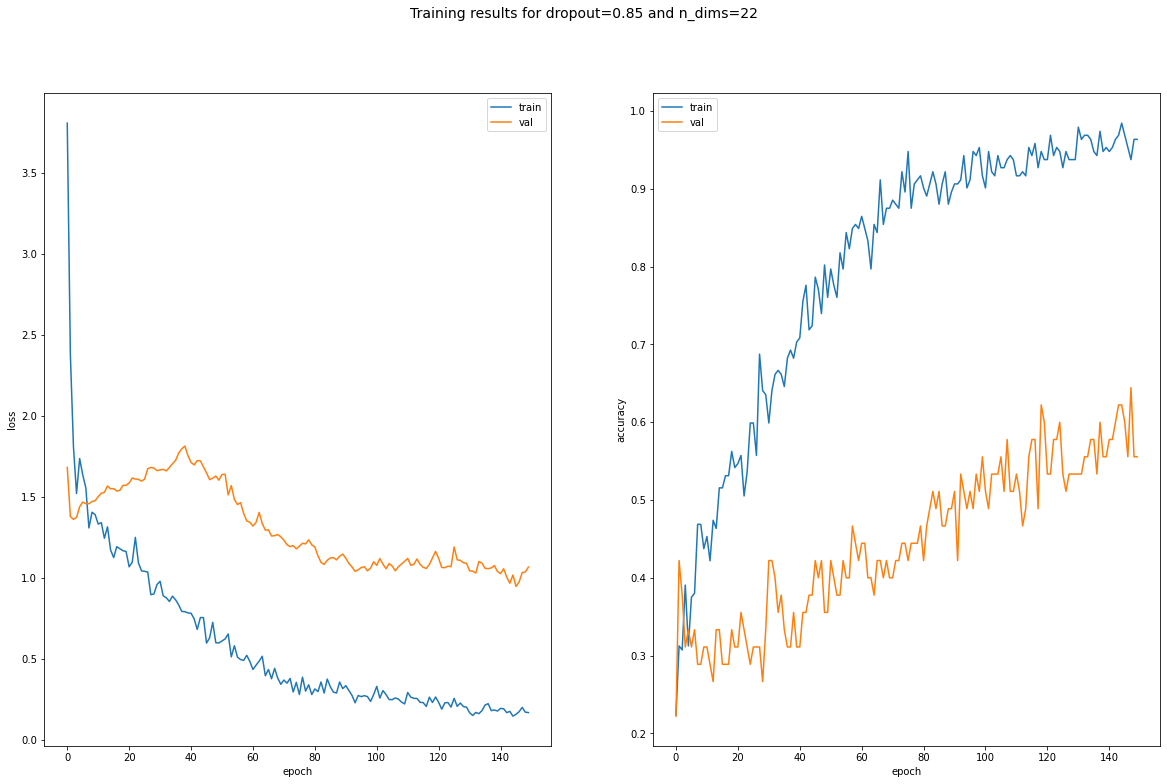

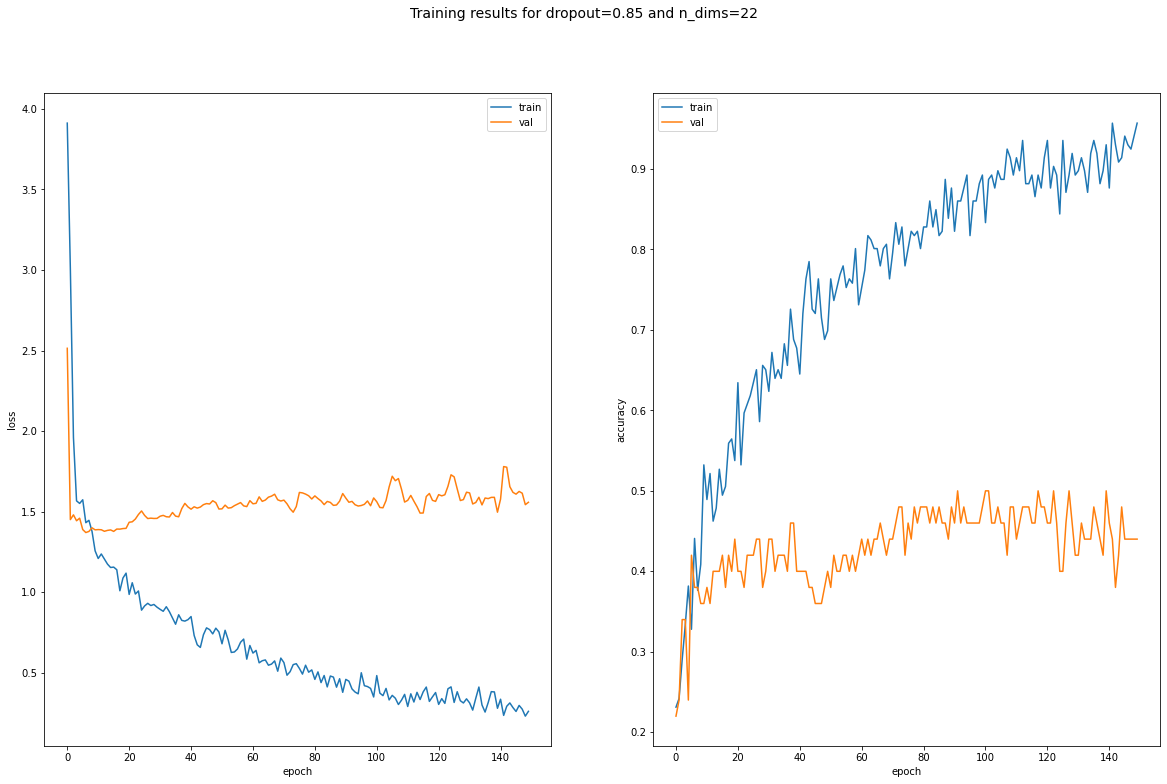

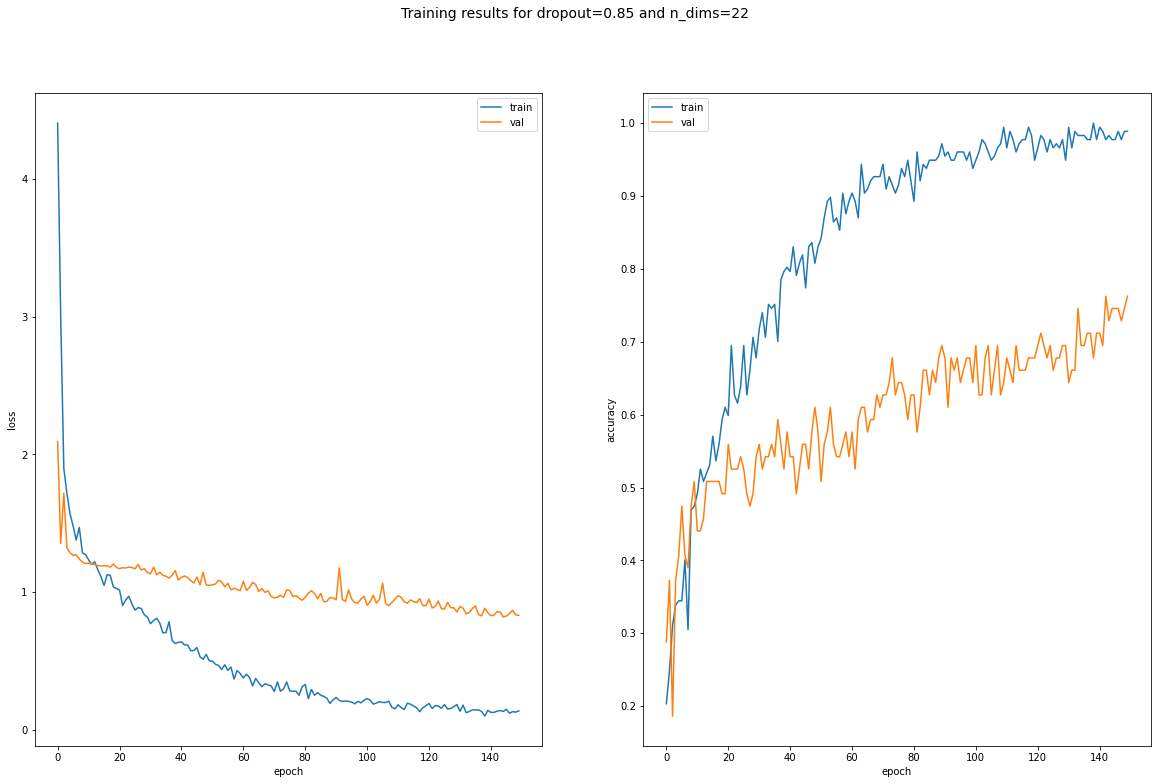

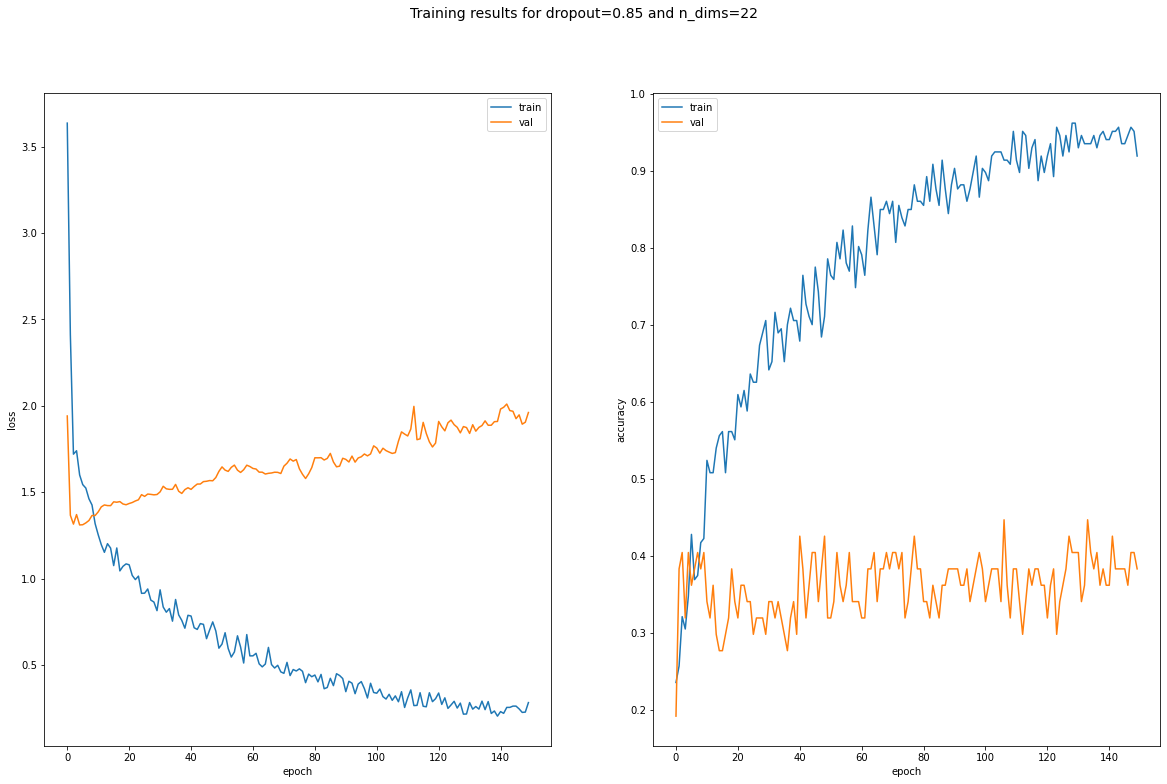

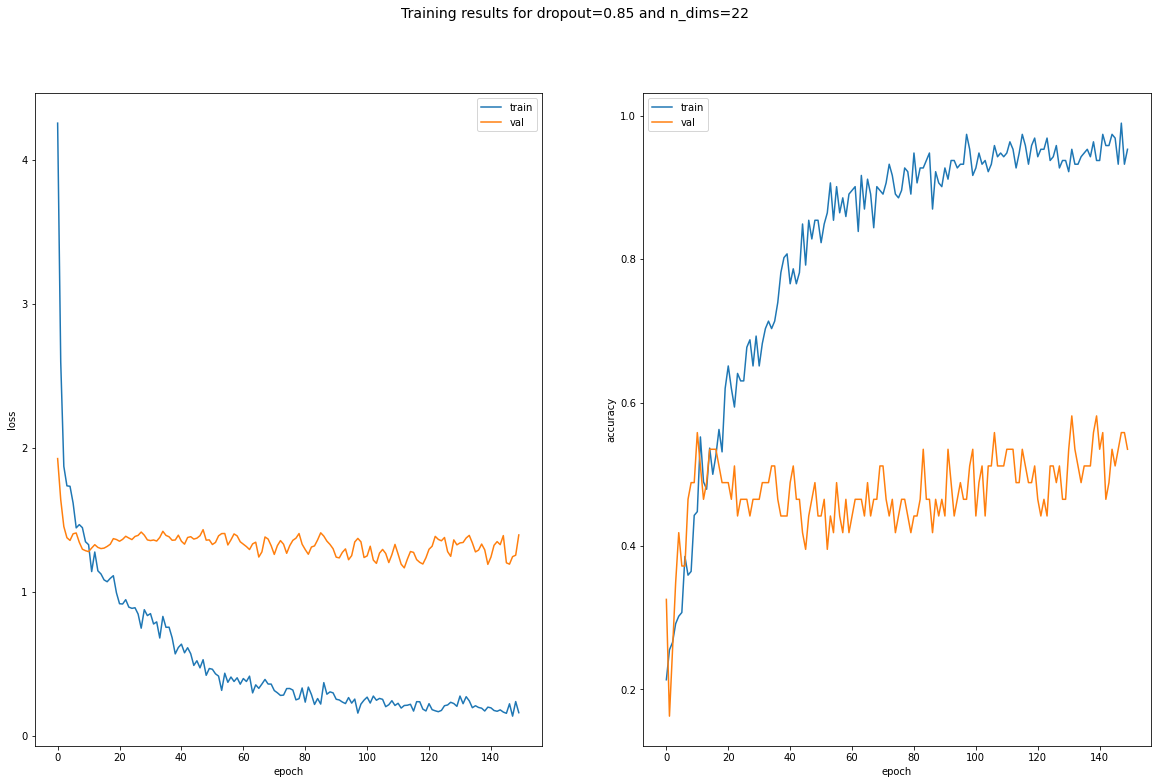

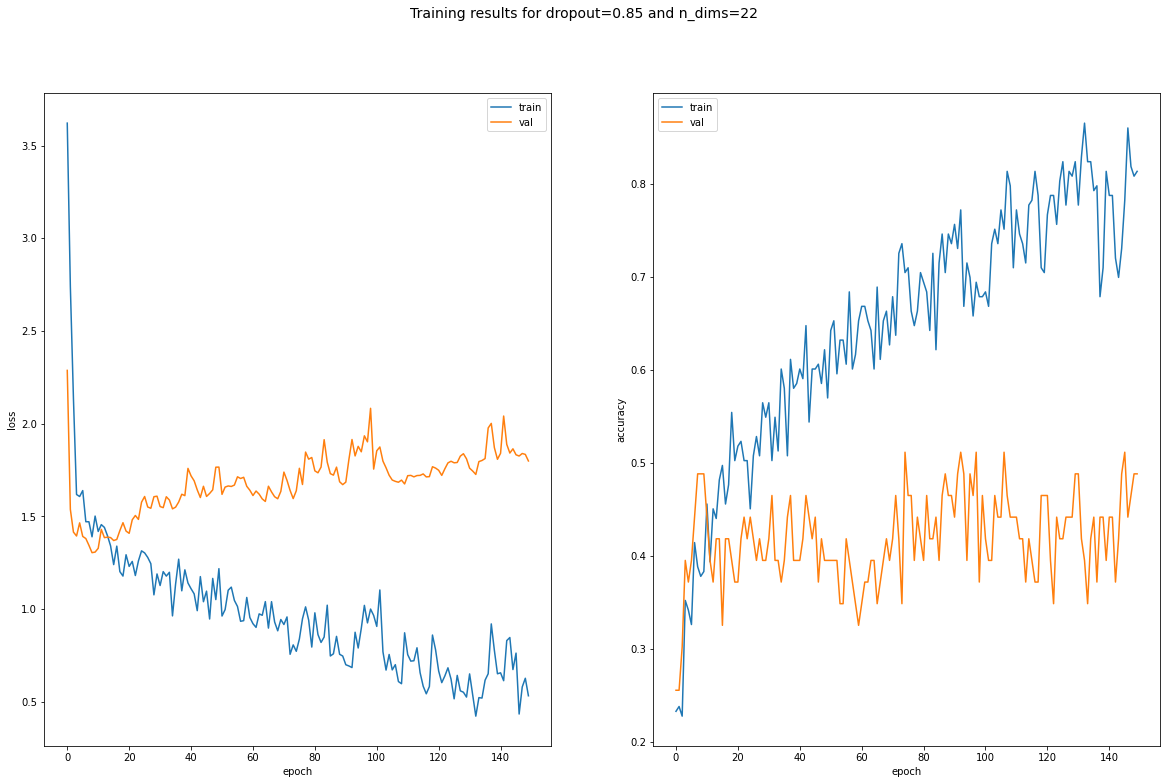

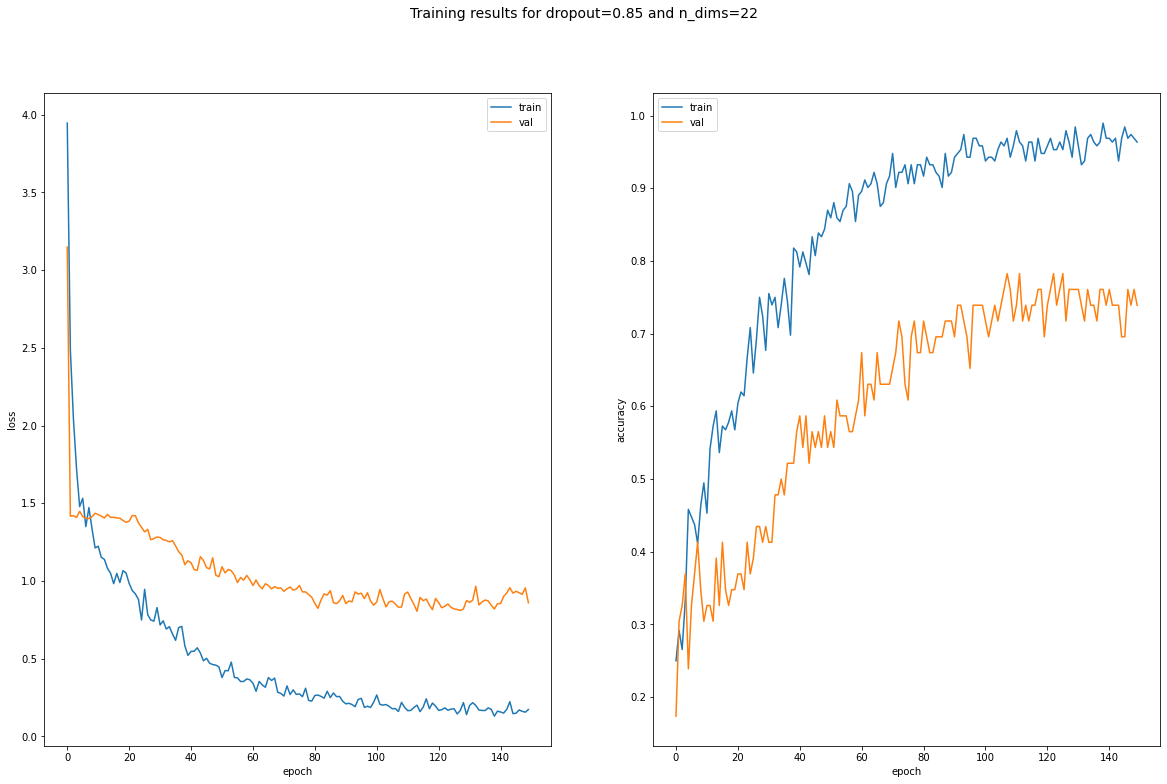

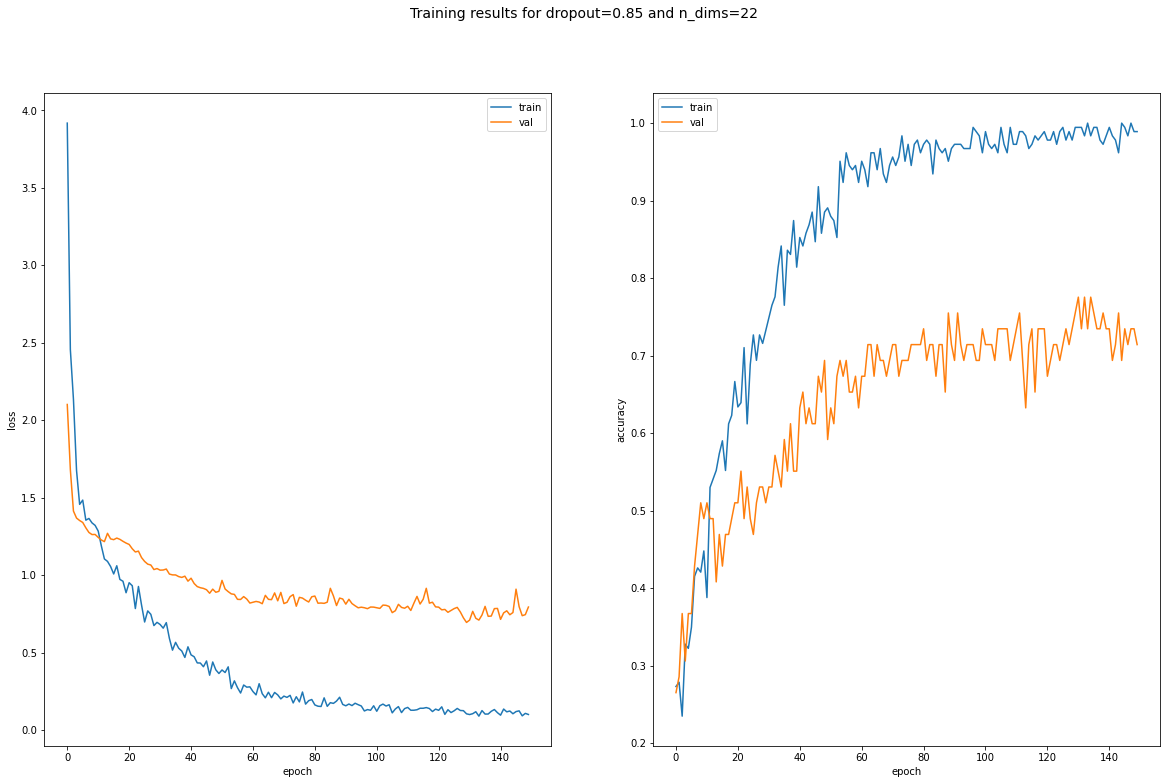

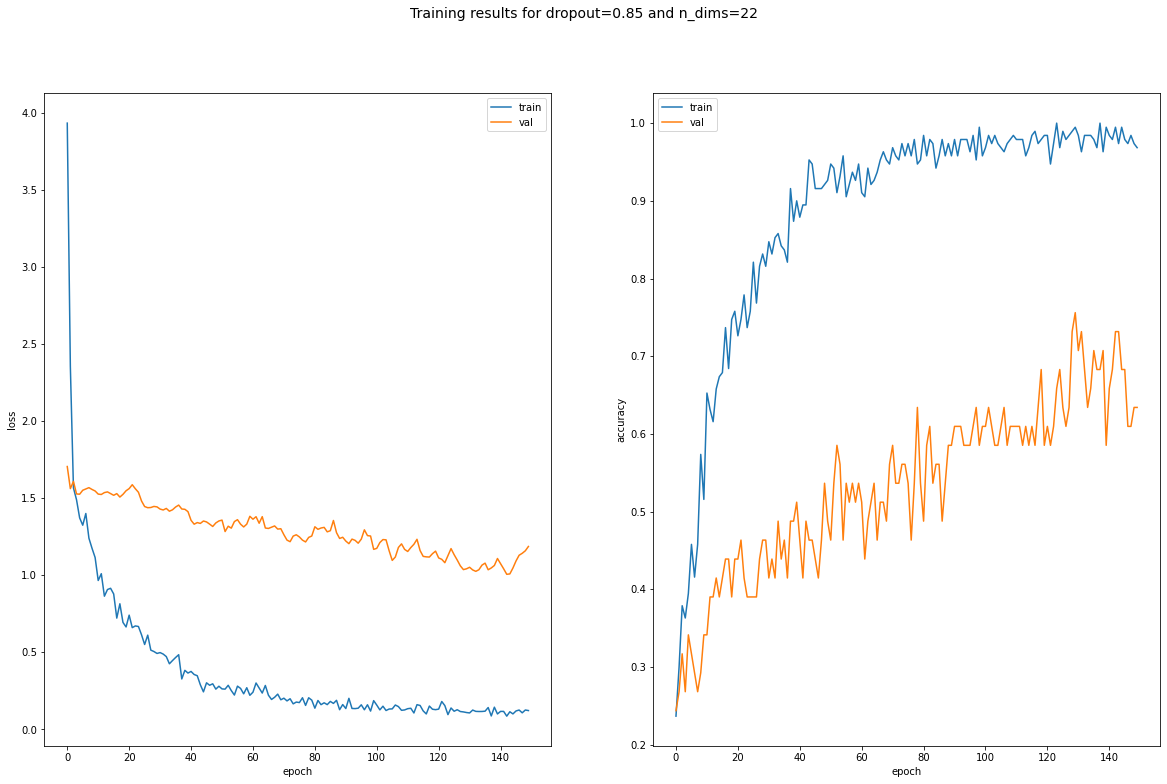

In [118]:
#Now let's train a model on the normalized data without crop for all subjects

drp = 0.85
n_comp=22

subject_test_accs_nocrop = []
subject_test_accuracies_best_val_nocrop = []

for subject_ix in range(9):
    
    print("Trianing model for subject #{}".format(subject_ix))
    
    subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
    subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
    subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

    s_X_train = X_train_norm[subject_indices_train]
    s_X_valid = X_valid_norm[subject_indices_valid]
    s_X_test = X_test_norm[subject_indices_test]

    s_y_train = y_train_1h[subject_indices_train]
    s_y_valid = y_valid_1h[subject_indices_valid]
    s_y_test = y_test_1h[subject_indices_test]

    
    model = get_model(n_timesteps=1000, drp=0.85, n_comp=22)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                         save_best_only=True, monitor='val_loss', mode='min')
    
    loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                          validation_data=(s_X_valid, s_y_valid),
                          callbacks=[mcp_save], 
                          verbose=True)
    
    plot_train_hist(loss_hist,drp,n_comp,subject_ix)
    
    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate final step on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("final test loss, test acc:", results)
    subject_test_accs_nocrop.append(results[1])
    
    model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate best val acc model on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("best val loss model test loss, test acc:", results)

    subject_test_accuracies_best_val_nocrop.append(results[1])

In [130]:
print(subject_test_accs_nocrop)
print(subject_test_accuracies_best_val_nocrop)

subj_acc_means_nocrop_norm = (np.array(subject_test_accs_nocrop) + np.array(subject_test_accuracies_best_val_nocrop))/2

[0.5799999833106995, 0.4399999976158142, 0.7599999904632568, 0.41999998688697815, 0.5744680762290955, 0.3265306055545807, 0.6000000238418579, 0.7200000286102295, 0.5744680762290955]
[0.6000000238418579, 0.2199999988079071, 0.7200000286102295, 0.25999999046325684, 0.5957446694374084, 0.36734694242477417, 0.6200000047683716, 0.6600000262260437, 0.5957446694374084]


Trianing model for subject #0
Epoch 1/150
6/6 [==============================] - 0s 28ms/step - loss: 2.0147 - acc: 0.2031 - val_loss: 1.3885 - val_acc: 0.2444
Epoch 2/150
6/6 [==============================] - 0s 15ms/step - loss: 1.5574 - acc: 0.3125 - val_loss: 1.3339 - val_acc: 0.2889
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 1.4508 - acc: 0.3698 - val_loss: 1.3271 - val_acc: 0.2889
Epoch 4/150
6/6 [==============================] - 1s 244ms/step - loss: 1.3814 - acc: 0.3854 - val_loss: 1.2668 - val_acc: 0.4667
Epoch 5/150
6/6 [==============================] - 0s 14ms/step - loss: 1.2055 - acc: 0.4531 - val_loss: 1.1946 - val_acc: 0.4222
Epoch 6/150
6/6 [==============================] - 0s 14ms/step - loss: 1.1551 - acc: 0.4896 - val_loss: 1.1028 - val_acc: 0.6000
Epoch 7/150
6/6 [==============================] - 0s 14ms/step - loss: 1.0567 - acc: 0.5781 - val_loss: 1.0552 - val_acc: 0.4667
Epoch 8/150
6/6 [==============================] - 0s 14ms/

6/6 [==============================] - 0s 13ms/step - loss: 0.1279 - acc: 0.9740 - val_loss: 0.7212 - val_acc: 0.7111
Epoch 64/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1569 - acc: 0.9583 - val_loss: 0.8015 - val_acc: 0.6222
Epoch 65/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1563 - acc: 0.9583 - val_loss: 0.7495 - val_acc: 0.6444
Epoch 66/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1152 - acc: 1.0000 - val_loss: 0.8378 - val_acc: 0.5778
Epoch 67/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1258 - acc: 0.9792 - val_loss: 0.7449 - val_acc: 0.6667
Epoch 68/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1285 - acc: 0.9844 - val_loss: 0.7183 - val_acc: 0.6222
Epoch 69/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1159 - acc: 0.9844 - val_loss: 0.8817 - val_acc: 0.6222
Epoch 70/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1442 - acc: 0.9740 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.0802 - acc: 1.0000 - val_loss: 0.7996 - val_acc: 0.6667
Epoch 126/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0728 - acc: 1.0000 - val_loss: 0.8055 - val_acc: 0.6000
Epoch 127/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0949 - acc: 0.9844 - val_loss: 0.8266 - val_acc: 0.6222
Epoch 128/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0970 - acc: 0.9844 - val_loss: 0.9005 - val_acc: 0.5778
Epoch 129/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0796 - acc: 1.0000 - val_loss: 0.8875 - val_acc: 0.6000
Epoch 130/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0969 - acc: 0.9948 - val_loss: 0.9047 - val_acc: 0.6222
Epoch 131/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0860 - acc: 0.9948 - val_loss: 0.8256 - val_acc: 0.6444
Epoch 132/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0968 - acc: 0.

Epoch 35/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4031 - acc: 0.8978 - val_loss: 1.3968 - val_acc: 0.3400
Epoch 36/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4454 - acc: 0.8710 - val_loss: 1.3468 - val_acc: 0.3800
Epoch 37/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3977 - acc: 0.9194 - val_loss: 1.4631 - val_acc: 0.3600
Epoch 38/150
6/6 [==============================] - 0s 13ms/step - loss: 0.4670 - acc: 0.8387 - val_loss: 1.3667 - val_acc: 0.3800
Epoch 39/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4014 - acc: 0.8817 - val_loss: 1.3710 - val_acc: 0.4000
Epoch 40/150
6/6 [==============================] - 0s 12ms/step - loss: 0.5036 - acc: 0.8280 - val_loss: 1.3989 - val_acc: 0.3400
Epoch 41/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4160 - acc: 0.8978 - val_loss: 1.3403 - val_acc: 0.3600
Epoch 42/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3975 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.1705 - acc: 0.9731 - val_loss: 1.3591 - val_acc: 0.4600
Epoch 98/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1675 - acc: 0.9731 - val_loss: 1.4847 - val_acc: 0.4800
Epoch 99/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2046 - acc: 0.9570 - val_loss: 1.3531 - val_acc: 0.4400
Epoch 100/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1589 - acc: 0.9677 - val_loss: 1.3474 - val_acc: 0.4200
Epoch 101/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1719 - acc: 0.9946 - val_loss: 1.4164 - val_acc: 0.5200
Epoch 102/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1518 - acc: 0.9785 - val_loss: 1.3910 - val_acc: 0.4400
Epoch 103/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1920 - acc: 0.9677 - val_loss: 1.3982 - val_acc: 0.4600
Epoch 104/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1685 - acc: 0.96

Epoch 7/150
6/6 [==============================] - 0s 14ms/step - loss: 1.2313 - acc: 0.4802 - val_loss: 1.1938 - val_acc: 0.5424
Epoch 8/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1240 - acc: 0.5254 - val_loss: 1.1958 - val_acc: 0.5593
Epoch 9/150
6/6 [==============================] - 0s 15ms/step - loss: 1.1266 - acc: 0.5706 - val_loss: 1.1385 - val_acc: 0.6441
Epoch 10/150
6/6 [==============================] - 0s 14ms/step - loss: 1.0779 - acc: 0.5593 - val_loss: 1.1263 - val_acc: 0.5763
Epoch 11/150
6/6 [==============================] - 0s 14ms/step - loss: 0.9133 - acc: 0.6836 - val_loss: 1.0786 - val_acc: 0.5424
Epoch 12/150
6/6 [==============================] - 0s 14ms/step - loss: 0.8979 - acc: 0.6441 - val_loss: 1.0655 - val_acc: 0.5763
Epoch 13/150
6/6 [==============================] - 0s 14ms/step - loss: 0.9953 - acc: 0.5989 - val_loss: 1.0230 - val_acc: 0.5763
Epoch 14/150
6/6 [==============================] - 0s 14ms/step - loss: 0.7863 - acc:

6/6 [==============================] - 0s 12ms/step - loss: 0.0985 - acc: 0.9944 - val_loss: 0.5825 - val_acc: 0.8305
Epoch 70/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0929 - acc: 0.9944 - val_loss: 0.5915 - val_acc: 0.8136
Epoch 71/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1000 - acc: 0.9887 - val_loss: 0.6422 - val_acc: 0.7458
Epoch 72/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1063 - acc: 0.9831 - val_loss: 0.5920 - val_acc: 0.8475
Epoch 73/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1176 - acc: 0.9831 - val_loss: 0.6229 - val_acc: 0.7797
Epoch 74/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0936 - acc: 1.0000 - val_loss: 0.6104 - val_acc: 0.7797
Epoch 75/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0922 - acc: 1.0000 - val_loss: 0.5795 - val_acc: 0.8136
Epoch 76/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1024 - acc: 0.9944 - 

6/6 [==============================] - 0s 15ms/step - loss: 0.0926 - acc: 0.9887 - val_loss: 0.5045 - val_acc: 0.7966
Epoch 132/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0744 - acc: 1.0000 - val_loss: 0.5352 - val_acc: 0.8136
Epoch 133/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0828 - acc: 0.9944 - val_loss: 0.5553 - val_acc: 0.8136
Epoch 134/150
6/6 [==============================] - 0s 13ms/step - loss: 0.1000 - acc: 0.9774 - val_loss: 0.5011 - val_acc: 0.8136
Epoch 135/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0951 - acc: 0.9887 - val_loss: 0.5371 - val_acc: 0.8305
Epoch 136/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0878 - acc: 0.9944 - val_loss: 0.5746 - val_acc: 0.8305
Epoch 137/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0840 - acc: 1.0000 - val_loss: 0.5590 - val_acc: 0.7627
Epoch 138/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0894 - acc: 1.

Epoch 41/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3086 - acc: 0.9091 - val_loss: 1.3768 - val_acc: 0.3404
Epoch 42/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2970 - acc: 0.9358 - val_loss: 1.3750 - val_acc: 0.4894
Epoch 43/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3518 - acc: 0.9091 - val_loss: 1.3955 - val_acc: 0.3617
Epoch 44/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2814 - acc: 0.9412 - val_loss: 1.4198 - val_acc: 0.4255
Epoch 45/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2819 - acc: 0.9305 - val_loss: 1.4340 - val_acc: 0.5106
Epoch 46/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2650 - acc: 0.9412 - val_loss: 1.3836 - val_acc: 0.4681
Epoch 47/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2945 - acc: 0.9251 - val_loss: 1.3403 - val_acc: 0.4043
Epoch 48/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2386 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.1511 - acc: 0.9840 - val_loss: 1.4897 - val_acc: 0.4468
Epoch 104/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1392 - acc: 0.9786 - val_loss: 1.5350 - val_acc: 0.4681
Epoch 105/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1259 - acc: 0.9893 - val_loss: 1.6170 - val_acc: 0.4468
Epoch 106/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1217 - acc: 0.9947 - val_loss: 1.6617 - val_acc: 0.3830
Epoch 107/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1311 - acc: 0.9840 - val_loss: 1.7178 - val_acc: 0.4043
Epoch 108/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1258 - acc: 0.9840 - val_loss: 1.6316 - val_acc: 0.5106
Epoch 109/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1507 - acc: 0.9786 - val_loss: 1.5050 - val_acc: 0.3830
Epoch 110/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1383 - acc: 0.

Epoch 13/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7773 - acc: 0.7344 - val_loss: 1.1604 - val_acc: 0.5581
Epoch 14/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7128 - acc: 0.7396 - val_loss: 1.1639 - val_acc: 0.5581
Epoch 15/150
6/6 [==============================] - 0s 14ms/step - loss: 0.6271 - acc: 0.7969 - val_loss: 1.1043 - val_acc: 0.5814
Epoch 16/150
6/6 [==============================] - 0s 11ms/step - loss: 0.6255 - acc: 0.7812 - val_loss: 1.1697 - val_acc: 0.5116
Epoch 17/150
6/6 [==============================] - 0s 11ms/step - loss: 0.6615 - acc: 0.7812 - val_loss: 1.1165 - val_acc: 0.6279
Epoch 18/150
6/6 [==============================] - 0s 11ms/step - loss: 0.6446 - acc: 0.7344 - val_loss: 1.1619 - val_acc: 0.5349
Epoch 19/150
6/6 [==============================] - 0s 11ms/step - loss: 0.5604 - acc: 0.8073 - val_loss: 1.1255 - val_acc: 0.5581
Epoch 20/150
6/6 [==============================] - 0s 13ms/step - loss: 0.5184 - a

6/6 [==============================] - 0s 11ms/step - loss: 0.1459 - acc: 0.9740 - val_loss: 1.0518 - val_acc: 0.6512
Epoch 76/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1477 - acc: 0.9792 - val_loss: 1.0828 - val_acc: 0.6047
Epoch 77/150
6/6 [==============================] - 0s 13ms/step - loss: 0.1748 - acc: 0.9583 - val_loss: 0.9708 - val_acc: 0.6744
Epoch 78/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1833 - acc: 0.9583 - val_loss: 1.0493 - val_acc: 0.6279
Epoch 79/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1922 - acc: 0.9635 - val_loss: 1.1387 - val_acc: 0.6512
Epoch 80/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2055 - acc: 0.9531 - val_loss: 1.0761 - val_acc: 0.6512
Epoch 81/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2123 - acc: 0.9427 - val_loss: 1.0276 - val_acc: 0.6977
Epoch 82/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1770 - acc: 0.9635 - 

6/6 [==============================] - 0s 11ms/step - loss: 0.1568 - acc: 0.9635 - val_loss: 1.1275 - val_acc: 0.6512
Epoch 138/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1173 - acc: 0.9792 - val_loss: 1.0397 - val_acc: 0.6047
Epoch 139/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1571 - acc: 0.9635 - val_loss: 0.9493 - val_acc: 0.6977
Epoch 140/150
6/6 [==============================] - 0s 13ms/step - loss: 0.1257 - acc: 0.9792 - val_loss: 0.8256 - val_acc: 0.7442
Epoch 141/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1370 - acc: 0.9844 - val_loss: 0.9337 - val_acc: 0.6977
Epoch 142/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1470 - acc: 0.9740 - val_loss: 1.0669 - val_acc: 0.7209
Epoch 143/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1487 - acc: 0.9583 - val_loss: 1.0360 - val_acc: 0.6512
Epoch 144/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1957 - acc: 0.

7/7 [==============================] - 0s 11ms/step - loss: 0.7707 - acc: 0.7202 - val_loss: 1.3559 - val_acc: 0.4419
Epoch 48/150
7/7 [==============================] - 0s 10ms/step - loss: 0.7976 - acc: 0.7202 - val_loss: 1.2719 - val_acc: 0.4884
Epoch 49/150
7/7 [==============================] - 0s 10ms/step - loss: 0.6739 - acc: 0.7513 - val_loss: 1.2839 - val_acc: 0.4884
Epoch 50/150
7/7 [==============================] - 0s 11ms/step - loss: 0.7568 - acc: 0.6891 - val_loss: 1.3088 - val_acc: 0.4651
Epoch 51/150
7/7 [==============================] - 0s 10ms/step - loss: 0.5973 - acc: 0.8083 - val_loss: 1.2843 - val_acc: 0.4884
Epoch 52/150
7/7 [==============================] - 0s 11ms/step - loss: 0.6519 - acc: 0.8083 - val_loss: 1.2296 - val_acc: 0.5349
Epoch 53/150
7/7 [==============================] - 0s 11ms/step - loss: 0.6176 - acc: 0.7824 - val_loss: 1.2328 - val_acc: 0.5349
Epoch 54/150
7/7 [==============================] - 0s 10ms/step - loss: 0.7525 - acc: 0.7150 - 

7/7 [==============================] - 0s 10ms/step - loss: 0.3206 - acc: 0.9482 - val_loss: 1.3142 - val_acc: 0.4651
Epoch 110/150
7/7 [==============================] - 0s 10ms/step - loss: 0.3359 - acc: 0.9067 - val_loss: 1.3369 - val_acc: 0.5116
Epoch 111/150
7/7 [==============================] - 0s 10ms/step - loss: 0.3518 - acc: 0.9275 - val_loss: 1.3413 - val_acc: 0.4884
Epoch 112/150
7/7 [==============================] - 0s 10ms/step - loss: 0.4504 - acc: 0.8705 - val_loss: 1.3118 - val_acc: 0.4419
Epoch 113/150
7/7 [==============================] - 0s 11ms/step - loss: 0.6167 - acc: 0.8135 - val_loss: 1.2825 - val_acc: 0.5581
Epoch 114/150
7/7 [==============================] - 0s 11ms/step - loss: 0.6089 - acc: 0.7979 - val_loss: 1.2707 - val_acc: 0.5814
Epoch 115/150
7/7 [==============================] - 0s 10ms/step - loss: 0.4961 - acc: 0.8601 - val_loss: 1.3421 - val_acc: 0.5349
Epoch 116/150
7/7 [==============================] - 0s 10ms/step - loss: 0.6814 - acc: 0.

Epoch 19/150
6/6 [==============================] - 0s 11ms/step - loss: 0.5080 - acc: 0.8177 - val_loss: 0.9150 - val_acc: 0.6304
Epoch 20/150
6/6 [==============================] - 0s 13ms/step - loss: 0.4190 - acc: 0.8646 - val_loss: 0.8342 - val_acc: 0.7609
Epoch 21/150
6/6 [==============================] - 0s 15ms/step - loss: 0.4593 - acc: 0.8333 - val_loss: 0.8283 - val_acc: 0.7609
Epoch 22/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4301 - acc: 0.8646 - val_loss: 0.8348 - val_acc: 0.7174
Epoch 23/150
6/6 [==============================] - 0s 13ms/step - loss: 0.3568 - acc: 0.9062 - val_loss: 0.8029 - val_acc: 0.7609
Epoch 24/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3215 - acc: 0.9115 - val_loss: 0.9011 - val_acc: 0.7174
Epoch 25/150
6/6 [==============================] - 0s 12ms/step - loss: 0.3355 - acc: 0.9167 - val_loss: 0.8176 - val_acc: 0.7174
Epoch 26/150
6/6 [==============================] - 0s 13ms/step - loss: 0.3417 - a

6/6 [==============================] - 0s 11ms/step - loss: 0.1314 - acc: 0.9792 - val_loss: 0.7583 - val_acc: 0.7826
Epoch 82/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1064 - acc: 0.9948 - val_loss: 0.7080 - val_acc: 0.8261
Epoch 83/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1110 - acc: 0.9896 - val_loss: 0.8356 - val_acc: 0.7391
Epoch 84/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1217 - acc: 0.9896 - val_loss: 0.7350 - val_acc: 0.8043
Epoch 85/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1208 - acc: 0.9948 - val_loss: 0.6860 - val_acc: 0.8478
Epoch 86/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1306 - acc: 0.9792 - val_loss: 0.7604 - val_acc: 0.8261
Epoch 87/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1500 - acc: 0.9635 - val_loss: 0.7916 - val_acc: 0.7826
Epoch 88/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0960 - acc: 1.0000 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.0931 - acc: 0.9948 - val_loss: 0.8979 - val_acc: 0.8043
Epoch 144/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0910 - acc: 0.9896 - val_loss: 0.8260 - val_acc: 0.8261
Epoch 145/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0844 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.8261
Epoch 146/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0845 - acc: 1.0000 - val_loss: 0.7390 - val_acc: 0.8478
Epoch 147/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0837 - acc: 1.0000 - val_loss: 0.8969 - val_acc: 0.7826
Epoch 148/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0895 - acc: 0.9896 - val_loss: 0.7822 - val_acc: 0.8261
Epoch 149/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0763 - acc: 1.0000 - val_loss: 0.8077 - val_acc: 0.7826
Epoch 150/150
2/2 [==============================] - 0s 2ms/step - loss: 0.8713 - acc: 0.7

6/6 [==============================] - 0s 12ms/step - loss: 0.1121 - acc: 0.9836 - val_loss: 0.5410 - val_acc: 0.7755
Epoch 54/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1264 - acc: 0.9836 - val_loss: 0.5740 - val_acc: 0.8367
Epoch 55/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1070 - acc: 0.9945 - val_loss: 0.5941 - val_acc: 0.7755
Epoch 56/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1095 - acc: 0.9891 - val_loss: 0.6063 - val_acc: 0.7551
Epoch 57/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1393 - acc: 0.9891 - val_loss: 0.5570 - val_acc: 0.7551
Epoch 58/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1090 - acc: 0.9891 - val_loss: 0.7353 - val_acc: 0.6939
Epoch 59/150
6/6 [==============================] - 0s 15ms/step - loss: 0.1196 - acc: 0.9891 - val_loss: 0.5071 - val_acc: 0.8367
Epoch 60/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1305 - acc: 0.9672 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.0787 - acc: 0.9945 - val_loss: 0.6148 - val_acc: 0.8367
Epoch 116/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0656 - acc: 0.9945 - val_loss: 0.4909 - val_acc: 0.8367
Epoch 117/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0633 - acc: 1.0000 - val_loss: 0.4940 - val_acc: 0.8367
Epoch 118/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0730 - acc: 0.9945 - val_loss: 0.5970 - val_acc: 0.8571
Epoch 119/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0811 - acc: 0.9945 - val_loss: 0.6199 - val_acc: 0.8163
Epoch 120/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0796 - acc: 0.9945 - val_loss: 0.5505 - val_acc: 0.8163
Epoch 121/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0858 - acc: 0.9836 - val_loss: 0.6472 - val_acc: 0.8367
Epoch 122/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1090 - acc: 0.

Epoch 25/150
6/6 [==============================] - 0s 14ms/step - loss: 0.2130 - acc: 0.9579 - val_loss: 0.7295 - val_acc: 0.7805
Epoch 26/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2117 - acc: 0.9526 - val_loss: 0.8186 - val_acc: 0.7317
Epoch 27/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2282 - acc: 0.9211 - val_loss: 0.7663 - val_acc: 0.7805
Epoch 28/150
6/6 [==============================] - 0s 14ms/step - loss: 0.1666 - acc: 0.9789 - val_loss: 0.7032 - val_acc: 0.8049
Epoch 29/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2035 - acc: 0.9526 - val_loss: 0.8029 - val_acc: 0.7805
Epoch 30/150
6/6 [==============================] - 0s 12ms/step - loss: 0.1937 - acc: 0.9579 - val_loss: 0.7567 - val_acc: 0.7317
Epoch 31/150
6/6 [==============================] - 0s 11ms/step - loss: 0.1763 - acc: 0.9632 - val_loss: 0.7049 - val_acc: 0.8049
Epoch 32/150
6/6 [==============================] - 0s 12ms/step - loss: 0.2141 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.0726 - acc: 0.9947 - val_loss: 0.9694 - val_acc: 0.7805
Epoch 88/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0750 - acc: 0.9947 - val_loss: 0.9452 - val_acc: 0.7317
Epoch 89/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0750 - acc: 1.0000 - val_loss: 0.9992 - val_acc: 0.7317
Epoch 90/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0798 - acc: 0.9947 - val_loss: 0.9741 - val_acc: 0.7805
Epoch 91/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0772 - acc: 1.0000 - val_loss: 0.7399 - val_acc: 0.8293
Epoch 92/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0697 - acc: 0.9947 - val_loss: 0.8543 - val_acc: 0.8049
Epoch 93/150
6/6 [==============================] - 0s 12ms/step - loss: 0.0742 - acc: 0.9947 - val_loss: 0.9633 - val_acc: 0.7561
Epoch 94/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0775 - acc: 0.9947 - 

6/6 [==============================] - 0s 12ms/step - loss: 0.0680 - acc: 1.0000 - val_loss: 0.9528 - val_acc: 0.7561
Epoch 150/150
2/2 [==============================] - 0s 2ms/step - loss: 0.7512 - acc: 0.7234
final test loss, test acc: [0.7511788010597229, 0.7234042286872864]
2/2 [==============================] - 0s 2ms/step - loss: 0.7908 - acc: 0.7234
best val loss model test loss, test acc: [0.7907727956771851, 0.7234042286872864]


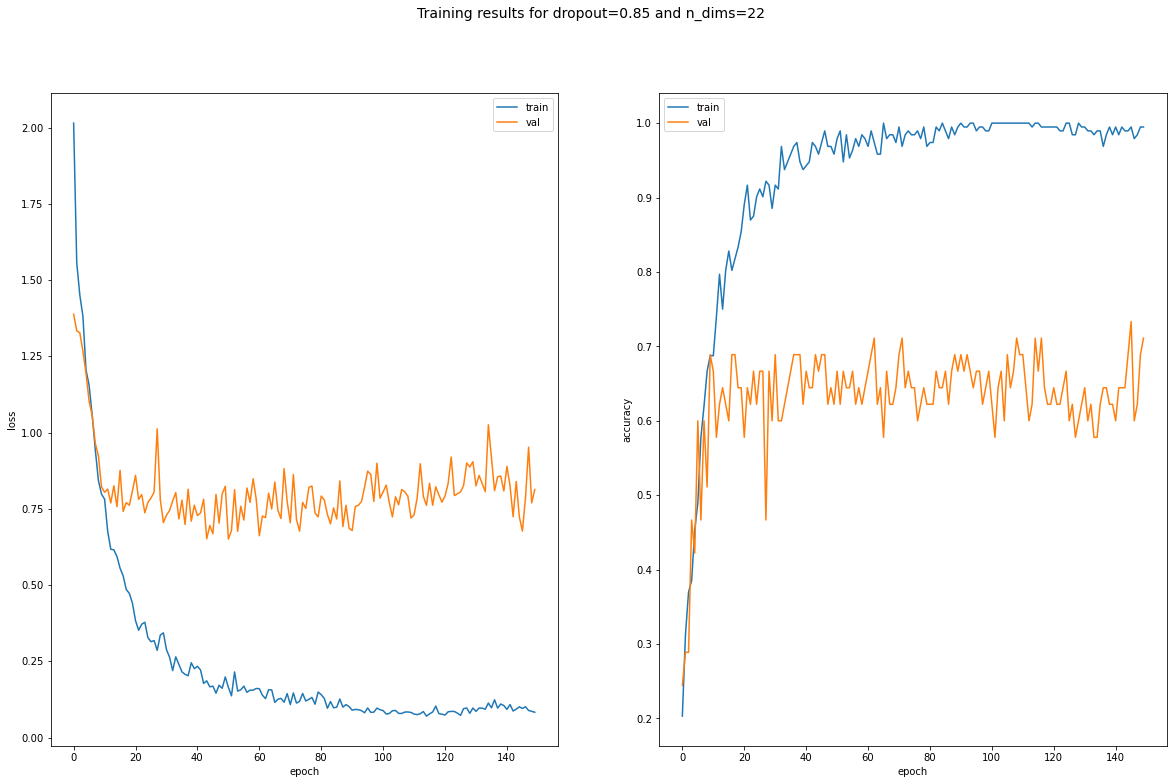

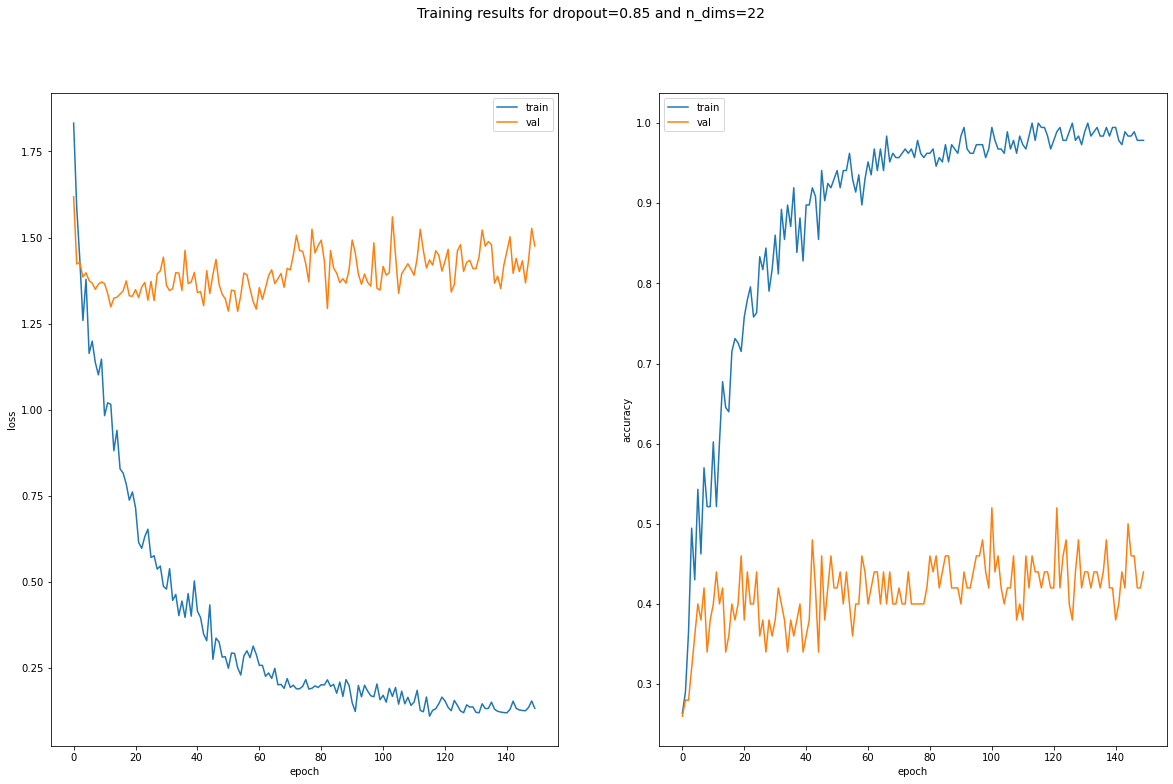

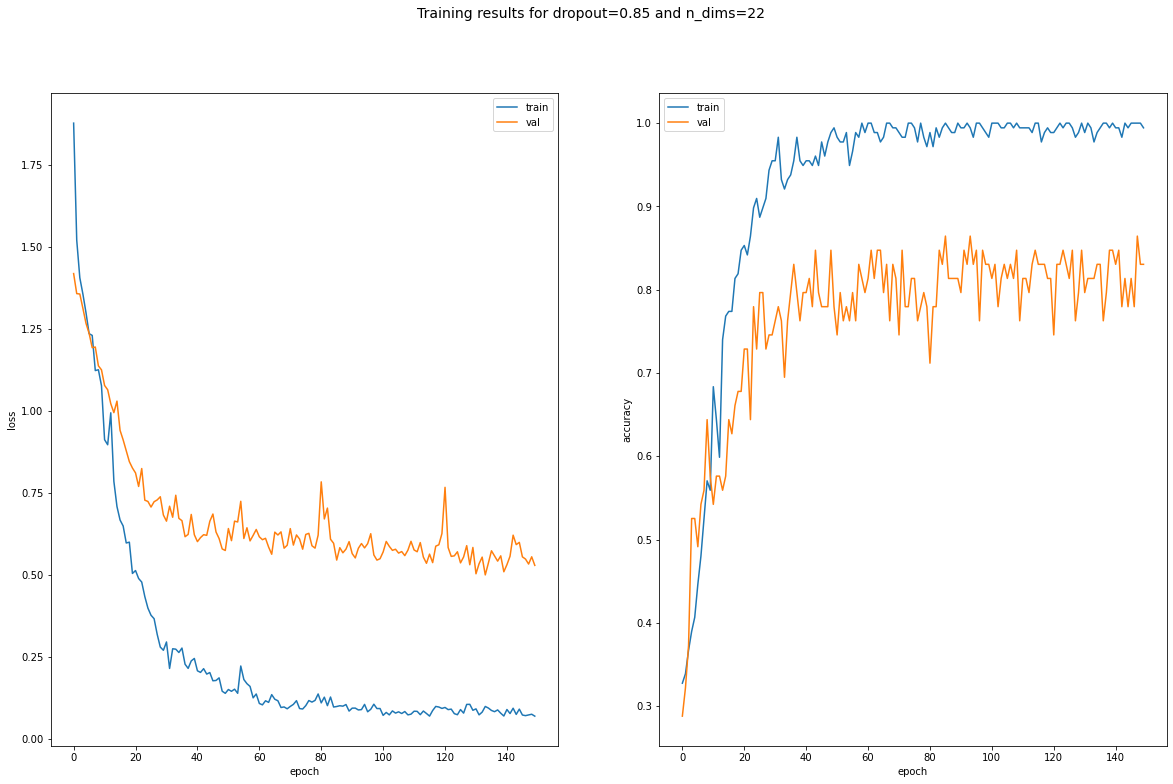

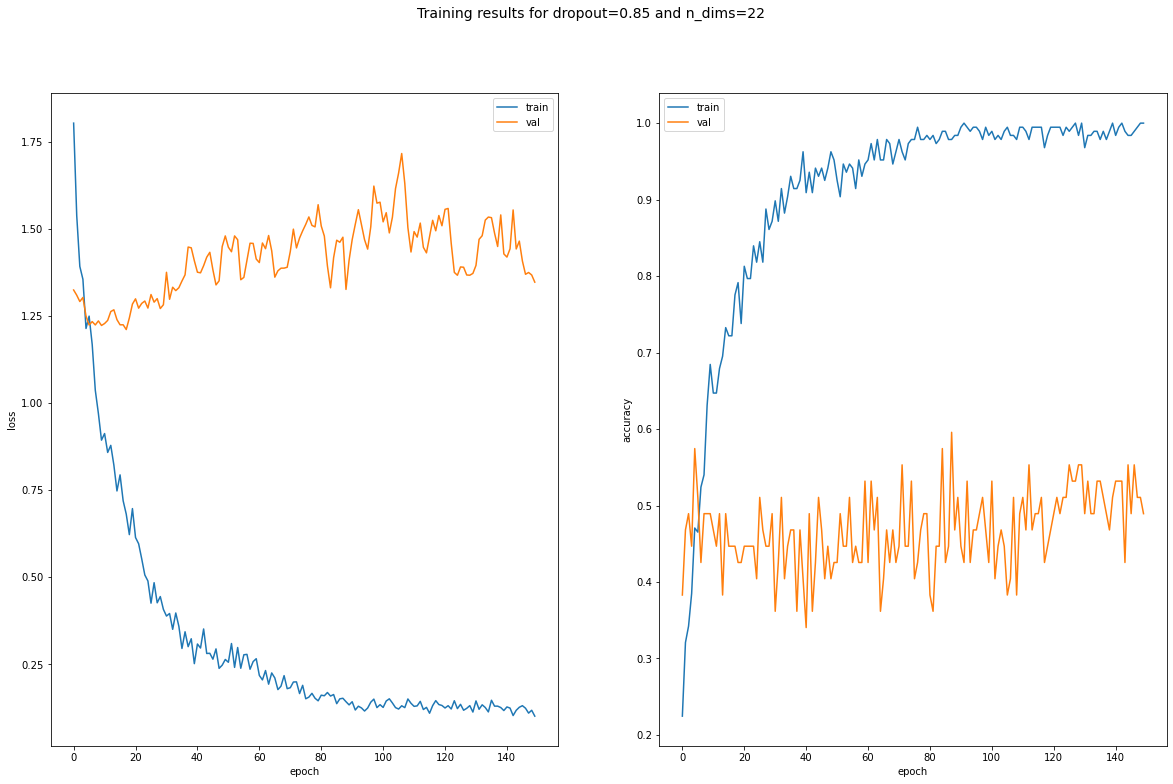

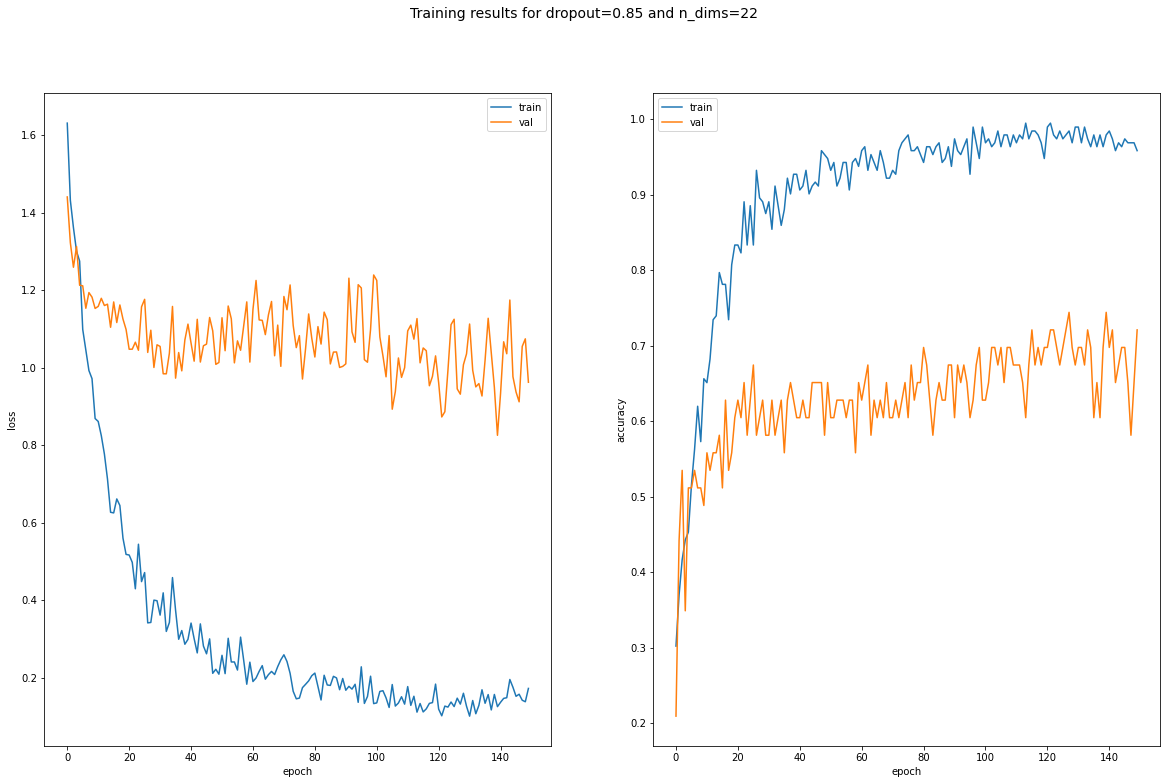

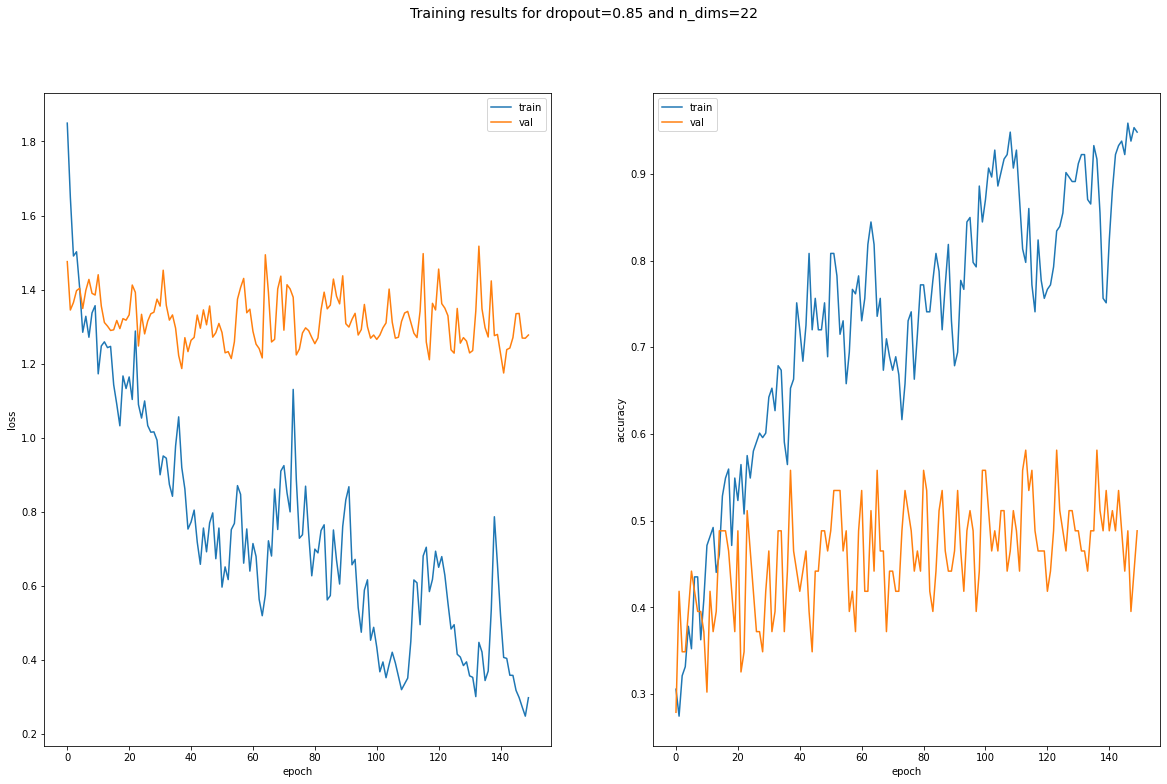

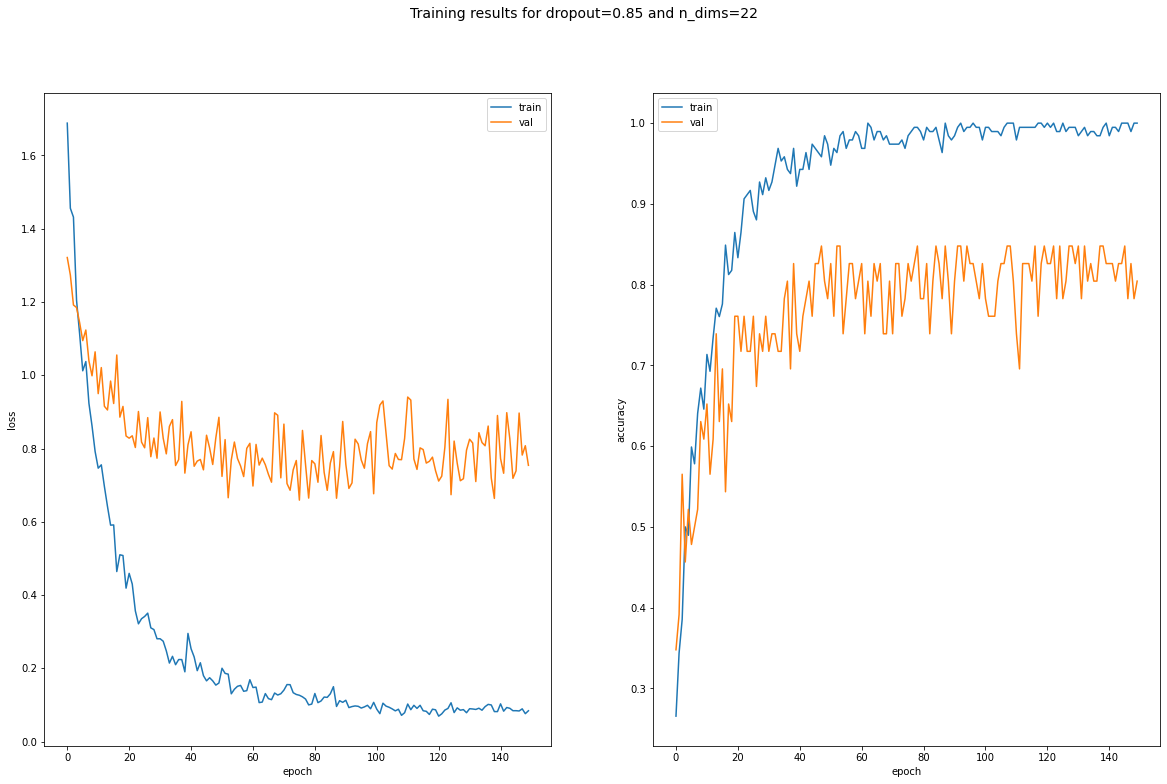

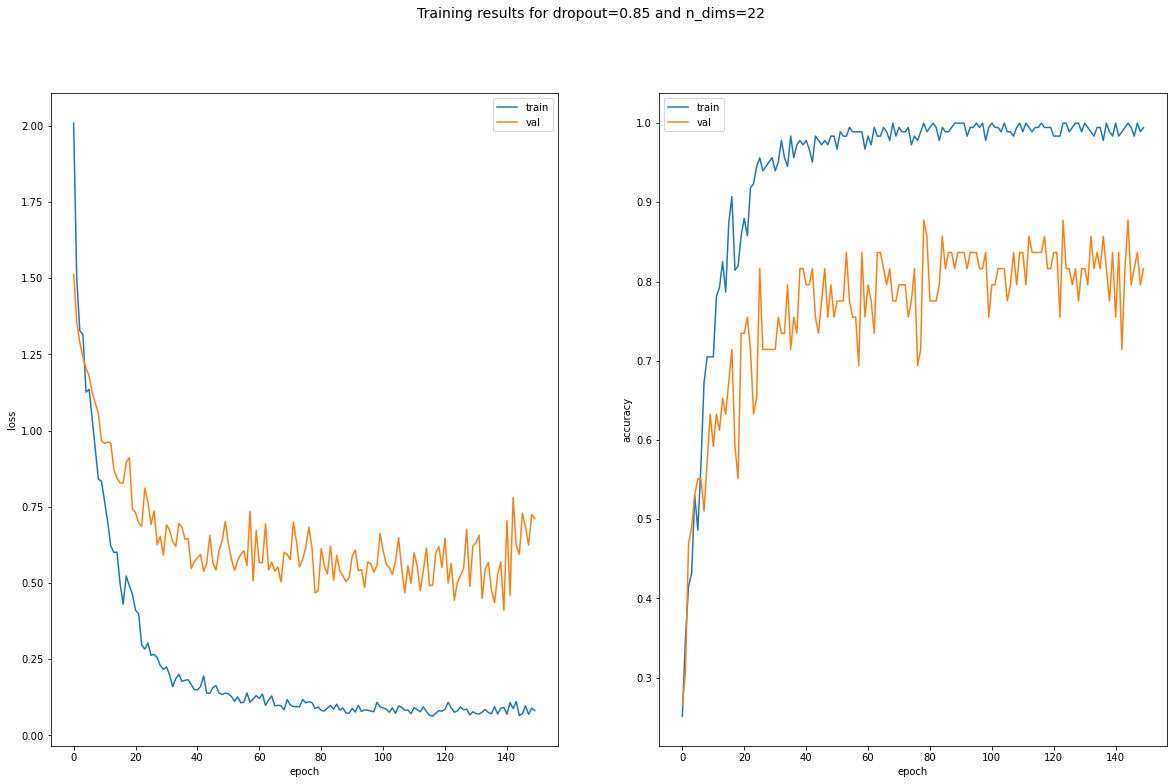

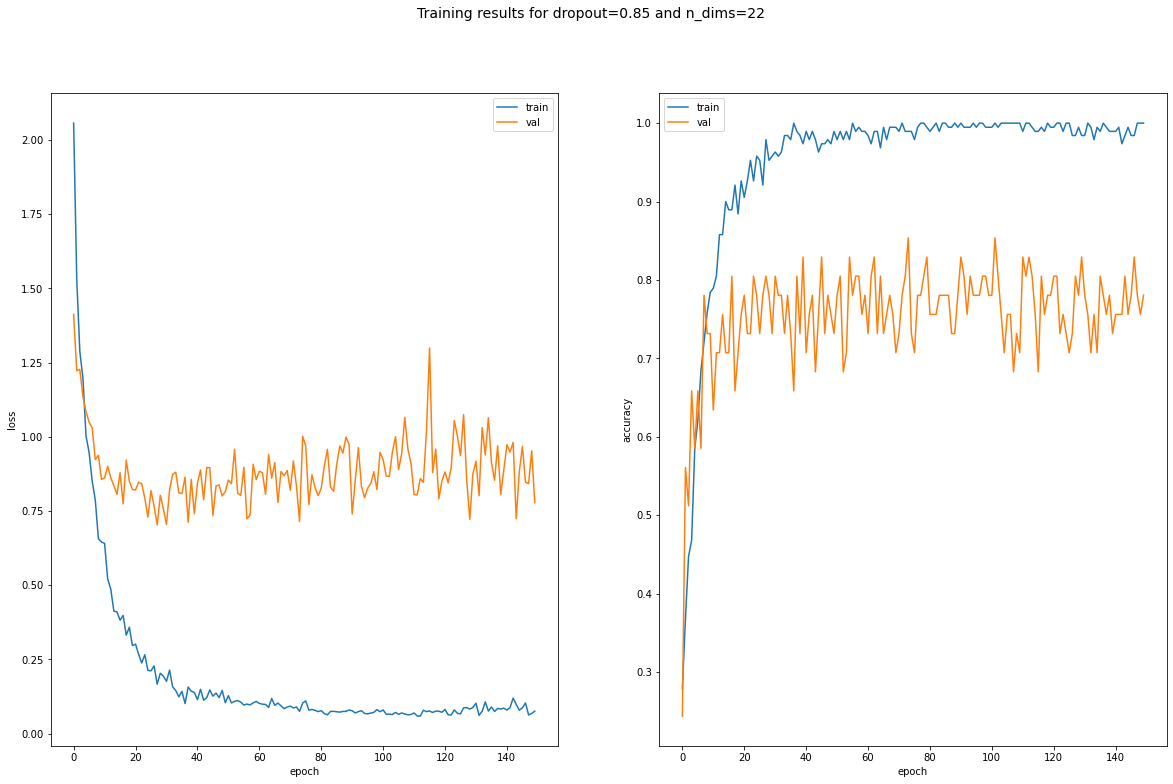

In [126]:
#Now let's train a model on the full-scale data without crop for all subjects

drp = 0.85
n_comp=22

subject_test_accs_full = []
subject_test_accuracies_best_val_full = []

for subject_ix in range(9):
    
    print("Trianing model for subject #{}".format(subject_ix))
    
    subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
    subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
    subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

    s_X_train = X_train[subject_indices_train]
    s_X_valid = X_valid[subject_indices_valid]
    s_X_test = X_test[subject_indices_test]

    s_y_train = y_train_1h[subject_indices_train]
    s_y_valid = y_valid_1h[subject_indices_valid]
    s_y_test = y_test_1h[subject_indices_test]

    
    model = get_model(n_timesteps=1000, drp=0.85, n_comp=22)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                         save_best_only=True, monitor='val_loss', mode='min')
    
    loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                          validation_data=(s_X_valid, s_y_valid),
                          callbacks=[mcp_save], 
                          verbose=True)
    
    plot_train_hist(loss_hist,drp,n_comp,subject_ix)
    
    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate final step on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("final test loss, test acc:", results)
    subject_test_accs_full.append(results[1])
    
    model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate best val acc model on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("best val loss model test loss, test acc:", results)

    subject_test_accuracies_best_val_full.append(results[1])

In [127]:
print(subject_test_accs_full)
print(subject_test_accuracies_best_val_full)

subj_acc_means_nocrop_full = (np.array(subject_test_accs_full) + np.array(subject_test_accuracies_best_val_full))/2

[0.699999988079071, 0.4399999976158142, 0.800000011920929, 0.5400000214576721, 0.6808510422706604, 0.4897959232330322, 0.7400000095367432, 0.7599999904632568, 0.7234042286872864]
[0.6600000262260437, 0.47999998927116394, 0.8199999928474426, 0.41999998688697815, 0.6808510422706604, 0.5102040767669678, 0.7200000286102295, 0.7200000286102295, 0.7234042286872864]


Trianing model for subject #0
Epoch 1/150
6/6 [==============================] - 0s 23ms/step - loss: 1.7196 - acc: 0.2031 - val_loss: 1.3392 - val_acc: 0.3111
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.4795 - acc: 0.2656 - val_loss: 1.2956 - val_acc: 0.4444
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.3605 - acc: 0.3490 - val_loss: 1.2881 - val_acc: 0.4444
Epoch 4/150
6/6 [==============================] - 0s 11ms/step - loss: 1.3072 - acc: 0.3854 - val_loss: 1.2589 - val_acc: 0.4444
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 1.1981 - acc: 0.4896 - val_loss: 1.1981 - val_acc: 0.4667
Epoch 6/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1848 - acc: 0.4688 - val_loss: 1.1322 - val_acc: 0.4889
Epoch 7/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0721 - acc: 0.5208 - val_loss: 1.0529 - val_acc: 0.6222
Epoch 8/150
6/6 [==============================] - 0s 9ms/st

Epoch 64/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1655 - acc: 0.9792 - val_loss: 0.6560 - val_acc: 0.7556
Epoch 65/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1359 - acc: 0.9896 - val_loss: 0.7260 - val_acc: 0.7778
Epoch 66/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1535 - acc: 0.9792 - val_loss: 0.6861 - val_acc: 0.7333
Epoch 67/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1675 - acc: 0.9635 - val_loss: 0.6604 - val_acc: 0.7333
Epoch 68/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1392 - acc: 0.9844 - val_loss: 0.6898 - val_acc: 0.7333
Epoch 69/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1515 - acc: 0.9635 - val_loss: 0.7094 - val_acc: 0.7556
Epoch 70/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1240 - acc: 0.9896 - val_loss: 0.6690 - val_acc: 0.7778
Epoch 71/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1674 - acc: 0.97

Epoch 127/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1111 - acc: 0.9844 - val_loss: 0.8351 - val_acc: 0.7333
Epoch 128/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0914 - acc: 1.0000 - val_loss: 0.8029 - val_acc: 0.7556
Epoch 129/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0955 - acc: 0.9948 - val_loss: 0.8088 - val_acc: 0.7778
Epoch 130/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0811 - acc: 0.9948 - val_loss: 0.7788 - val_acc: 0.7556
Epoch 131/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0928 - acc: 0.9896 - val_loss: 0.7738 - val_acc: 0.7333
Epoch 132/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0870 - acc: 0.9948 - val_loss: 0.7578 - val_acc: 0.7778
Epoch 133/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0897 - acc: 0.9896 - val_loss: 0.7415 - val_acc: 0.7333
Epoch 134/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1047 - a

6/6 [==============================] - 0s 8ms/step - loss: 0.5838 - acc: 0.8333 - val_loss: 1.2502 - val_acc: 0.4600
Epoch 38/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5758 - acc: 0.8387 - val_loss: 1.2437 - val_acc: 0.4600
Epoch 39/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5342 - acc: 0.8548 - val_loss: 1.2426 - val_acc: 0.4800
Epoch 40/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4614 - acc: 0.8925 - val_loss: 1.2192 - val_acc: 0.4800
Epoch 41/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4842 - acc: 0.8548 - val_loss: 1.2117 - val_acc: 0.5200
Epoch 42/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4697 - acc: 0.8871 - val_loss: 1.1914 - val_acc: 0.5600
Epoch 43/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4633 - acc: 0.8387 - val_loss: 1.1921 - val_acc: 0.5600
Epoch 44/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4745 - acc: 0.8602 - val_los

6/6 [==============================] - 0s 9ms/step - loss: 0.1882 - acc: 0.9785 - val_loss: 1.1769 - val_acc: 0.5400
Epoch 101/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1605 - acc: 0.9785 - val_loss: 1.1923 - val_acc: 0.5800
Epoch 102/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1602 - acc: 0.9892 - val_loss: 1.2550 - val_acc: 0.5600
Epoch 103/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1604 - acc: 0.9785 - val_loss: 1.3153 - val_acc: 0.5200
Epoch 104/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1683 - acc: 0.9785 - val_loss: 1.2457 - val_acc: 0.5600
Epoch 105/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1606 - acc: 0.9839 - val_loss: 1.1302 - val_acc: 0.5600
Epoch 106/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1446 - acc: 1.0000 - val_loss: 1.1348 - val_acc: 0.5600
Epoch 107/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1671 - acc: 0.9731 - v

6/6 [==============================] - 0s 11ms/step - loss: 0.9338 - acc: 0.6893 - val_loss: 1.0710 - val_acc: 0.5932
Epoch 11/150
6/6 [==============================] - 0s 10ms/step - loss: 0.8768 - acc: 0.6780 - val_loss: 1.0506 - val_acc: 0.6271
Epoch 12/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7938 - acc: 0.7627 - val_loss: 1.0278 - val_acc: 0.5593
Epoch 13/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7694 - acc: 0.7458 - val_loss: 0.9779 - val_acc: 0.6441
Epoch 14/150
6/6 [==============================] - 0s 10ms/step - loss: 0.7244 - acc: 0.7684 - val_loss: 0.9319 - val_acc: 0.7119
Epoch 15/150
6/6 [==============================] - 0s 10ms/step - loss: 0.7183 - acc: 0.7627 - val_loss: 0.9199 - val_acc: 0.6780
Epoch 16/150
6/6 [==============================] - 0s 10ms/step - loss: 0.6403 - acc: 0.8079 - val_loss: 0.9075 - val_acc: 0.6949
Epoch 17/150
6/6 [==============================] - 0s 11ms/step - loss: 0.6830 - acc: 0.7514 - 

Epoch 73/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1351 - acc: 0.9831 - val_loss: 0.5974 - val_acc: 0.7797
Epoch 74/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1135 - acc: 0.9944 - val_loss: 0.5654 - val_acc: 0.7797
Epoch 75/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1118 - acc: 0.9887 - val_loss: 0.6695 - val_acc: 0.7797
Epoch 76/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1389 - acc: 0.9831 - val_loss: 0.5609 - val_acc: 0.8305
Epoch 77/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1081 - acc: 0.9831 - val_loss: 0.6160 - val_acc: 0.8136
Epoch 78/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1075 - acc: 0.9718 - val_loss: 0.5549 - val_acc: 0.8475
Epoch 79/150
6/6 [==============================] - 0s 10ms/step - loss: 0.0957 - acc: 0.9887 - val_loss: 0.5424 - val_acc: 0.8136
Epoch 80/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1010 - acc: 0.9

Epoch 136/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0817 - acc: 0.9887 - val_loss: 0.4986 - val_acc: 0.8644
Epoch 137/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0816 - acc: 0.9887 - val_loss: 0.5345 - val_acc: 0.7966
Epoch 138/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0734 - acc: 1.0000 - val_loss: 0.5791 - val_acc: 0.8136
Epoch 139/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0669 - acc: 1.0000 - val_loss: 0.5185 - val_acc: 0.8136
Epoch 140/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0847 - acc: 0.9944 - val_loss: 0.5280 - val_acc: 0.8305
Epoch 141/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0804 - acc: 0.9944 - val_loss: 0.4883 - val_acc: 0.8475
Epoch 142/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0786 - acc: 0.9887 - val_loss: 0.4791 - val_acc: 0.8136
Epoch 143/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0644 - a

6/6 [==============================] - 0s 8ms/step - loss: 0.3680 - acc: 0.8984 - val_loss: 1.1075 - val_acc: 0.5745
Epoch 47/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3637 - acc: 0.9251 - val_loss: 1.1230 - val_acc: 0.5319
Epoch 48/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3224 - acc: 0.9144 - val_loss: 1.1369 - val_acc: 0.5106
Epoch 49/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3521 - acc: 0.8877 - val_loss: 1.1268 - val_acc: 0.4894
Epoch 50/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2935 - acc: 0.9305 - val_loss: 1.1074 - val_acc: 0.5532
Epoch 51/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3147 - acc: 0.9305 - val_loss: 1.1795 - val_acc: 0.5106
Epoch 52/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3371 - acc: 0.9037 - val_loss: 1.1267 - val_acc: 0.5319
Epoch 53/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2977 - acc: 0.9412 - val_loss

6/6 [==============================] - 0s 9ms/step - loss: 0.1544 - acc: 0.9733 - val_loss: 1.1739 - val_acc: 0.5745
Epoch 110/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1415 - acc: 0.9893 - val_loss: 1.1353 - val_acc: 0.5957
Epoch 111/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1718 - acc: 0.9572 - val_loss: 1.1421 - val_acc: 0.5957
Epoch 112/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1508 - acc: 0.9840 - val_loss: 1.1626 - val_acc: 0.5532
Epoch 113/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1642 - acc: 0.9893 - val_loss: 1.1341 - val_acc: 0.5106
Epoch 114/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1561 - acc: 0.9840 - val_loss: 1.1118 - val_acc: 0.5745
Epoch 115/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1457 - acc: 0.9786 - val_loss: 1.0724 - val_acc: 0.6383
Epoch 116/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1651 - acc: 0.9679 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.6894 - acc: 0.7552 - val_loss: 0.9608 - val_acc: 0.5814
Epoch 20/150
6/6 [==============================] - 0s 9ms/step - loss: 0.6887 - acc: 0.7396 - val_loss: 0.9368 - val_acc: 0.6279
Epoch 21/150
6/6 [==============================] - 0s 7ms/step - loss: 0.5556 - acc: 0.8281 - val_loss: 0.9375 - val_acc: 0.6512
Epoch 22/150
6/6 [==============================] - 0s 8ms/step - loss: 0.6511 - acc: 0.7656 - val_loss: 0.9848 - val_acc: 0.5116
Epoch 23/150
6/6 [==============================] - 0s 7ms/step - loss: 0.6162 - acc: 0.7552 - val_loss: 0.9414 - val_acc: 0.5814
Epoch 24/150
6/6 [==============================] - 0s 9ms/step - loss: 0.6175 - acc: 0.7656 - val_loss: 0.8893 - val_acc: 0.6744
Epoch 25/150
6/6 [==============================] - 0s 7ms/step - loss: 0.5001 - acc: 0.8594 - val_loss: 0.9872 - val_acc: 0.5116
Epoch 26/150
6/6 [==============================] - 0s 7ms/step - loss: 0.5056 - acc: 0.8438 - val_loss

6/6 [==============================] - 0s 7ms/step - loss: 0.1932 - acc: 0.9479 - val_loss: 0.8998 - val_acc: 0.6047
Epoch 83/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1836 - acc: 0.9635 - val_loss: 0.9295 - val_acc: 0.5814
Epoch 84/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2477 - acc: 0.9167 - val_loss: 0.8926 - val_acc: 0.6279
Epoch 85/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2098 - acc: 0.9375 - val_loss: 0.8320 - val_acc: 0.6279
Epoch 86/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2270 - acc: 0.9479 - val_loss: 0.9604 - val_acc: 0.6279
Epoch 87/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1869 - acc: 0.9531 - val_loss: 0.9673 - val_acc: 0.6512
Epoch 88/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2162 - acc: 0.9323 - val_loss: 0.9071 - val_acc: 0.6512
Epoch 89/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1943 - acc: 0.9375 - val_loss

Epoch 145/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1151 - acc: 0.9896 - val_loss: 1.0643 - val_acc: 0.6047
Epoch 146/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1864 - acc: 0.9427 - val_loss: 1.1335 - val_acc: 0.6047
Epoch 147/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1247 - acc: 0.9792 - val_loss: 1.0264 - val_acc: 0.6279
Epoch 148/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1221 - acc: 0.9844 - val_loss: 1.1295 - val_acc: 0.6512
Epoch 149/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1246 - acc: 0.9844 - val_loss: 0.8995 - val_acc: 0.7209
Epoch 150/150
2/2 [==============================] - 0s 1ms/step - loss: 1.0053 - acc: 0.7660
final test loss, test acc: [1.0052626132965088, 0.7659574747085571]
2/2 [==============================] - 0s 1ms/step - loss: 0.9764 - acc: 0.7234
best val loss model test loss, test acc: [0.976357638835907, 0.7234042286872864]
Trianing model for sub

7/7 [==============================] - 0s 9ms/step - loss: 0.9429 - acc: 0.6114 - val_loss: 1.1559 - val_acc: 0.4651
Epoch 56/150
7/7 [==============================] - 0s 9ms/step - loss: 0.9655 - acc: 0.6010 - val_loss: 1.1260 - val_acc: 0.5116
Epoch 57/150
7/7 [==============================] - 0s 9ms/step - loss: 0.9443 - acc: 0.6580 - val_loss: 1.0978 - val_acc: 0.4884
Epoch 58/150
7/7 [==============================] - 0s 7ms/step - loss: 0.9896 - acc: 0.5751 - val_loss: 1.1339 - val_acc: 0.4651
Epoch 59/150
7/7 [==============================] - 0s 7ms/step - loss: 0.9148 - acc: 0.6632 - val_loss: 1.1178 - val_acc: 0.5581
Epoch 60/150
7/7 [==============================] - 0s 7ms/step - loss: 0.8164 - acc: 0.7254 - val_loss: 1.1753 - val_acc: 0.4651
Epoch 61/150
7/7 [==============================] - 0s 7ms/step - loss: 0.7936 - acc: 0.7150 - val_loss: 1.1619 - val_acc: 0.5814
Epoch 62/150
7/7 [==============================] - 0s 7ms/step - loss: 0.9283 - acc: 0.6010 - val_loss

Epoch 118/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5783 - acc: 0.8290 - val_loss: 1.1569 - val_acc: 0.5814
Epoch 119/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5318 - acc: 0.8031 - val_loss: 1.1516 - val_acc: 0.5814
Epoch 120/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5470 - acc: 0.8394 - val_loss: 1.1847 - val_acc: 0.4651
Epoch 121/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5152 - acc: 0.8187 - val_loss: 1.1479 - val_acc: 0.5349
Epoch 122/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5245 - acc: 0.8342 - val_loss: 1.1964 - val_acc: 0.5116
Epoch 123/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5693 - acc: 0.7876 - val_loss: 1.2618 - val_acc: 0.5116
Epoch 124/150
7/7 [==============================] - 0s 8ms/step - loss: 0.4923 - acc: 0.8497 - val_loss: 1.1589 - val_acc: 0.6047
Epoch 125/150
7/7 [==============================] - 0s 7ms/step - loss: 0.5081 - a

6/6 [==============================] - 0s 7ms/step - loss: 0.4548 - acc: 0.8594 - val_loss: 0.7681 - val_acc: 0.7609
Epoch 29/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4751 - acc: 0.8542 - val_loss: 0.7971 - val_acc: 0.6739
Epoch 30/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4284 - acc: 0.8802 - val_loss: 0.7352 - val_acc: 0.7174
Epoch 31/150
6/6 [==============================] - 0s 9ms/step - loss: 0.4056 - acc: 0.8750 - val_loss: 0.6993 - val_acc: 0.7174
Epoch 32/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3807 - acc: 0.8906 - val_loss: 0.6826 - val_acc: 0.7609
Epoch 33/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3842 - acc: 0.8698 - val_loss: 0.7545 - val_acc: 0.6522
Epoch 34/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4018 - acc: 0.8906 - val_loss: 0.7027 - val_acc: 0.7609
Epoch 35/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3657 - acc: 0.9115 - val_loss

6/6 [==============================] - 0s 7ms/step - loss: 0.1133 - acc: 0.9844 - val_loss: 0.6590 - val_acc: 0.7391
Epoch 92/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1200 - acc: 0.9740 - val_loss: 0.6840 - val_acc: 0.7609
Epoch 93/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1022 - acc: 0.9844 - val_loss: 0.6768 - val_acc: 0.7174
Epoch 94/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1040 - acc: 0.9948 - val_loss: 0.6686 - val_acc: 0.7391
Epoch 95/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1262 - acc: 0.9896 - val_loss: 0.6755 - val_acc: 0.7174
Epoch 96/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1232 - acc: 0.9844 - val_loss: 0.6593 - val_acc: 0.7609
Epoch 97/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1112 - acc: 0.9948 - val_loss: 0.6891 - val_acc: 0.7391
Epoch 98/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1181 - acc: 0.9896 - val_loss

6/6 [==============================] - 0s 24ms/step - loss: 1.7835 - acc: 0.1749 - val_loss: 1.3783 - val_acc: 0.3469
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.4170 - acc: 0.3497 - val_loss: 1.3112 - val_acc: 0.4286
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.3689 - acc: 0.3443 - val_loss: 1.2877 - val_acc: 0.4286
Epoch 4/150
6/6 [==============================] - 0s 8ms/step - loss: 1.3108 - acc: 0.4044 - val_loss: 1.2980 - val_acc: 0.4694
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2682 - acc: 0.4317 - val_loss: 1.2655 - val_acc: 0.5306
Epoch 6/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2505 - acc: 0.4262 - val_loss: 1.2275 - val_acc: 0.5510
Epoch 7/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1835 - acc: 0.4918 - val_loss: 1.2036 - val_acc: 0.5306
Epoch 8/150
6/6 [==============================] - 0s 11ms/step - loss: 1.1074 - acc: 0.5410 - val_loss

Epoch 64/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1186 - acc: 1.0000 - val_loss: 0.7482 - val_acc: 0.7959
Epoch 65/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1429 - acc: 0.9891 - val_loss: 0.6428 - val_acc: 0.8367
Epoch 66/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1221 - acc: 0.9945 - val_loss: 0.7039 - val_acc: 0.7755
Epoch 67/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1506 - acc: 0.9727 - val_loss: 0.7185 - val_acc: 0.7959
Epoch 68/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1552 - acc: 0.9672 - val_loss: 0.7616 - val_acc: 0.7959
Epoch 69/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1260 - acc: 0.9836 - val_loss: 0.6117 - val_acc: 0.8163
Epoch 70/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1198 - acc: 0.9945 - val_loss: 0.7744 - val_acc: 0.7347
Epoch 71/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1451 - acc: 0.9

Epoch 127/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1233 - acc: 0.9781 - val_loss: 0.7628 - val_acc: 0.7551
Epoch 128/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1099 - acc: 0.9945 - val_loss: 0.6389 - val_acc: 0.7959
Epoch 129/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1039 - acc: 0.9891 - val_loss: 0.7237 - val_acc: 0.7959
Epoch 130/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1024 - acc: 0.9945 - val_loss: 0.6845 - val_acc: 0.8367
Epoch 131/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0846 - acc: 1.0000 - val_loss: 0.6539 - val_acc: 0.7959
Epoch 132/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0833 - acc: 0.9945 - val_loss: 0.5986 - val_acc: 0.8163
Epoch 133/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0856 - acc: 0.9945 - val_loss: 0.6372 - val_acc: 0.8776
Epoch 134/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0924 - a

6/6 [==============================] - 0s 8ms/step - loss: 0.1637 - acc: 0.9789 - val_loss: 0.8639 - val_acc: 0.6829
Epoch 38/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1625 - acc: 0.9632 - val_loss: 0.8394 - val_acc: 0.6829
Epoch 39/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1475 - acc: 0.9737 - val_loss: 1.0679 - val_acc: 0.6585
Epoch 40/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2019 - acc: 0.9421 - val_loss: 0.8404 - val_acc: 0.7317
Epoch 41/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1626 - acc: 0.9579 - val_loss: 1.0209 - val_acc: 0.6829
Epoch 42/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1880 - acc: 0.9579 - val_loss: 0.8307 - val_acc: 0.7317
Epoch 43/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1641 - acc: 0.9789 - val_loss: 1.0061 - val_acc: 0.6585
Epoch 44/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1491 - acc: 0.9632 - val_loss

6/6 [==============================] - 0s 8ms/step - loss: 0.0827 - acc: 0.9895 - val_loss: 1.1115 - val_acc: 0.6341
Epoch 101/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0921 - acc: 0.9895 - val_loss: 1.0504 - val_acc: 0.6585
Epoch 102/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0830 - acc: 0.9947 - val_loss: 1.1017 - val_acc: 0.6829
Epoch 103/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0746 - acc: 1.0000 - val_loss: 0.8364 - val_acc: 0.7561
Epoch 104/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0675 - acc: 1.0000 - val_loss: 0.9572 - val_acc: 0.7561
Epoch 105/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0759 - acc: 0.9947 - val_loss: 1.2969 - val_acc: 0.6585
Epoch 106/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0868 - acc: 0.9842 - val_loss: 1.0067 - val_acc: 0.7317
Epoch 107/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0680 - acc: 0.9947 - v

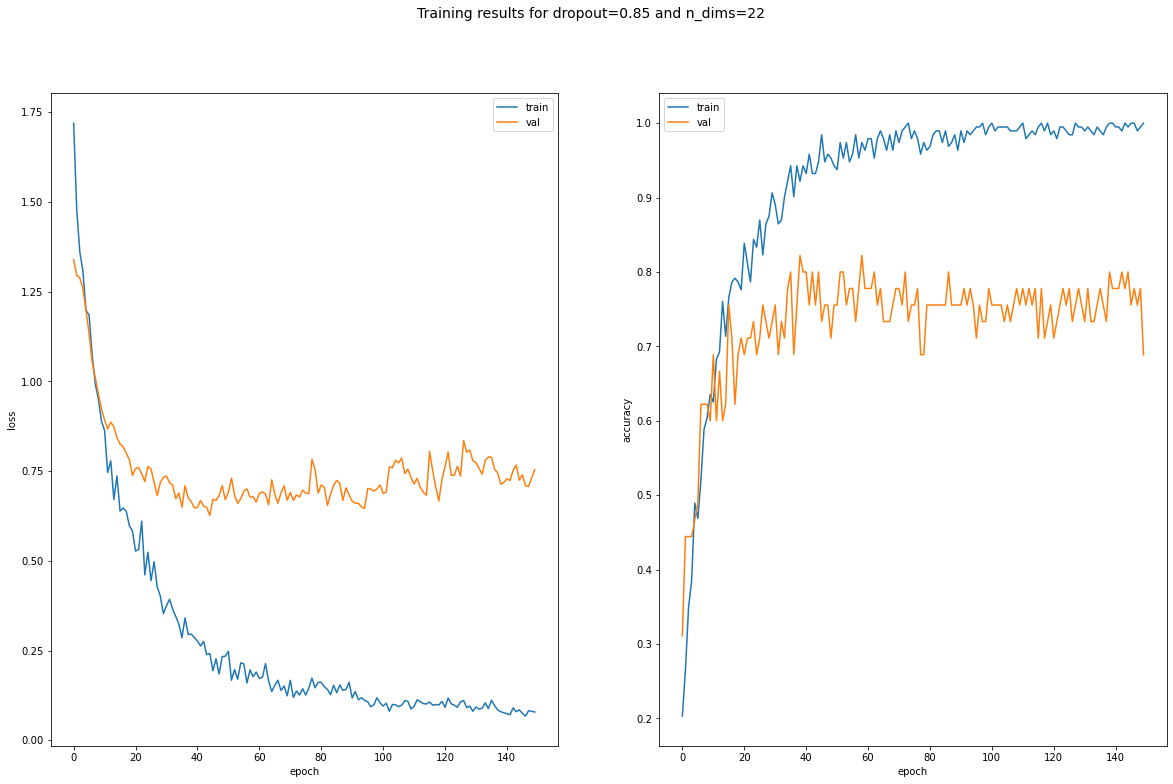

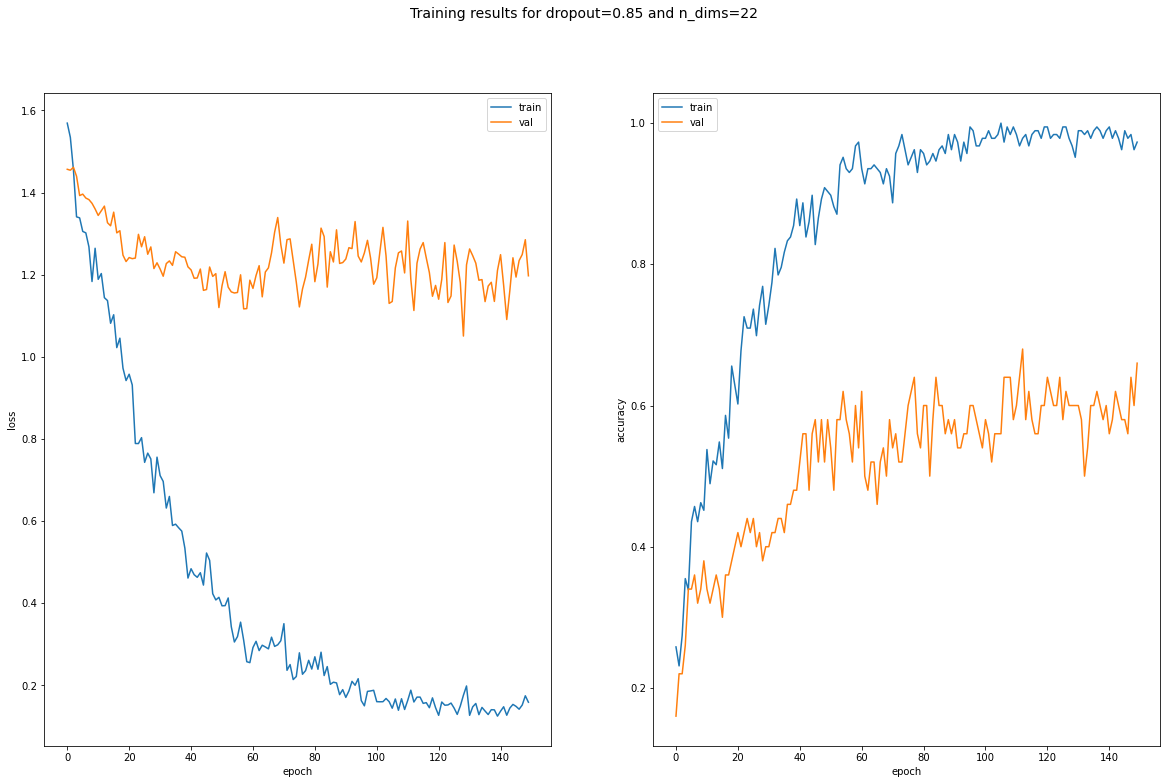

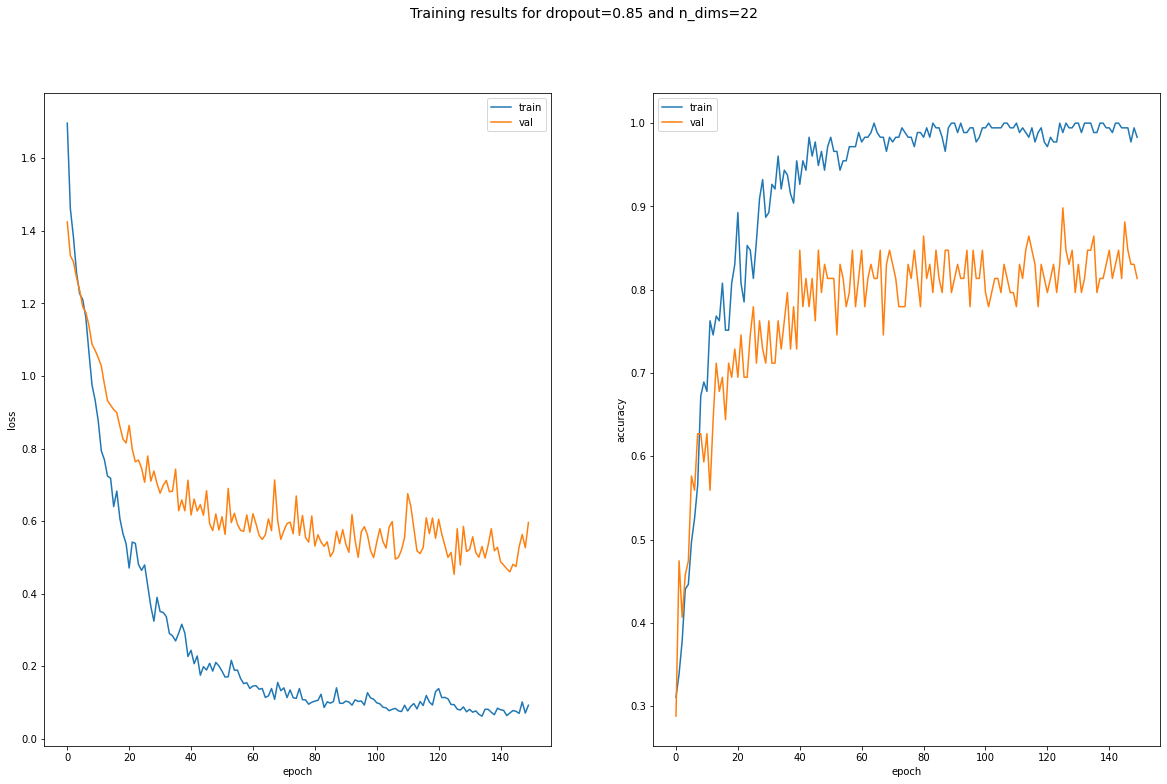

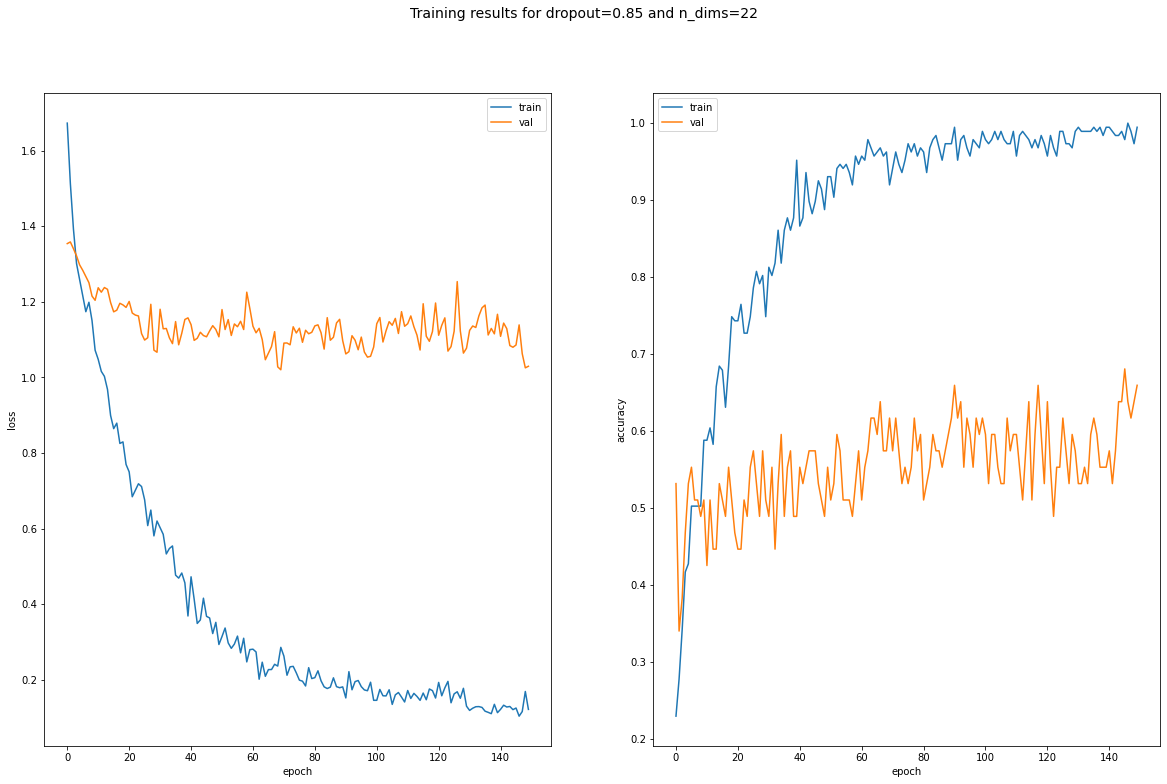

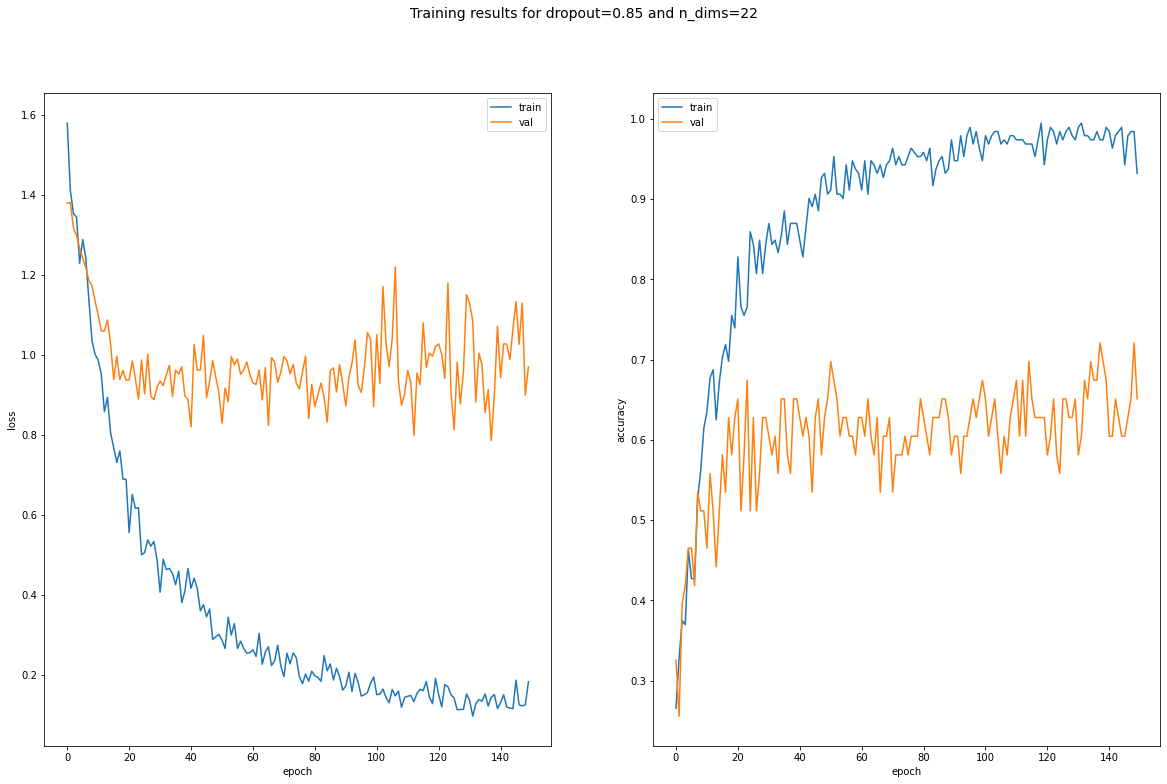

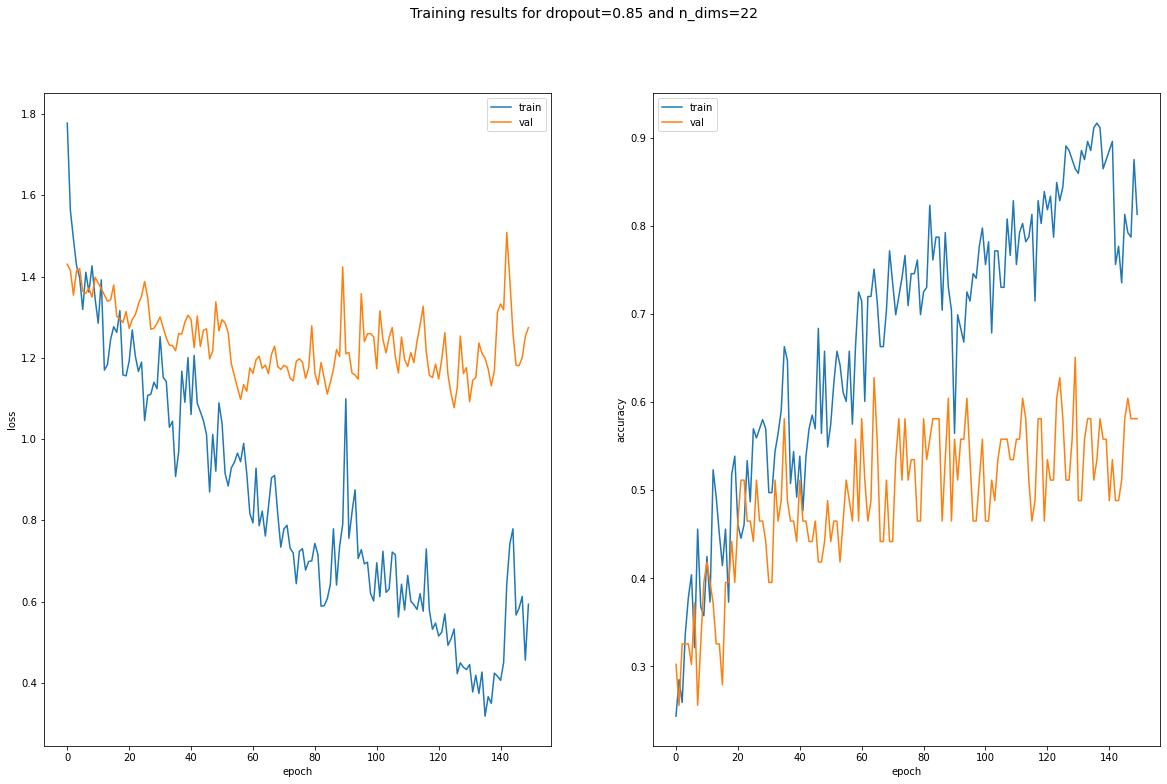

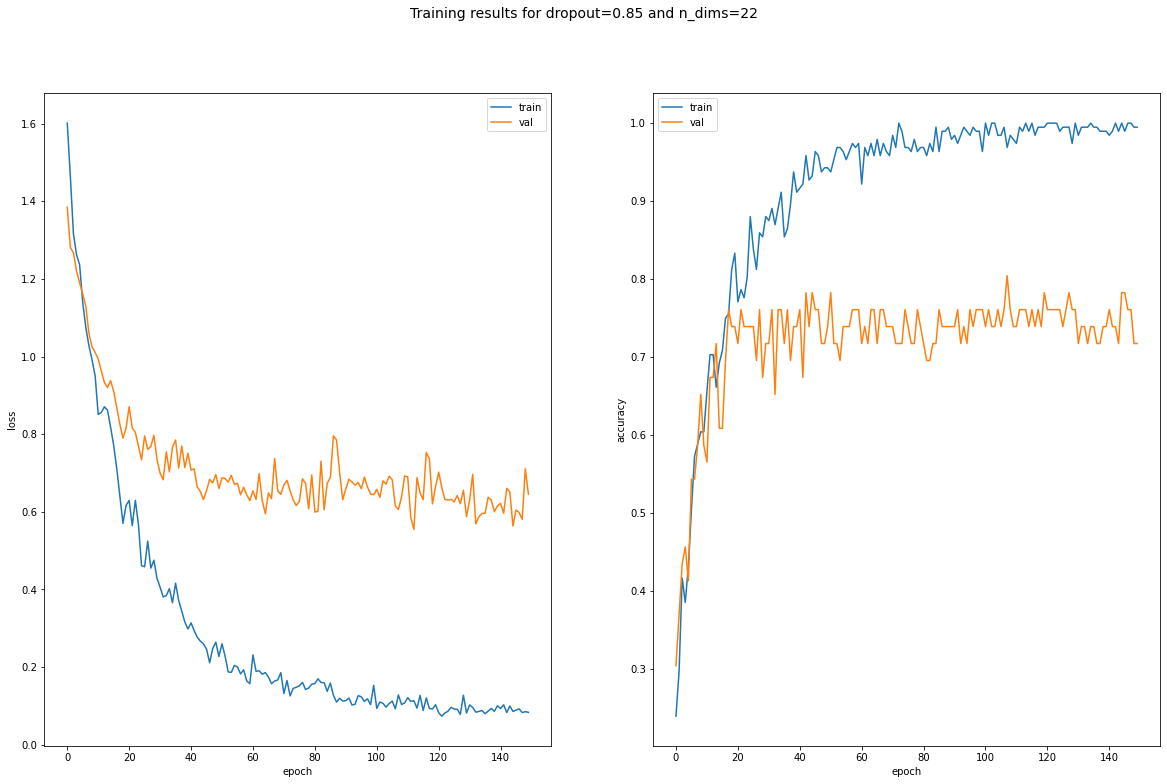

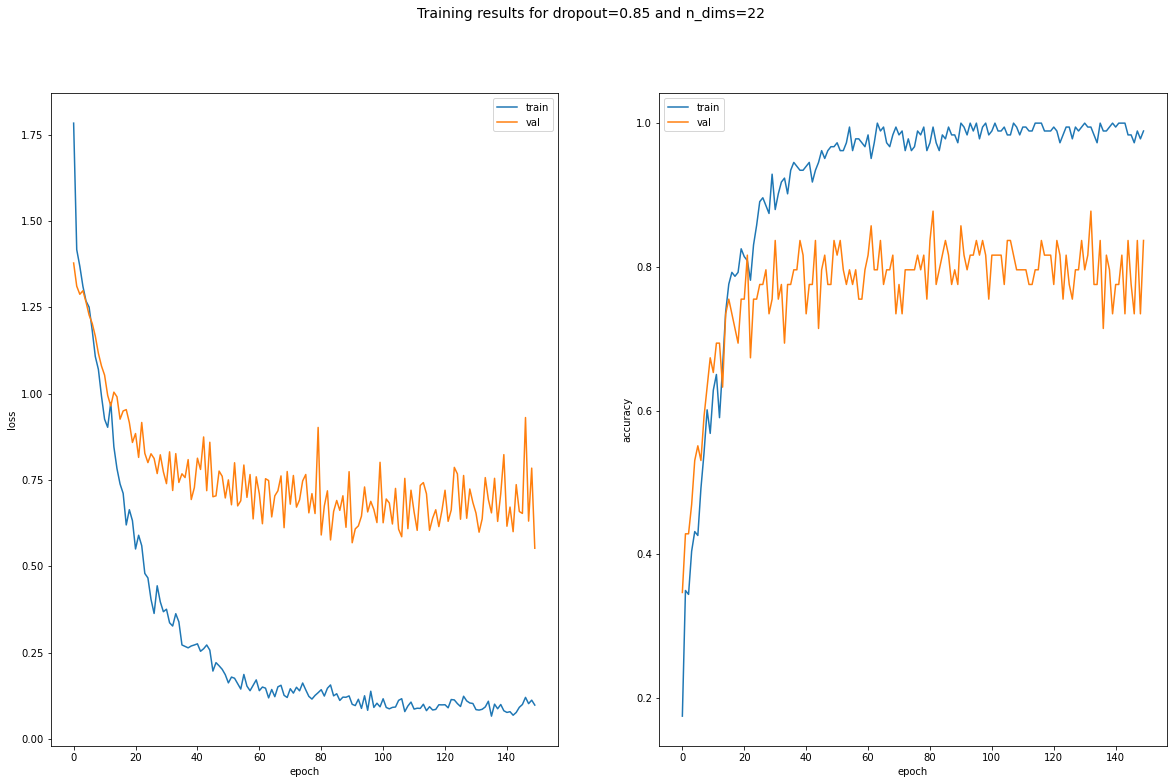

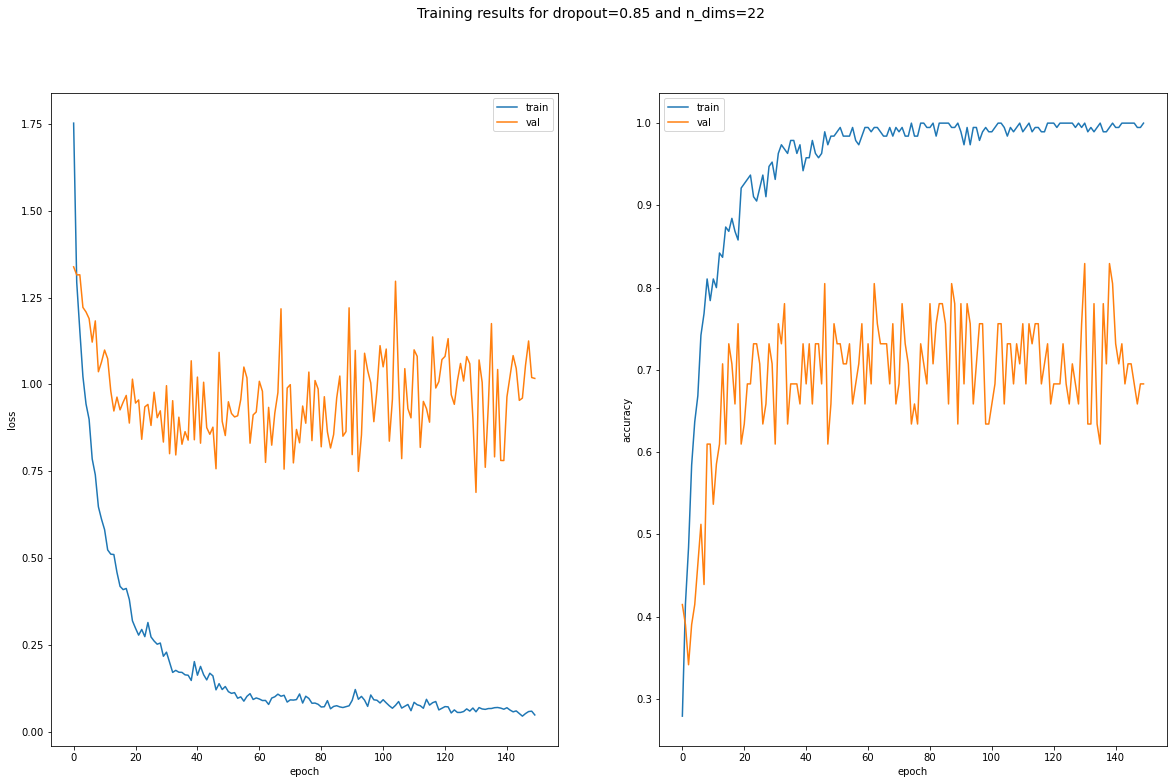

In [124]:
#Now let's train a model on the full-scale data with crop for all subjects

drp = 0.85
n_comp=22

subject_test_accs_full_crop = []
subject_test_accuracies_best_val_full_crop = []

for subject_ix in range(9):
    
    print("Trianing model for subject #{}".format(subject_ix))
    
    subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
    subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
    subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

    s_X_train = X_train_cropped[subject_indices_train]
    s_X_valid = X_valid_cropped[subject_indices_valid]
    s_X_test = X_test_cropped[subject_indices_test]

    s_y_train = y_train_1h[subject_indices_train]
    s_y_valid = y_valid_1h[subject_indices_valid]
    s_y_test = y_test_1h[subject_indices_test]

    
    model = get_model(n_timesteps=500, drp=0.85, n_comp=22)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                         save_best_only=True, monitor='val_loss', mode='min')
    
    loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                          validation_data=(s_X_valid, s_y_valid),
                          callbacks=[mcp_save], 
                          verbose=True)
    
    plot_train_hist(loss_hist,drp,n_comp,subject_ix)
    
    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate final step on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("final test loss, test acc:", results)
    subject_test_accs_full_crop.append(results[1])
    
    model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate best val acc model on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("best val loss model test loss, test acc:", results)

    subject_test_accuracies_best_val_full_crop.append(results[1])

In [125]:
print(subject_test_accs_full_crop)
print(subject_test_accuracies_best_val_full_crop)

subj_acc_means_crop_full = (np.array(subject_test_accs_full_crop) + np.array(subject_test_accuracies_best_val_full_crop))/2

[0.6200000047683716, 0.4000000059604645, 0.8399999737739563, 0.699999988079071, 0.7659574747085571, 0.40816327929496765, 0.7599999904632568, 0.7599999904632568, 0.8723404407501221]
[0.6600000262260437, 0.41999998688697815, 0.8399999737739563, 0.6399999856948853, 0.7234042286872864, 0.44897958636283875, 0.6399999856948853, 0.7599999904632568, 0.8085106611251831]


In [136]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

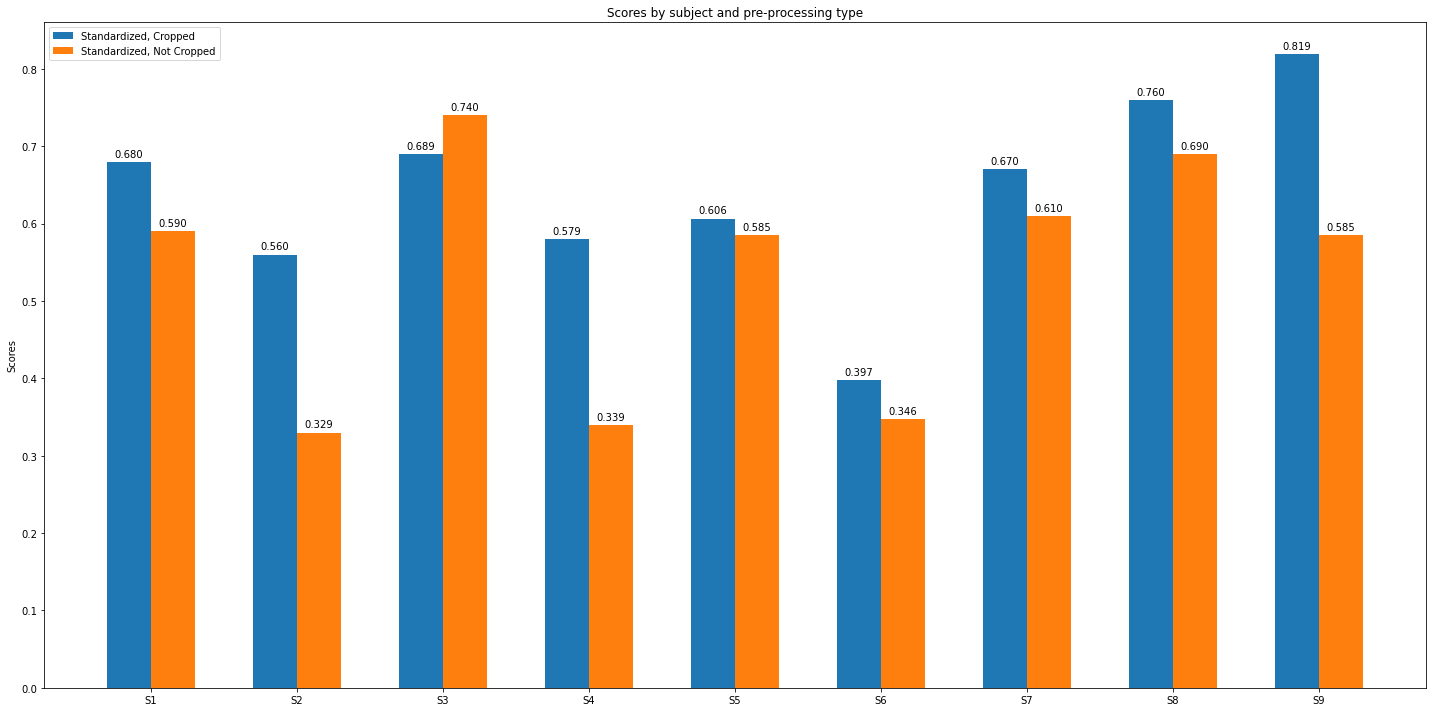

In [139]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']

#have means for 4 test cases: with and without crop for both with and without norm
#subj_acc_means_crop_norm
#subj_acc_means_nocrop_norm
#subj_acc_means_nocrop_full
#subj_acc_means_crop_full

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, subj_acc_means_crop_norm, width, label='Standardized, Cropped')
rects2 = ax.bar(x + width/2, subj_acc_means_nocrop_norm, width, label='Standardized, Not Cropped')
#rects3 = ax.bar(x - width/2, subj_acc_means_crop_full, width, label='Not Standardized, Cropped ')
#rects4 = ax.bar(x + width/2, subj_acc_means_nocrop_full, width, label='Not Standardized, Not Cropped')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by subject and pre-processing type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(truncate(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)

fig.tight_layout()

plt.show()


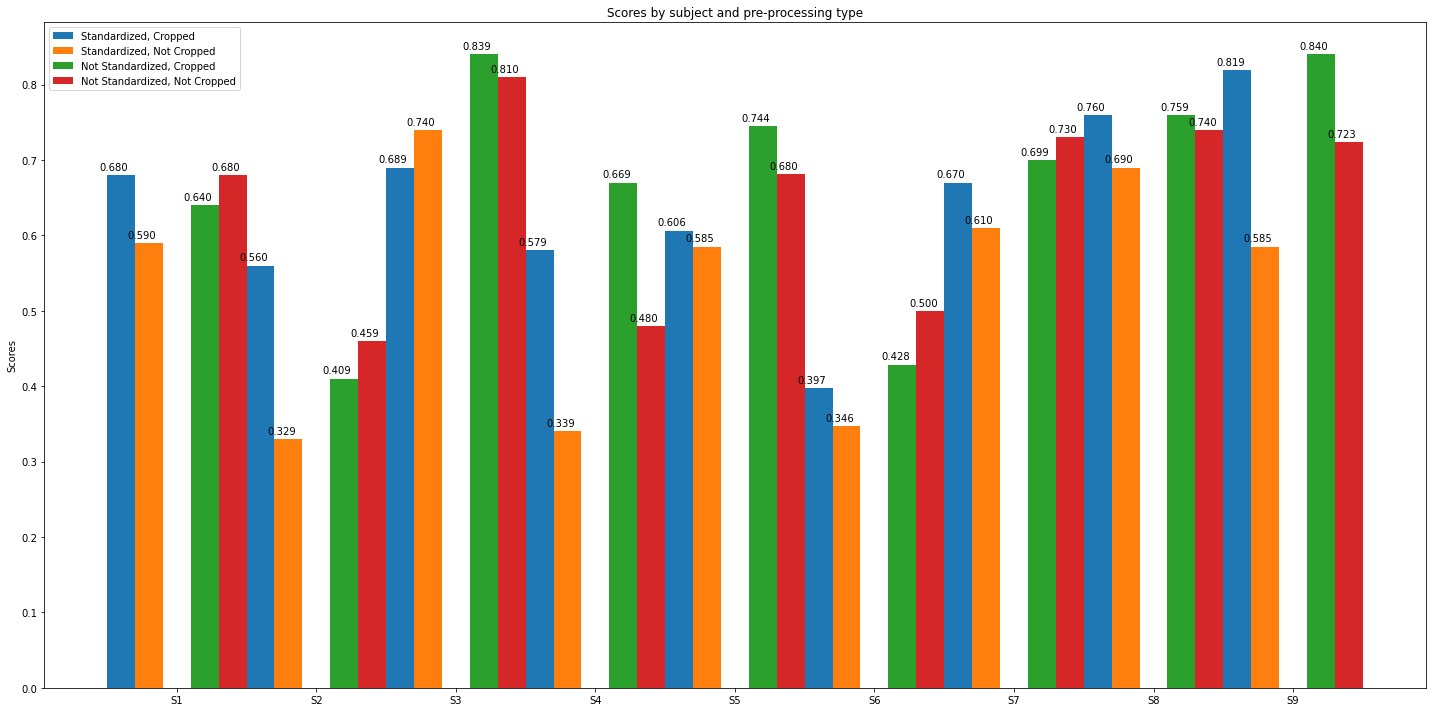

In [145]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']

#have means for 4 test cases: with and without crop for both with and without norm
#subj_acc_means_crop_norm
#subj_acc_means_nocrop_norm
#subj_acc_means_nocrop_full
#subj_acc_means_crop_full

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, subj_acc_means_crop_norm, width/2, label='Standardized, Cropped')
rects2 = ax.bar(x - width/2, subj_acc_means_nocrop_norm, width/2, label='Standardized, Not Cropped')
rects3 = ax.bar(x + width/2, subj_acc_means_crop_full, width/2, label='Not Standardized, Cropped ')
rects4 = ax.bar(x + width, subj_acc_means_nocrop_full, width/2, label='Not Standardized, Not Cropped')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by subject and pre-processing type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(truncate(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

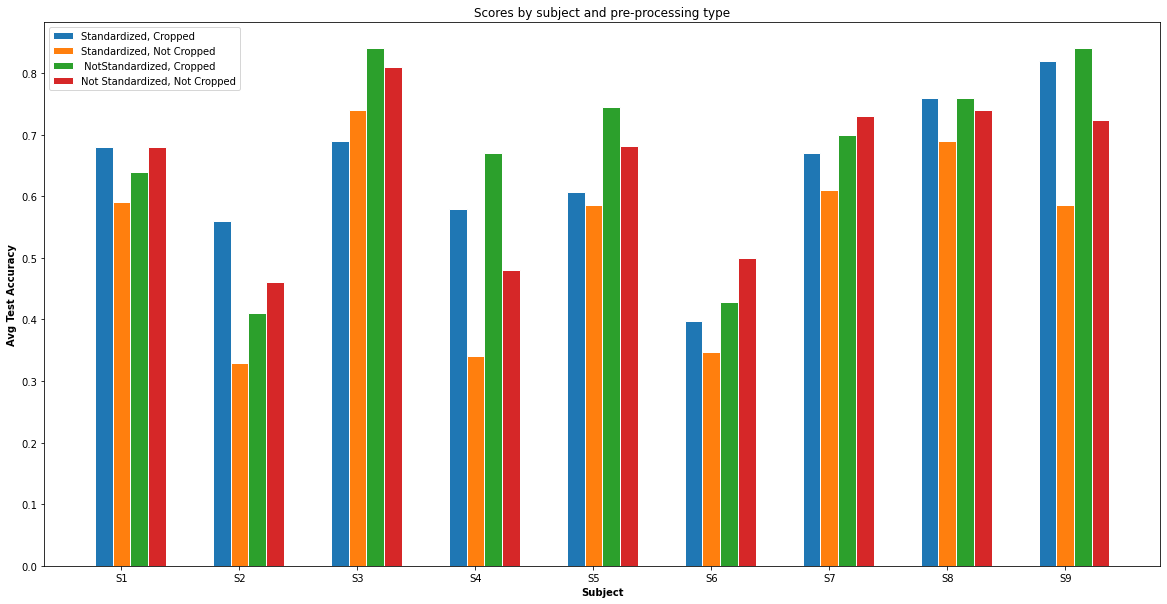

In [153]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bars
barWidth = 0.15

#have means for 4 test cases: with and without crop for both with and without norm
#subj_acc_means_crop_norm
#subj_acc_means_nocrop_norm
#subj_acc_means_nocrop_full
#subj_acc_means_crop_full
 
# set heights of bars
#bars1 = [12, 30, 1, 8, 22]
#bars2 = [28, 6, 16, 5, 10]
#bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(subj_acc_means_crop_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

fig= plt.figure(figsize=(20,10))
 
# Make the plot
plt.bar(r1, subj_acc_means_crop_norm, width=barWidth, edgecolor='white', label='Standardized, Cropped')
plt.bar(r2, subj_acc_means_nocrop_norm, width=barWidth, edgecolor='white', label='Standardized, Not Cropped')
plt.bar(r3, subj_acc_means_crop_full, width=barWidth, edgecolor='white', label=' NotStandardized, Cropped')
plt.bar(r4, subj_acc_means_nocrop_full, width=barWidth, edgecolor='white', label='Not Standardized, Not Cropped')


# Add xticks on the middle of the group bars
plt.title('Scores by subject and pre-processing type')
plt.xlabel('Subject', fontweight='bold')
plt.ylabel('Avg Test Accuracy', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(subj_acc_means_crop_norm))], ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

Epoch 1/150
42/42 [==============================] - 0s 9ms/step - loss: 1.7780 - acc: 0.2879 - val_loss: 1.3955 - val_acc: 0.3152
Epoch 2/150
42/42 [==============================] - 0s 6ms/step - loss: 1.4168 - acc: 0.3351 - val_loss: 1.3663 - val_acc: 0.3697
Epoch 3/150
42/42 [==============================] - 0s 6ms/step - loss: 1.4215 - acc: 0.3374 - val_loss: 1.3801 - val_acc: 0.3485
Epoch 4/150
42/42 [==============================] - 0s 6ms/step - loss: 1.4061 - acc: 0.3549 - val_loss: 1.3742 - val_acc: 0.3121
Epoch 5/150
42/42 [==============================] - 0s 7ms/step - loss: 1.3603 - acc: 0.3671 - val_loss: 1.3440 - val_acc: 0.3939
Epoch 6/150
42/42 [==============================] - 0s 6ms/step - loss: 1.3378 - acc: 0.3930 - val_loss: 1.3256 - val_acc: 0.3879
Epoch 7/150
42/42 [==============================] - 0s 6ms/step - loss: 1.3212 - acc: 0.4105 - val_loss: 1.3299 - val_acc: 0.3758
Epoch 8/150
42/42 [==============================] - 0s 6ms/step - loss: 1.2757 - a

42/42 [==============================] - 0s 7ms/step - loss: 0.7397 - acc: 0.7372 - val_loss: 0.8679 - val_acc: 0.6636
Epoch 64/150
42/42 [==============================] - 0s 6ms/step - loss: 0.7332 - acc: 0.7327 - val_loss: 0.8812 - val_acc: 0.6636
Epoch 65/150
42/42 [==============================] - 0s 6ms/step - loss: 0.8417 - acc: 0.6999 - val_loss: 1.0711 - val_acc: 0.5970
Epoch 66/150
42/42 [==============================] - 0s 6ms/step - loss: 0.8830 - acc: 0.6832 - val_loss: 0.9095 - val_acc: 0.6667
Epoch 67/150
42/42 [==============================] - 0s 6ms/step - loss: 0.7483 - acc: 0.7296 - val_loss: 0.8712 - val_acc: 0.7030
Epoch 68/150
42/42 [==============================] - 0s 7ms/step - loss: 0.7223 - acc: 0.7388 - val_loss: 0.8701 - val_acc: 0.6879
Epoch 69/150
42/42 [==============================] - 0s 6ms/step - loss: 0.6755 - acc: 0.7616 - val_loss: 0.8725 - val_acc: 0.6758
Epoch 70/150
42/42 [==============================] - 0s 6ms/step - loss: 0.6919 - acc: 0

Epoch 125/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5643 - acc: 0.8073 - val_loss: 0.8923 - val_acc: 0.6576
Epoch 126/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5393 - acc: 0.8180 - val_loss: 0.8681 - val_acc: 0.6697
Epoch 127/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5099 - acc: 0.8347 - val_loss: 0.9032 - val_acc: 0.6576
Epoch 128/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5645 - acc: 0.8165 - val_loss: 0.8531 - val_acc: 0.6667
Epoch 129/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5678 - acc: 0.8104 - val_loss: 0.8912 - val_acc: 0.6697
Epoch 130/150
42/42 [==============================] - 0s 7ms/step - loss: 0.5867 - acc: 0.8050 - val_loss: 0.8904 - val_acc: 0.6606
Epoch 131/150
42/42 [==============================] - 0s 6ms/step - loss: 0.5827 - acc: 0.7959 - val_loss: 0.9066 - val_acc: 0.6576
Epoch 132/150
42/42 [==============================] - 0s 6ms/step - 

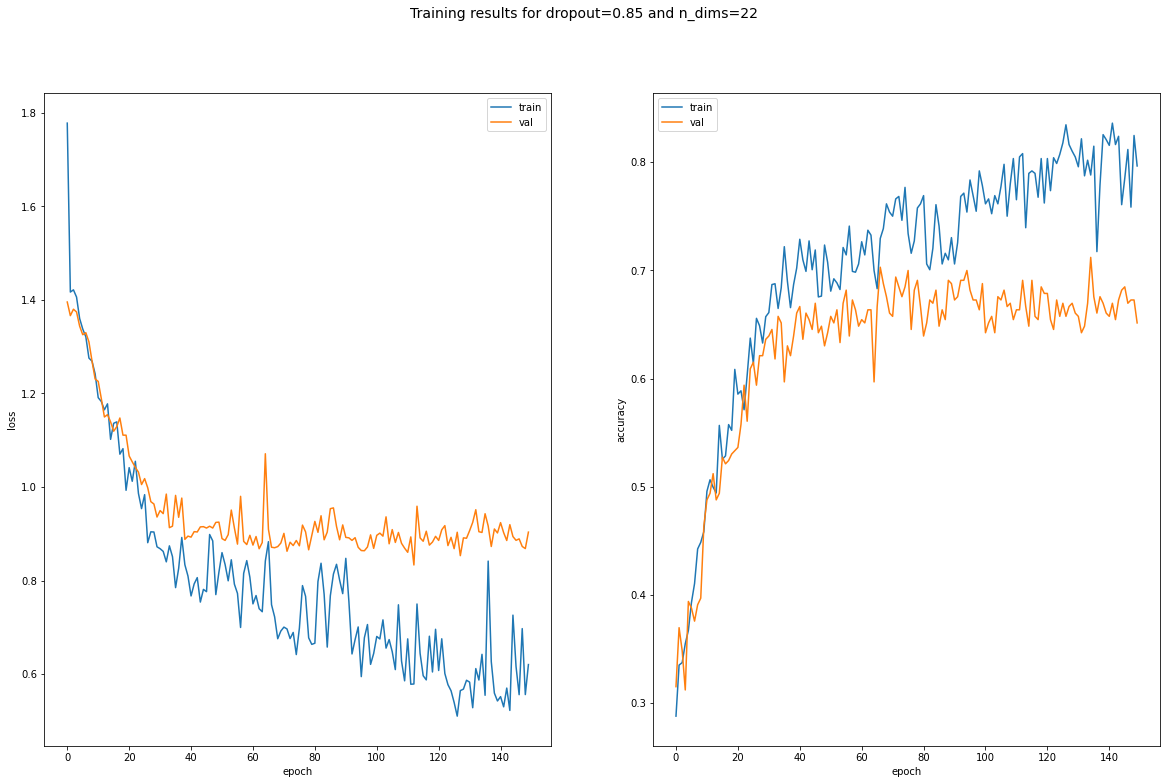

In [162]:
#try to train a model without the problematic subjects, 2 and 6
#let's do a crop and normalize the data first

subject_indices_train = train_df[(train_df['subject_ix']!=1) & (train_df['subject_ix']!=5)].index.values
subject_indices_valid = valid_df[(valid_df['subject_ix']!=1) & (valid_df['subject_ix']!=5)].index.values
subject_indices_test = test_df[(test_df['subject_ix']!=1) & (test_df['subject_ix']!=5)].index.values

s_X_train = X_train_norm_cropped[subject_indices_train]
s_X_valid = X_valid_norm_cropped[subject_indices_valid]
s_X_test = X_test_norm_cropped[subject_indices_test]

s_y_train = y_train_1h[subject_indices_train]
s_y_valid = y_valid_1h[subject_indices_valid]
s_y_test = y_test_1h[subject_indices_test]


model = get_model(n_timesteps=500, drp=0.8, n_comp=22)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                     save_best_only=True, monitor='val_loss', mode='min')

loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                      validation_data=(s_X_valid, s_y_valid),
                      callbacks=[mcp_save], 
                      verbose=True)

plot_train_hist(loss_hist,drp,n_comp,subject_ix)

# Evaluate the model on the test data using `evaluate`
#print("Evaluate final step on test data")
results = model.evaluate(s_X_test, s_y_test, batch_size=32)
print("final test loss, test acc:", results)
#subject_test_accs_full_crop.append(results[1])

model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

# Evaluate the model on the test data using `evaluate`
#print("Evaluate best val acc model on test data")
results = model.evaluate(s_X_test, s_y_test, batch_size=32)
print("best val loss model test loss, test acc:", results)

#subject_test_accuracies_best_val_full_crop.append(results[1])

Epoch 1/150
53/53 [==============================] - 0s 9ms/step - loss: 1.6540 - acc: 0.2736 - val_loss: 1.3790 - val_acc: 0.3191
Epoch 2/150
53/53 [==============================] - 0s 7ms/step - loss: 1.4369 - acc: 0.3428 - val_loss: 1.3529 - val_acc: 0.3759
Epoch 3/150
53/53 [==============================] - 0s 6ms/step - loss: 1.3954 - acc: 0.3694 - val_loss: 1.3467 - val_acc: 0.3664
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 1.3608 - acc: 0.3830 - val_loss: 1.3208 - val_acc: 0.4090
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 1.3434 - acc: 0.3895 - val_loss: 1.2864 - val_acc: 0.4350
Epoch 6/150
53/53 [==============================] - 0s 7ms/step - loss: 1.3096 - acc: 0.4108 - val_loss: 1.2478 - val_acc: 0.4634
Epoch 7/150
53/53 [==============================] - 0s 6ms/step - loss: 1.2688 - acc: 0.4515 - val_loss: 1.2239 - val_acc: 0.4704
Epoch 8/150
53/53 [==============================] - 0s 6ms/step - loss: 1.2168 - a

53/53 [==============================] - 0s 6ms/step - loss: 0.7703 - acc: 0.7222 - val_loss: 0.9542 - val_acc: 0.6336
Epoch 64/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7760 - acc: 0.7204 - val_loss: 0.9235 - val_acc: 0.6241
Epoch 65/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7417 - acc: 0.7246 - val_loss: 0.9297 - val_acc: 0.6359
Epoch 66/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7579 - acc: 0.7335 - val_loss: 0.9243 - val_acc: 0.6407
Epoch 67/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7405 - acc: 0.7388 - val_loss: 0.8996 - val_acc: 0.6643
Epoch 68/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7656 - acc: 0.7122 - val_loss: 0.9203 - val_acc: 0.6478
Epoch 69/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7517 - acc: 0.7270 - val_loss: 0.8926 - val_acc: 0.6643
Epoch 70/150
53/53 [==============================] - 0s 6ms/step - loss: 0.7693 - acc: 0

Epoch 125/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6298 - acc: 0.7931 - val_loss: 0.9227 - val_acc: 0.6596
Epoch 126/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6481 - acc: 0.7589 - val_loss: 0.9467 - val_acc: 0.6548
Epoch 127/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6466 - acc: 0.7890 - val_loss: 0.9342 - val_acc: 0.6714
Epoch 128/150
53/53 [==============================] - 0s 6ms/step - loss: 0.5982 - acc: 0.7967 - val_loss: 0.9295 - val_acc: 0.6879
Epoch 129/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6532 - acc: 0.7813 - val_loss: 0.9324 - val_acc: 0.6572
Epoch 130/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6027 - acc: 0.7961 - val_loss: 0.9133 - val_acc: 0.6619
Epoch 131/150
53/53 [==============================] - 0s 6ms/step - loss: 0.6157 - acc: 0.7896 - val_loss: 0.9278 - val_acc: 0.6714
Epoch 132/150
53/53 [==============================] - 0s 6ms/step - 

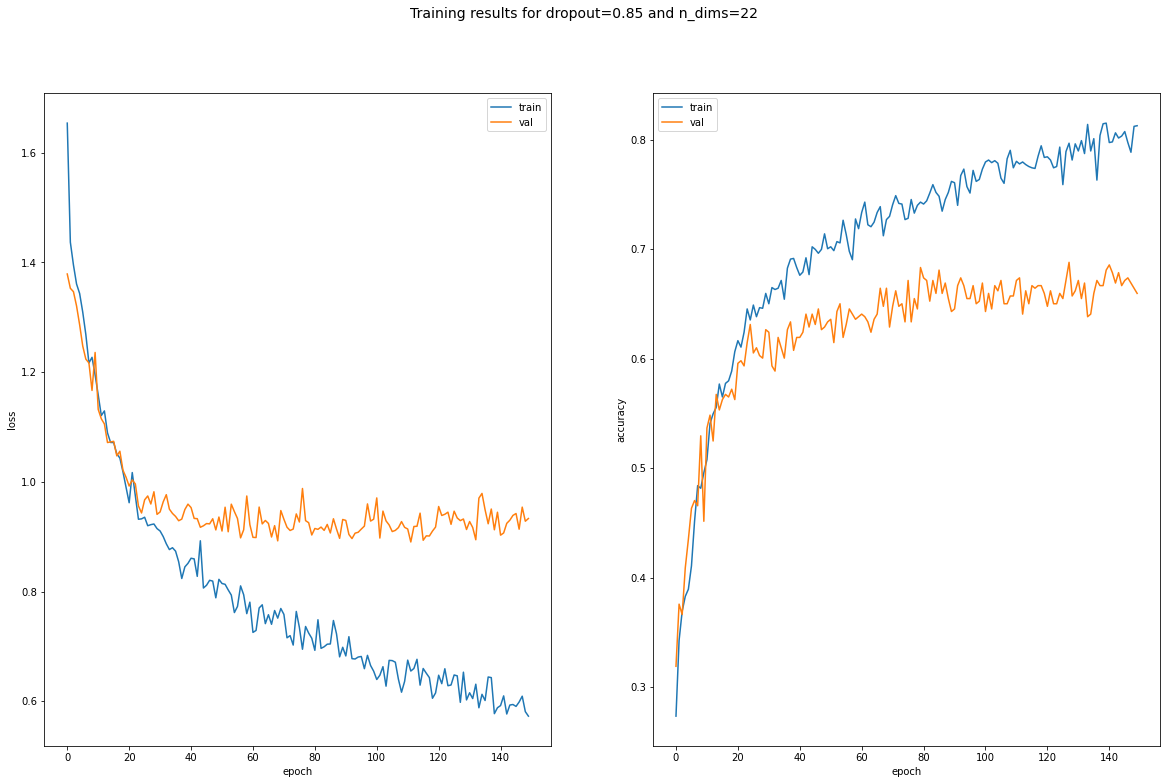

In [163]:
#try to train a model with the problematic subjects, 2 and 6, for comparison
#let's do a crop and normalize the data first

#subject_indices_train = train_df[(train_df['subject_ix']!=1) & (train_df['subject_ix']!=5)].index.values
#subject_indices_valid = valid_df[(valid_df['subject_ix']!=1) & (valid_df['subject_ix']!=5)].index.values
#subject_indices_test = test_df[(test_df['subject_ix']!=1) & (test_df['subject_ix']!=5)].index.values

s_X_train = X_train_norm_cropped
s_X_valid = X_valid_norm_cropped
s_X_test = X_test_norm_cropped

s_y_train = y_train_1h
s_y_valid = y_valid_1h
s_y_test = y_test_1h


model = get_model(n_timesteps=500, drp=0.8, n_comp=22, subject_classification=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                     save_best_only=True, monitor='val_loss', mode='min')

loss_hist = model.fit(s_X_train, s_y_train, epochs=150,
                      validation_data=(s_X_valid, s_y_valid),
                      callbacks=[mcp_save], 
                      verbose=True)

plot_train_hist(loss_hist,drp,n_comp,subject_ix)

# Evaluate the model on the test data using `evaluate`
#print("Evaluate final step on test data")
results = model.evaluate(s_X_test, s_y_test, batch_size=32)
print("final test loss, test acc:", results)
#subject_test_accs_full_crop.append(results[1])

model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

# Evaluate the model on the test data using `evaluate`
#print("Evaluate best val acc model on test data")
results = model.evaluate(s_X_test, s_y_test, batch_size=32)
print("best val loss model test loss, test acc:", results)

#subject_test_accuracies_best_val_full_crop.append(results[1])

In [ ]:
#so there's a 3-4% improvement just from omitting subjects 2 and 6

In [169]:
#let's try to classify which subject instead of which action is being performed
#Now let's train a model on the normalized data without crop for all subjects

drp = 0.85
n_comp=22
n_timesteps=500
n_outputs=9

#subject_test_accs_nocrop = []
#subject_test_accuracies_best_val_nocrop = []

#for subject_ix in range(9):
    
# print("Trianing model for subject #{}".format(subject_ix))

# subject_indices_train = train_df[train_df['subject_ix']==subject_ix].index.values
# subject_indices_valid = valid_df[valid_df['subject_ix']==subject_ix].index.values
# subject_indices_test = test_df[test_df['subject_ix']==subject_ix].index.values

# s_X_train = X_train_norm[subject_indices_train]
# s_X_valid = X_valid_norm[subject_indices_valid]
# s_X_test = X_test_norm[subject_indices_test]

# s_y_train = y_train_1h[subject_indices_train]
# s_y_valid = y_valid_1h[subject_indices_valid]
# s_y_test = y_test_1h[subject_indices_test]


input_ = layers.Input(shape=(n_comp, n_timesteps))
r1 = layers.Reshape(target_shape=(n_comp, n_timesteps, 1))(input_)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((n_timesteps-24, n_comp*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(drp)(f1)
output_ = layers.Dense(n_outputs, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

model = models.Model(inputs=input_, outputs=output_, name='shallow_pca_convnet_one_hot')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "shallow_pca_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_144 (InputLayer)       [(None, 22, 500)]         0         
_________________________________________________________________
reshape_286 (Reshape)        (None, 22, 500, 1)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
permute_143 (Permute)        (None, 476, 22, 40)       0         
_________________________________________________________________
reshape_287 (Reshape)        (None, 476, 880)          0         
_________________________________________________________________
dense_284 (Dense)            (None, 476, 40)           35240     
_________________________________________________________________
activation_284 (Activation)  (None, 476

Epoch 1/50
53/53 [==============================] - 0s 7ms/step - loss: 3.0570 - acc: 0.3452 - val_loss: 0.7976 - val_acc: 0.8085
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.8534 - acc: 0.7488 - val_loss: 0.4513 - val_acc: 0.9054
Epoch 3/50
53/53 [==============================] - 0s 7ms/step - loss: 0.4803 - acc: 0.8818 - val_loss: 0.2798 - val_acc: 0.9764
Epoch 4/50
53/53 [==============================] - 0s 7ms/step - loss: 0.3605 - acc: 0.9314 - val_loss: 0.2250 - val_acc: 0.9764
Epoch 5/50
53/53 [==============================] - 0s 6ms/step - loss: 0.2830 - acc: 0.9634 - val_loss: 0.2099 - val_acc: 0.9811
Epoch 6/50
53/53 [==============================] - 0s 7ms/step - loss: 0.2553 - acc: 0.9704 - val_loss: 0.1948 - val_acc: 0.9835
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 0.2470 - acc: 0.9675 - val_loss: 0.1949 - val_acc: 0.9835
Epoch 8/50
53/53 [==============================] - 0s 6ms/step - loss: 0.2294 - acc: 0.97

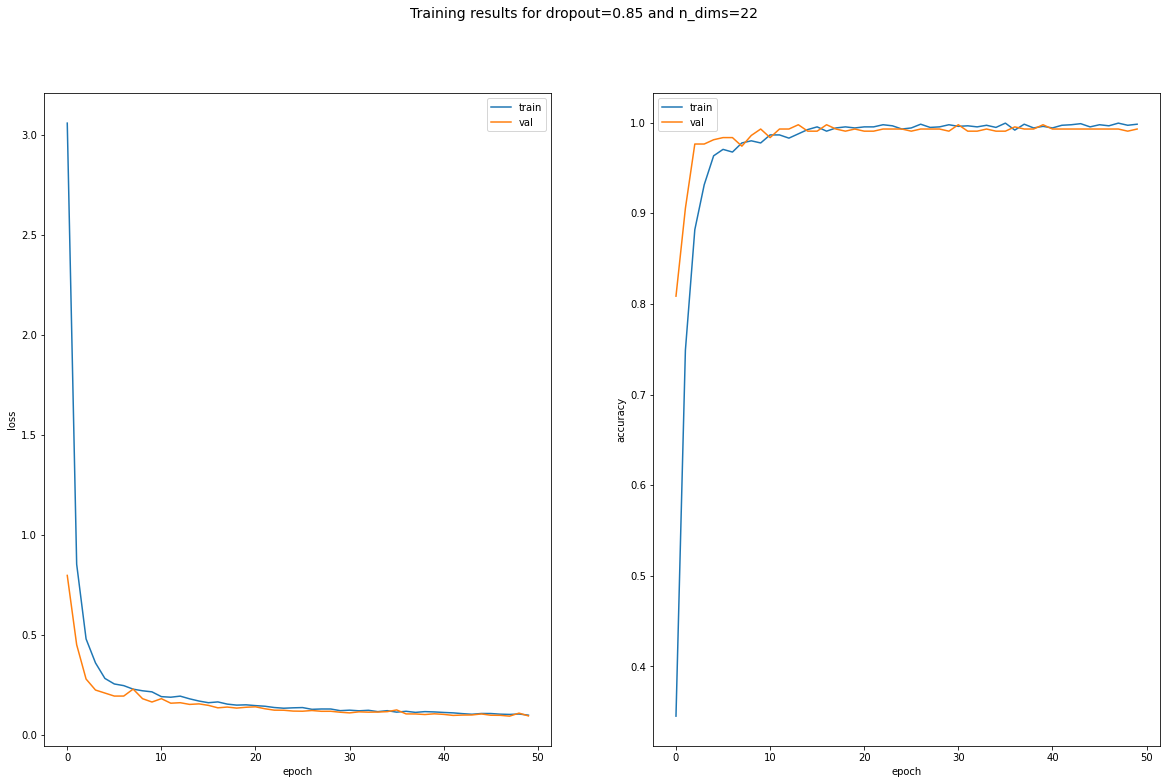

In [172]:
mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5',
                                     save_best_only=True, monitor='val_loss', mode='min')

loss_hist = model.fit(X_train_norm_cropped, person_train_1h, epochs=50,
                      validation_data=(X_valid_norm_cropped, person_valid_1h),
                      callbacks=[mcp_save], 
                      verbose=True)

plot_train_hist(loss_hist,drp,n_comp,subject_ix)

# Evaluate the model on the test data using `evaluate`
#print("Evaluate final step on test data")
results = model.evaluate(X_test_norm_cropped, person_test_1h, batch_size=32)
print("final test loss, test acc:", results)
#subject_test_accs_nocrop.append(results[1])

model.load_weights('.mdl_wts_best_acc_subj' + str(subject_ix) + '_' + str(n_comp) + 'dims.hdf5')

# Evaluate the model on the test data using `evaluate`
#print("Evaluate best val acc model on test data")
results = model.evaluate(X_test_norm_cropped, person_test_1h, batch_size=32)
print("best val loss model test loss, test acc:", results)

#subject_test_accuracies_best_val_nocrop.append(results[1])